In [1]:
import pandas as pd
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objs as go
import dask.dataframe as dd
import matplotlib.cm as cm
import os

In [2]:
Analise_Potencia = False
Analise_Reserva = False
Analise_Linhas = False
Analise_alldata = False
Analise_INDICE = True
Analise_tabelainfo = False

In [3]:
mainpath = 'C:/Users/david/OneDrive/Documents/FERV_documentos/RESULTS'
dic_cenarios = {
                # 'MPA FNS Lim Scenario 2022' : f'{mainpath}/MPV_(FNS Lim)_RC/',
                # 'V1A1F2 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F2 2026' :f'{mainpath}/V1A1F2_RESP_FNS_lim_rev2_2026/',
                # 'V1A1F3 2026' :f'{mainpath}/V1A1F3_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F4 2026' :f'{mainpath}/V1A1F4_RESP_FNS_lim_rev1_2026/',
                # 'V1A1F5 2026' :f'{mainpath}/V1A1F5_RESP_FNS_lim_rev1_2026/',

                'V1A1F2' :f'{mainpath}/V1A1F2_rev5/',
                'V1A1F3' :f'{mainpath}/V1A1F3_rev5/',
                'V1A1F4' :f'{mainpath}/V1A1F4_rev5/',
                'V1A1F5' :f'{mainpath}/V1A1F5_rev5/',

                # 'V2A2F2 2026' :f'{mainpath}/V2A2F2_REV02_2026/',
                # 'V2A2F3 2026' :f'{mainpath}/V2A2F3_REV02_2026/',
                # 'V2A2F4 2026' :f'{mainpath}/V2A2F4_REV02_2026/', 
                # 'V2A2F5 2026' :f'{mainpath}/V2A2F5_REV02_2026/',

                'V2A2F2' :f'{mainpath}/V2A2F2_rev5/', 
                'V2A2F3' :f'{mainpath}/V2A2F3_rev5/',
                'V2A2F4' :f'{mainpath}/V2A2F4_rev5/', 
                'V2A2F5' :f'{mainpath}/V2A2F5_rev5/',

                # 'V2A2F2 2026 UNICAMP' :f'{mainpath}/V2A2F2_RESP_in_FNS_lim_Unicamp/',
                # 'V2A2F3 2026 UNICAMP' :f'{mainpath}/V2A2F3_RESP_in_FNS_lim_Unicamp/',
                # 'V2A2F4 2026 UNICAMP' :f'{mainpath}/V2A2F4_RESP_in_FNS_lim_Unicamp/', 
                # 'V2A2F5 2026 UNICAMP' :f'{mainpath}/V2A2F5_RESP_in_FNS_lim_Unicamp/',

                # 'V3A3F2 2026' :f'{mainpath}/V3A3F2_REV1_2026/',
                # 'V3A3F3 2026' :f'{mainpath}/V3A3F3_REV1_2026/',
                # 'V3A3F4 2026' :f'{mainpath}/V3A3F4_REV1_2026/',
                # 'V3A3F5 2026' :f'{mainpath}/V3A3F5_REV1_2026/',

                'V3A3F2' :f'{mainpath}/V3A3F2_rev5/',
                'V3A3F3' :f'{mainpath}/V3A3F3_rev5/',
                'V3A3F4' :f'{mainpath}/V3A3F4_rev5/', 
                'V3A3F5' :f'{mainpath}/V3A3F5_rev5/',
                }

dirGeral = 'StaticAnalysis/Data/Geral/'
# dirIndice = 'StaticAnalysis/Data/Indice_n_supremo/'
dirIndice = 'StaticAnalysis/Data/Indice_n_2/'
dirRamos = 'StaticAnalysis/Data/Fluxo em Ramos/'
dirPotencia = 'StaticAnalysis/Data/Potencia/'

filenames = [
                (dirGeral + 'OPF_NC.csv', 'OPF_NC'), 
                (dirGeral + 'PWF_NC.csv', 'PWF_NC'),
                (dirGeral + 'Df_ger.csv', 'ger'), 
                (dirGeral + 'Df_nt.csv', 'nt'), 
                # (dirRamos + 'Df_Linhas.csv', 'linhas'), 
                # (dirRamos + 'Df_Trafo.csv', 'Trafo'), 
                # (dirRamos + 'DF_Intercambios.csv', 'intercambios'), 
                # (dirRamos + 'DF_HVDC.csv', 'HVDC'),
                # (dirPotencia +'Df_Reserva_PO_MW.csv', 'pot_mw_reserv'),  
                # (dirIndice + 'Df_DPI_S2.csv', 'Index'), 
                (dirIndice +'Df_DPI_S4.csv', 'Index_PO'),  #deixar esse descomentado para poder filtrar os não convergidos
                # (dirIndice + 'Df_DPI_S3.csv', 'Index_Modif'), 
                # (dirIndice +'Df_PQ_DPI_S1.csv', 'IndexDec_PQ'), 
                # (dirIndice +'Df_PV_DPI_S1.csv', 'IndexDec_PV'), 
                # (dirPotencia+'Df_MW-MVAR_PO.csv', 'pot_mw_mvar'), 
                (dirPotencia+'DF_POT_Reg.csv', 'ger_reg'),
            ]
import colorcet as cc
intense_palette = sns.color_palette(cc.glasbey, n_colors=12)  # You can adjust the number of colors as needed
namescenarios = {key:[key,intense_palette[idx]] for idx, key in enumerate(dic_cenarios.keys())}
itemsforanalysis = [var for _,var in filenames]

# Data Processing

## Funtions for extract and process

In [4]:
# Optimized read_and_append function using Dask
def read_and_append(filename, cenario, lst):
    df = dd.read_csv(filename)  # Keep as Dask DataFrame for now
    df['Cenario'] = cenario
    # Avoid converting to pandas immediately; do this after processing
    lst.append(df)
    return lst

# Function to load and process all datasets
def load_and_process_data(dic_cenarios, filenames):
    keys = [i for _, i in filenames]
    dfs = {key: [] for key in keys}

    # Read and append data from each scenario and filename
    for cenario, path in dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(path + filename, cenario, dfs[key])

    # Convert all dask DataFrames to pandas after appending
    dfs = {key: dd.concat(lst).compute() for key, lst in dfs.items()}
    
    return dfs

# Function to calculate indices for lines
def IndiceLinhas(df, n):

    df['MW_Flow'] = np.where(df['MW:From-To'] >= 0, df['MW:From-To'], df['MW:To-From'])
    df['PI_mva'] = (df['% L1'] / 100) ** (2 * n)

    # Group by multiple columns and aggregate
    df_r_nt_1 = df[df['VBASEKV']>=500].groupby(
        ['key', 'Cenario', 'REG']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    df_r_nt_2 = df[df['VBASEKV']<500].groupby(
        ['key', 'Cenario', 'REG']
    ).agg({'MW_Flow': 'sum', 'MVA': 'sum', 'PI_mva': 'sum'})

    df_r_nt_1['PI_mva_500up'] = df_r_nt_1['PI_mva'] ** (1 / (2 * n))
    df_r_nt_2['PI_mva_500down'] = df_r_nt_2['PI_mva'] ** (1 / (2 * n))

    df_r_nt = df_r_nt_1[['PI_mva_500up']].merge(df_r_nt_2[['PI_mva_500down']], on=['key', 'Cenario', 'REG'], how='outer')
    df_r_nt.fillna({'PI_mva_500up': 0, 'PI_mva_500down': 0,}, inplace=True)

    return df_r_nt

# Function to flatten DataFrame
def flatdf(df, BG):
    df_reordered = df.reorder_levels(['key','Dia', 'Hora', 'Cenario', 'REG', BG])
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
    }
    df_reordered = df_reordered.rename(index=regionmap, level='REG')
    df_reordered_sorted = df_reordered.sort_index(level=['key','Dia', 'Hora', 'Cenario', 'REG'])
    df_reordered_sorted.rename(columns={'CSI_INF': 'DPI_inf', 'CSI_SUP': 'DPI_sup'}, inplace=True)

    lista = [[index[0], index[1], index[2], index[3]] for index in df_reordered.index]
    conjunto_filtros = set(map(tuple, lista))
    conjunto_filtros = tuple(sorted(conjunto_filtros))

    data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
    datapd = pd.DataFrame(data, index=conjunto_filtros)
    datapd.index.names = ['key','Dia', 'Hora', 'Cenario']
    
    columns = []
    for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
        for bg in df_reordered_sorted.loc[:, :, :, : ,reg, :].reset_index(BG)[BG].unique():
            for column in df_reordered_sorted.columns:
                reg_name = 'SE-CO' if reg == 'Sudeste-Centro-Oeste' else reg
                columns.append(f"{column}_{reg_name}_{bg}")

    datapd.columns = columns
    return datapd

# Function to read data
def read_data():
    def read_and_append(filename, cenario, lst):
        df = dd.read_csv(filename)
        df['Cenario'] = cenario
        # if cenario == 'V1A1F2 Scenario 2022 FNS':
        #     df['Dia'] = df['Dia'] - 1
        lst.append(df.compute())
        return lst

    keys = [i for _,i in filenames]
    dfs = {}
    for key in keys:
        dfs[key] = []
    for i,j in  dic_cenarios.items():
        for filename, key in filenames:
            dfs[key] = read_and_append(j + filename, i, dfs[key])

    return dfs

# Funtion to obtain the main features (buses) that contribute in the DPI_1 
def computefeatures(df_nt, df_ger, dfpq, dfpv):
    # Step 1: Merge DataFrames with only necessary columns
    dfpq_cols = ['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'CSI_INF', 'CSI_SUP']
    dfpv_cols = ['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type', 'CSI_INF', 'CSI_SUP']

    datafeatures_pq = df_nt.merge(dfpq[dfpq_cols], on=['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'], how='left')
    datafeatures_pq = datafeatures_pq[['BUS_ID', 'BUS_NAME', 'ARE', 'VBASEKV', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'B0_MVAR']]

    datafeatures_pv = df_ger.merge(dfpv[dfpv_cols], on=['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type'], how='left')
    datafeatures_pv = datafeatures_pv[['BUS_ID', 'BUS_NAME', 'ARE', 'Gen_Type', 'REG', 'U_FED', 'Dia', 'Hora', 'CSI_INF', 'CSI_SUP', 'IndiceInf', 'IndiceSup', 'PG_MW', 'QG_MVAR']]

    # Step 2: Calculate Importance using vectorized operations
    datafeatures_pq['Importance_inf'] = datafeatures_pq['IndiceInf'] / datafeatures_pq['CSI_INF'].replace(0, np.nan)
    datafeatures_pq['Importance_sup'] = datafeatures_pq['IndiceSup'] / datafeatures_pq['CSI_SUP'].replace(0, np.nan)

    datafeatures_pv['Importance_inf'] = datafeatures_pv['IndiceInf'] / datafeatures_pv['CSI_INF'].replace(0, np.nan)
    datafeatures_pv['Importance_sup'] = datafeatures_pv['IndiceSup'] / datafeatures_pv['CSI_SUP'].replace(0, np.nan)

    # Step 3: Filter rows directly without fillna
    datafeatures_pq = datafeatures_pq[datafeatures_pq['B0_MVAR'].notna() & (datafeatures_pq['B0_MVAR'] != 0)]
    datafeatures_pv = datafeatures_pv[datafeatures_pv['QG_MVAR'].notna() & (datafeatures_pv['QG_MVAR'] != 0)]

    # Optional: Fill NaN values in other columns with zero if necessary
    datafeatures_pq.fillna(0, inplace=True)
    datafeatures_pv.fillna(0, inplace=True)
    
    # Step 4: Group by BUS_ID and aggregate fields
    dfeatures_pq = datafeatures_pq.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'VBASEKV': 'first',
        'BUS_NAME': 'first'
    }).reset_index()
    
    dfeatures_pv = datafeatures_pv.groupby('BUS_ID').agg({
        'Importance_inf': 'mean',
        'Importance_sup': 'mean',
        'REG': 'first',
        'Gen_Type': 'first',
        'BUS_NAME': 'first'
    }).reset_index()
    
    # Step 5: Extract top `nbuses` rows for Importance_inf and Importance_sup
    nbuses = 5
    
    def top_n_group(df, group_cols, sort_col, n):
        return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)
    
    result_inf_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'Importance_inf', nbuses)[['REG', 'VBASEKV', 'BUS_ID', 'BUS_NAME', 'Importance_inf']]
    result_sup_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'Importance_sup', nbuses)[['REG', 'VBASEKV', 'BUS_ID', 'BUS_NAME', 'Importance_sup']]
    result_inf_pv = top_n_group(dfeatures_pv, ['REG', 'Gen_Type'], 'Importance_inf', nbuses)[['REG', 'Gen_Type', 'BUS_ID', 'BUS_NAME', 'Importance_inf']]
    result_sup_pv = top_n_group(dfeatures_pv, ['REG', 'Gen_Type'], 'Importance_sup', nbuses)[['REG', 'Gen_Type', 'BUS_ID', 'BUS_NAME', 'Importance_sup']]
    
    # Step 6: Filter by BUS_ID
    features_inf_pq = result_inf_pq[result_inf_pq['Importance_inf'] != 0]
    features_sup_pq = result_sup_pq[result_sup_pq['Importance_sup'] != 0]
    features_inf_pv = result_inf_pv[result_inf_pv['Importance_inf'] != 0]
    features_sup_pv = result_sup_pv[result_sup_pv['Importance_sup'] != 0]
    
    # Step 7: Pivot tables
    def pivot_table(df, values_list, value_column, index_columns=['Dia', 'Hora', 'Cenario'], pivot_column='BUS_NAME'):
        filtered_df = df[df['BUS_ID'].isin(values_list)]
        pivot_df = filtered_df.pivot_table(index=index_columns, columns=pivot_column, values=value_column, aggfunc='first').reset_index()
        return pivot_df
    
    features_sup_pq_df = pivot_table(df_nt, features_sup_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_inf_pq_df = pivot_table(df_nt, features_inf_pq['BUS_ID'].to_list(), 'B0_MVAR')
    features_sup_pv_df = pivot_table(df_ger, features_sup_pv['BUS_ID'].to_list(), 'QG_MVAR')
    features_inf_pv_df = pivot_table(df_ger, features_inf_pv['BUS_ID'].to_list(), 'QG_MVAR')
    
    return features_sup_pq_df, features_inf_pq_df, features_sup_pv_df, features_inf_pv_df

# Funtion to obtain the main features (buses) that contribute in the Line index
def computefeatures_2(df_nt, df_r_nt):

    datafeatures_pq = df_nt.merge(df_r_nt, on=['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV'], how='left')[['From#', 'To#', 'From Name', 'To Name', '% L1', 'Mvar:Losses', 'Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'Mva_index']]

    # Step 2: Calculate Importance using vectorized operations
    datafeatures_pq['importance_lines'] = datafeatures_pq['% L1'] / datafeatures_pq['Mva_index'].replace(0, np.nan)
    datafeatures_pq.fillna(0, inplace=True)

    # Step 4: Group by BUS_ID and aggregate fields
    dfeatures_pq = datafeatures_pq.groupby(['From#', 'To#']).agg({
        'importance_lines': 'mean',
        'REG': 'first',
        'VBASEKV': 'first',
        'From Name': 'first',
        'To Name':'first'
    }).reset_index()
    
    # Step 5: Extract top `nbuses` rows for Importance_inf and Importance_sup
    nlines = 5
    
    def top_n_group(df, group_cols, sort_col, n):
        return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)
    
    result_inf_pq = top_n_group(dfeatures_pq, ['REG', 'VBASEKV'], 'importance_lines', nlines)[['REG', 'VBASEKV','From#', 'To#', 'From Name', 'To Name','importance_lines']]
    result_inf_pq = result_inf_pq.set_index(['From Name', 'To Name'])
    mask = df_nt[['From Name', 'To Name']].apply(tuple, axis=1)
    filteredlines = df_nt[mask.isin(result_inf_pq.index)]

    # Step 7: Pivot tables
    def pivot_table(df, value_column, index_columns=['Dia', 'Hora', 'Cenario'], pivot_column=['From Name', 'To Name']):
        pivot_df = df.pivot_table(index=index_columns, columns=pivot_column, values=value_column, aggfunc='first').reset_index()
        return pivot_df

    features_inf_pq_df = pivot_table(filteredlines, ['% L1', 'Mvar:Losses'])
    # features_inf_pq_df = pivot_table(filteredlines, ['MW_Flow'])
    features_inf_pq_df.columns = [' |'.join(filter(None, col)).strip() for col in features_inf_pq_df.columns]

    return  features_inf_pq_df

# Function to filter data based on non-convergent conditions
def filtarNC(df, dfconv):
    mask_PWFCV = dfconv.reset_index()[['key', 'Cenario']]
    df_out = df.reset_index().merge(mask_PWFCV, on=['key', 'Cenario'], how='inner')
    
    return df_out

## Funtions for concatenate

In [5]:
# Function to concatenate and process data (part 1)
def concatenation_1(data):

    print('====== First Concatenation ======')
    if all(keyword in itemsforanalysis for keyword in ['IndexDec_PV', 'IndexDec_PQ', 'Index_Modif', 'Index']):

        ddffpv = data['IndexDec_PV'].set_index(['Dia', 'Hora', 'Cenario', 'REG', 'Gen_Type', 'key'])
        ddffpq = data['IndexDec_PQ'].set_index(['Dia', 'Hora', 'Cenario', 'REG', 'VBASEKV', 'key'])
        data['df_DPI'] = pd.concat([flatdf(ddffpq, 'VBASEKV'), flatdf(ddffpv, 'Gen_Type')], axis=1)

        data['df_indice_group'] = data['Index_Modif'].rename(columns={'Unnamed: 0': 'Indice'}).set_index(['key','Dia', 'Hora', 'Cenario'])
        data['df_Indice_REG'] = data['Index'].rename(columns={'level_0': 'Indice'}).set_index(['Indice', 'key','Dia', 'Hora', 'REG', 'Cenario'])

        data['features_sup_pq_df'], data['features_inf_pq_df'], data['features_sup_pv_df'], data['features_inf_pv_df'] = computefeatures(data['ger'], data['nt'], ddffpq.reset_index(), ddffpv.reset_index())
    

    data['df_ger_reg_concat'] = filtarNC(data['ger_reg'], data['Index_PO'])
   
    if all(keyword in itemsforanalysis for keyword in ['linhas', 'Trafo', 'intercambios', 'HVDC', 'pot_mw_reserv']):

        # print('====== Selecting Critical Lines as features ======')
        data['linhas']['L1(MVA)'] = data['linhas']['L1(MVA)'].astype('float32')
        data['linhas']['VBASEKV'] = data['linhas']['VBASEKV'].astype('int16')  # if appropriate for your data

        data['linhas'] = data['linhas'].loc[(data['linhas']['L1(MVA)'] != 9999) & (data['linhas']['VBASEKV'].isin([230, 345, 440, 500, 525, 765]))]
        data['PI_mva'] = IndiceLinhas(data['linhas'], 1)  #para calcular o MWFLOW

        # data['features_lines'] = computefeatures_2(data['linhas'], data['PI_mva'].reset_index())
        data['Trafo'] = data['Trafo'].loc[(data['Trafo']['L1(MVA)'] != 9999) & (data['Trafo']['VBASEKV'].isin([230, 345, 440, 500, 525, 765]))]
        data['Trafo'] = data['Trafo'].rename(columns={'% L1': '% L1_Trafo', 'Mvar:Losses': 'Mvar:Losses_Trafo'})
        data['pot_mw_reserv'] = data['pot_mw_reserv'].set_index(['Dia', 'Hora', 'Cenario'])

        df_intercambios_01 = data['intercambios'].rename(columns={'Intercambio AC': 'Intercambio'}).set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])
        df_hvdc_01 = data['HVDC'].rename(columns={'Nome Elo':'Intercambio', ' P(MW)': 'MW:From-To', ' Q(Mvar)': 'Mvar:From-To'}).set_index(['key','Dia', 'Hora', 'Cenario', 'Intercambio'])

        concatenated_HVDC = pd.concat([
                df_hvdc_01.loc[:,:, :, :, 'Elo_FOZ-IBIUNA']['MW:From-To'],
                df_hvdc_01.loc[:,:, :, :, 'Elo_PVEL-ARARQ']['MW:From-To'],
                df_hvdc_01.loc[:,:, :, :, 'Elo_XINGU-SE']['MW:From-To'],
                # df_hvdc_01.loc[:,:, :, :, 'Elo_CPVBTB-PVEL']['MW:From-To']
                ], axis=1, keys=['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE'])

        concatenated_FluxoAC = pd.concat([
                df_intercambios_01.loc[:,:, :, :, 'EXP_NE']['MW:From-To'],
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-N']['MW:From-To'],
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_NE-SE']['MW:From-To'], 
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_N-S']['MW:From-To'],
                df_intercambios_01.loc[:,:, :, :, 'Fluxo_SUL-SECO']['MW:From-To']

                ], axis=1, keys=['EXP_NE', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_N-S','Fluxo_SUL-SECO'])

        data['df_Inter_AC_DC'] = concatenated_HVDC.merge(concatenated_FluxoAC, on=['key','Dia', 'Hora', 'Cenario'], how='left')

    return data

# Function to concatenate and process data (part 2)
def concatenation_2(data):

    print('====== Second Concatenation ======')

    Jirau = [7051, 7061]
    S_Antonio = [7050, 7062, 7064]
    G_Uhe_230_ACRO = [6888, 6892, 6891]
    Tucurui = [6419, 6420, 6422, 6424, 6425]
    B_Monte = [6729]
    Itaipu_50 = [1100]
    Itaipu_60 = [1107]
    I_Solt = [501]
    AngraI = [10]
    AngraII = [11]
    TPires = [4492]
    S_Mesa = [36]
    XINGO = [5061]
    Furnas = [16]

    DF_complete_PO = data['df_ger_reg_concat'].drop(columns=['REG', 'PG_FERV']).groupby(by=['key','Dia', 'Hora', 'Cenario']).sum(numeric_only=True)
    DF_complete_PO['PG_FERV'] = (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL']) / DF_complete_PO['PL_MW']
    DF_complete_PO['DL_MW'] = DF_complete_PO['PL_MW'] - (DF_complete_PO['PG_EOL'] + DF_complete_PO['PG_SOL'])
    
    if 'ger' in itemsforanalysis:
        Df_ger = data['ger']

        Df_ger = Df_ger[Df_ger['BUS_ID'].isin(Jirau + S_Antonio + Tucurui + B_Monte + Itaipu_50 + Itaipu_60 + I_Solt + G_Uhe_230_ACRO+AngraI+AngraII+TPires+S_Mesa+XINGO+Furnas)]
        DF_complete_PO[['Jirau_MW', 'Jirau_MVAR', 'Jirau_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Jirau)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['S_Antonio_MW', 'S_Antonio_MVAR', 'S_Antonio_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(S_Antonio)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Tucurui_MW', 'Tucurui_MVAR', 'Tucurui_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Tucurui)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve',]].sum()
        DF_complete_PO[['B_Monte_MW', 'B_Monte_MVAR', 'B_Monte_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(B_Monte)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Itaipu_50_MW', 'Itaipu_50_MVAR', 'Itaipu_50_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_50)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Itaipu_60_MW', 'Itaipu_60_MVAR', 'Itaipu_60_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Itaipu_60)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['I_Solt_MW', 'I_Solt_MVAR', 'I_Solt_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(I_Solt)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['G_ACRO_230_MW', 'G_ACRO_230_MVAR', 'G_ACRO_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(G_Uhe_230_ACRO)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['AngraI_MW', 'AngraI_MVAR', 'AngraI_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(AngraI)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['AngraII_MW', 'AngraII_MVAR', 'AngraII_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(AngraII)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['TPires_MW', 'TPires_MVAR', 'TPires_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(TPires)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['S_Mesa_MW', 'S_Mesa_MVAR', 'S_Mesa_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(S_Mesa)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['XINGO_MW', 'XINGO_MVAR', 'XINGO_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(XINGO)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()
        DF_complete_PO[['Furnas_MW', 'Furnas_MVAR', 'Furnas_Reserva']] = Df_ger[Df_ger['BUS_ID'].isin(Furnas)].groupby(by=['key','Dia', 'Hora', 'Cenario'])[['PG_MW', 'QG_MVAR', ' Reserve']].sum()

    return DF_complete_PO

# Function to concatenate and process data (part 3)
def concatenation_3(data):
    print('====== Third Concatenation ======')
    DFF_POT_REG = data['df_ger_reg_concat'].set_index(['Dia', 'Hora', 'REG', 'Cenario']).drop(columns='PG_FERV')
    
    if all(keyword in itemsforanalysis for keyword in ['linhas', 'Trafo', 'intercambios', 'HVDC', 'pot_mw_reserv']):

        df_linhas_500up_grouped = data['linhas'][data['linhas']['VBASEKV']>=500].groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum','MW:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up', 'MW:Losses': 'MW:Losses_500up'})

        df_linhas_500down_grouped = data['linhas'][data['linhas']['VBASEKV']<500].groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum','MW:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down', 'MW:Losses': 'MW:Losses_500down'})

        df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)

        df_Trafo_grouped_REG = data['Trafo'].groupby(by=['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1_Trafo': 'mean', 'Mvar:Losses_Trafo': 'sum'})
        DF_complete_PO_REG = df_linhas_grouped_REG.merge(df_Trafo_grouped_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
        DF_complete_PO_REG = DF_complete_PO_REG.merge(DFF_POT_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
    else:
        DF_complete_PO_REG = DFF_POT_REG

    if all(keyword in itemsforanalysis for keyword in ['IndexDec_PV', 'IndexDec_PQ', 'Index_Modif', 'Index']):

        df_Indice_REG_PV = data['df_Indice_REG'].loc['DPI_PV']
        df_Indice_REG_PQ = data['df_Indice_REG'].loc['DPI_PQ']
        df_REG_Cenario_PV = df_Indice_REG_PV.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
        df_REG_Cenario_PQ = df_Indice_REG_PQ.merge(DF_complete_PO_REG, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')

        Df_data_completo_reg = df_REG_Cenario_PQ[['OV DPI', 'UV DPI']].merge(df_REG_Cenario_PV, on=['Dia', 'Hora', 'REG', 'Cenario'], how='left')
        Df_data_completo_reg.rename(columns={'OV DPI_x': 'OV DPI_PQ', 'UV DPI_x': 'UV DPI_PQ', 'OV DPI_y': 'OV DPI_PV', 'UV DPI_y': 'UV DPI_PV'}, inplace=True)
    else:
        Df_data_completo_reg = DF_complete_PO_REG

    if all(keyword in itemsforanalysis for keyword in ['linhas', 'Trafo', 'intercambios', 'HVDC', 'pot_mw_reserv']):
        Df_data_completo_reg.fillna({'Mvar:Losses_500up': 0, '% L1_500up': 0, 'Mvar:Losses_500down': 0, '% L1_500down': 0, 'MW:Losses_500down':0, 'MW:Losses_500down':0}, inplace=True)

    return Df_data_completo_reg

# Main code execution
if __name__ == '__main__':

    print("Loading and processing data...")
    DATA = load_and_process_data(dic_cenarios, filenames)
    print("Data loaded and processed.")

    # # df_indice_grop = pd.concat(DATA['Index_PO'], axis=0)
    
    print('Concatenating data...')
    DATA = concatenation_1(DATA)
    DF_complete_PO = concatenation_2(DATA)
    Df_data_completo_reg = concatenation_3(DATA)
    
    # Renaming regions
    regionmap = {
        'Nordeste': 'Northeast', 'Norte': 'North', 'Sudeste-Centro-Oeste': 'SE-CW',
        'Sul': 'South', 'AC-RO': 'AC-RO'
                }
    Df_data_completo_reg = Df_data_completo_reg.rename(index=regionmap, level='REG')

    DATA['ger']['REG']  = DATA['ger']['REG'].map(regionmap) # Faster replacement without resetting index
    DATA['nt']['REG']  = DATA['nt']['REG'].map(regionmap)    # Same for df_nt
    DATA['ger']['ARE']  = DATA['ger']['ARE'].astype(int) 
    DATA['nt']['ARE']  = DATA['nt']['ARE'].astype(int)
    DATA['ger']['Clase'] = 'PV buses'   
    DATA['nt']['Clase'] = 'PQ buses'   

    df_complete = pd.concat([DATA['nt'], DATA['ger']], axis=0, ignore_index=True)
    df_complete = df_complete.sort_values('REG')  # Mergesort is stable and can be faster in some cases


Loading and processing data...


c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


Data loaded and processed.
Concatenating data...
====== First Concatenation ======
====== Second Concatenation ======
====== Third Concatenation ======


In [6]:
def separaFERV_Load(df, condition, Load = False ):
    if Load == False:
        dff = df.reset_index().merge(DF_complete_PO[['PG_FERV']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PG_FERV'] > condition[0]) & (dff['PG_FERV'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])
    else:
        dff = df.reset_index().merge(DF_complete_PO[['PL_MW']], on=['Dia', 'Hora', 'Cenario'], how='left')
        dff = dff[(dff['PL_MW_y'] > condition[0]) & (dff['PL_MW_y'] <= condition[1])].set_index(['Dia', 'Hora', 'Cenario','REG'])   
        dff = dff.drop(columns='PL_MW_y').rename(columns={'PL_MW_x':'PL_MW'})  
    return dff

def reorder_and_filter(df, cenario, region, columns):
    df = df.reorder_levels(['Dia', 'Hora', 'Cenario', 'REG'])[columns]
    if cenario == 'all':
        if region == 'all':
            df_reordered = df
        elif region == 'PO':
            df_reordered = df
        else:
            df_reordered = df.loc[:, :, :, region]
    else:
        if region == 'all':
            df_reordered = df.loc[:, :, cenario, :]
        elif region == 'PO':
            df_reordered = df.loc[:, :, cenario]
        else:
            df_reordered = df.loc[:, :, cenario, region]
    return df_reordered

def set_column_names(datapd, df_reordered_sorted, region):
    if region == 'all':
        columns = []
        for reg in df_reordered_sorted.reset_index('REG')['REG'].unique():
            for column in df_reordered_sorted.columns:
                name = column + '_' + reg
                columns.append(str(name))
        datapd.columns = columns
    return datapd

def merge_data(datapd, df, cenario, key):
    if cenario == 'all':
        return datapd.merge(df, on=['Dia', 'Hora', 'Cenario'], how='left')
    if isinstance(cenario, list):
        return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora', 'Cenario'], how='left')
    return datapd.merge(df.loc[:, :, cenario], on=['Dia', 'Hora'], how='left')

def flatdataframe(df_data_completo, cenario, region, columns, ACDCflux=False, Reserva=False, IndiceGroup=False, DPI=False, InfoPO=False, PImva_reg_nt=False, PImva=False, Busfeatures = False, Vanalysis = None,Linefeatures = False, Q_indice = False):
    """
    Flattens the provided dataframe based on the specified filters and parameters.

    Parameters:
    df_data_completo (pd.DataFrame): The complete dataframe to be flattened.
    cenario (str or list): The scenario to filter by.
    region (str): The region to filter by.
    columns (list): The columns to include in the flattened dataframe.
    ACDCflux (bool): Include AC/DC flux data.
    Reserva (bool): Include reserve data.
    IndiceGroup (bool): Include index group data.
    DPI (bool): Include DPI data.
    InfoPO (bool): Include PO info.
    PImva_reg_nt (bool): Include PImva region NT data.
    PImva (bool): Include PImva data.

    Returns:
    pd.DataFrame: The flattened dataframe.
    """
    df_reordered_sorted = reorder_and_filter(df_data_completo, cenario, region, columns)

    if region == 'all' and cenario == 'all':
        lista = [[index[0], index[1], index[2]] for index in df_reordered_sorted.index]
        conjunto_filtros = set(map(tuple, lista))
        conjunto_filtros = tuple(sorted(conjunto_filtros))
        data = [df_reordered_sorted.loc[i].values.flatten() for i in conjunto_filtros]
        datapd = pd.DataFrame(data, index=conjunto_filtros)
    else:
        datapd = df_reordered_sorted

    datapd = set_column_names(datapd, df_reordered_sorted, region)

    if cenario == 'all':
        datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
    else:
        if isinstance(cenario, list):
            if region == 'all':
                datapd.index.set_names(['Dia', 'Hora', 'Cenario'], inplace=True)
            else:
                datapd.index.set_names(['Dia', 'Hora', 'Cenario', 'REG'], inplace=True)
        else:
            datapd.index.set_names(['Dia', 'Hora'], inplace=True)

    if ACDCflux:
        datapd = merge_data(datapd, DATA['df_Inter_AC_DC'], cenario, 'AC_DC')
    if Reserva:
        datapd = merge_data(datapd, DATA['df_reserva'][[' Reserve']], cenario, 'Reserva')
    if IndiceGroup:
        datapd = merge_data(datapd, DATA['df_indice_group'], cenario, 'IndiceGroup')
    if DPI:
        datapd = merge_data(datapd, DATA['df_DPI'], cenario, 'DPI')
    # if PImva:
    #     datapd = merge_data(datapd, dfl_po[['PI_mva', 'PFI']], cenario, 'PImva')
    # if PImva_reg_nt:
    #     dff = flatdf(dfl_r_nt[['PI_mva', 'PFI']], 'VBASEKV')
    #     datapd = merge_data(datapd, dff, cenario, 'PImva_reg_nt')
    if Q_indice:
        datapd = merge_data(datapd, DATA['df_Qind'], cenario, 'df_Qind')
    if InfoPO:
        column = ['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper', 'PG_MW', 'QG_MVAR', 'PL_MW', 'QL_MVAR', 'Shunt_Ind', 'Shunt_Cap', 'SHUNT_INST_IND',
                    'SHUNT_INST_CAP', 'ReservaIND', 'ReservaCAP', 'PG_BIO', 'PG_Dist', 'QG/QL', 'PG/PL', 'ReservaINDshunt', 'ReservaCAPshunt']
        dfPO = DF_complete_PO.drop(columns=column)
        datapd = merge_data(datapd, dfPO, cenario, 'InfoPO')
    if Busfeatures:
        if Vanalysis == 'OV':
            df_aux = DATA['features_sup_pv_df'].merge(DATA['features_sup_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_sup')
            # datapd = merge_data(datapd, DATA['features_sup_pv_df'], cenario, 'features_sup').set_index(['Dia', 'Hora', 'Cenario'])
            # datapd = merge_data(datapd, DATA['features_sup_pq_df'], cenario, 'features_sup').set_index(['Dia', 'Hora', 'Cenario'])
        elif Vanalysis == 'UV':
            df_aux = DATA['features_inf_pv_df'].merge(DATA['features_inf_pq_df'], on = ['Dia', 'Hora', 'Cenario'], how='left').set_index(['Dia', 'Hora', 'Cenario'])
            datapd = merge_data(datapd, df_aux, cenario, 'features_inf')
            # datapd = merge_data(datapd, DATA['features_inf_pv_df'], cenario, 'features_inf').set_index(['Dia', 'Hora', 'Cenario'])
            # datapd = merge_data(datapd, DATA['features_inf_pq_df'], cenario, 'features_inf').set_index(['Dia', 'Hora', 'Cenario'])
    if Linefeatures:
        datapd = merge_data(datapd, DATA['features_lines'], cenario, 'features_lines').set_index(['Dia', 'Hora', 'Cenario'])

    datapd.columns = datapd.columns.astype(str)
    return datapd

In [7]:
'''
============ Geração RO ================
6822: (PBUEN2PCH138) SISTEMA 138KV
6831: (ROND2-UHE003) SISTEMA 138KV
6832: (ROND2-UTE000) SISTEMA 138KV (TERMICA SEM DADOS DE GERADOR)

6888 (SA-AD1UHE003) - SISTEMA 230KV
6892 (SA-AD2UHE003) - SISTEMA 230KV
6891 (SAMU1-UHE005) - SISTEMA 230KV

6911 (T.NOR1UTE000) - SISTEMA 230KV (TERMICA SEM DADOS DE GERADOR)
6912 (T.N2-GUTE000) - SISTEMA 230KV
6913 (T.N2-VUTE000) - SISTEMA 230KV
============ COMP. SYN ================
ARIQU-SIN001
JIPAR-SIN001
============= Mostra quantas barras Com Violação tem em cada Região ==========

# df_complete[df_complete['MODV_PU']>1.10].groupby(['REG'])['BUS_ID'].unique()
# df_complete[df_complete['MODV_PU']< 0.90].groupby(['REG'])['BUS_ID'].unique()['AC-RO'].shape

#EL FLUJO DE POTENCIA REACTIVA VA DE LA MAIOR TENSIOHN A ALA MENOR TENSION
#El flujo de potencia va de la barra con angulo mas adelantado a la barra con angulo mas atrado

'''

"\n============ Geração RO ================\n6822: (PBUEN2PCH138) SISTEMA 138KV\n6831: (ROND2-UHE003) SISTEMA 138KV\n6832: (ROND2-UTE000) SISTEMA 138KV (TERMICA SEM DADOS DE GERADOR)\n\n6888 (SA-AD1UHE003) - SISTEMA 230KV\n6892 (SA-AD2UHE003) - SISTEMA 230KV\n6891 (SAMU1-UHE005) - SISTEMA 230KV\n\n6911 (T.NOR1UTE000) - SISTEMA 230KV (TERMICA SEM DADOS DE GERADOR)\n6912 (T.N2-GUTE000) - SISTEMA 230KV\n6913 (T.N2-VUTE000) - SISTEMA 230KV\n============ COMP. SYN ================\nARIQU-SIN001\nJIPAR-SIN001\n============= Mostra quantas barras Com Violação tem em cada Região ==========\n\n# df_complete[df_complete['MODV_PU']>1.10].groupby(['REG'])['BUS_ID'].unique()\n# df_complete[df_complete['MODV_PU']< 0.90].groupby(['REG'])['BUS_ID'].unique()['AC-RO'].shape\n\n#EL FLUJO DE POTENCIA REACTIVA VA DE LA MAIOR TENSIOHN A ALA MENOR TENSION\n#El flujo de potencia va de la barra con angulo mas adelantado a la barra con angulo mas atrado\n\n"

### Teste exponente de la norma p

In [8]:
# # def norm(x):
# n=2
# #     return (np.sum(x**(2*n)))**(1/(2*n))
# def norm(x):
#     n=2
#     return np.linalg.norm(x, ord=2*n)
#     # return np.linalg.norm(x, ord=np.inf)

# num_elementos = 3
# vector = np.zeros(num_elementos) + 0.8
# indices = np.random.choice(num_elementos, 0, replace=False)
# vector[indices] = 0
# norm(vector)
# DATA['nt'][DATA['nt']['key']=='D_1_H_00-00'].value_counts('ARE')

# Analise Convergencia

In [9]:
print('NUMERO TOTAL DE CASOS ANALISADOS: ',DATA['Index_PO'].shape[0])
print('NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF: ',DATA['OPF_NC'].shape[0])
print('NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF: ',DATA['PWF_NC'].shape[0])

NUMERO TOTAL DE CASOS ANALISADOS:  15988
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  14804
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  140


In [10]:
for chave in dic_cenarios.keys():
    print("Cenario ", chave)
    dt = DATA['OPF_NC']
    dt_ = DATA['PWF_NC']
    print('NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF: ',dt[dt['Cenario']==chave].shape[0])
    print('NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF: ',dt_[dt_['Cenario']==chave].shape[0])
    

Cenario  V1A1F2
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1277
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  0
Cenario  V1A1F3
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1298
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  0
Cenario  V1A1F4
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1284
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  0
Cenario  V1A1F5
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1279
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  0
Cenario  V2A2F2
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1209
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  9
Cenario  V2A2F3
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1233
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  19
Cenario  V2A2F4
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1209
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  30
Cenario  V2A2F5
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1227
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  34
Cenario  V3A3F2
NUMERO TOTAL DE NÃO CONVERGIDOS NO OPF:  1205
NUMERO TOTAL DE NÃO CONVERGIDOS NO PWF:  6
Cenario  V3A3F3
NUMERO TOTAL DE NÃO CONVERGIDOS NO O

In [11]:
from datetime import datetime, timedelta
# =======================================Dataframe Mask========================================================
fechas = [dia for dia in range(1, 29)]
semihoras_dia = [(datetime(2022, 10, dia, 0, 0) + timedelta(minutes=30*i)).strftime('%d-%H-%M') for dia in fechas for i in range(48)]
df = pd.DataFrame({'Dia_Hora': semihoras_dia})
# Dividir la columna Dia_Hora en dos partes y asignarlas a nuevas columnas
df[['Dia', 'Hora']] = df['Dia_Hora'].str.split('-', n=1, expand=True)
df['Dia_Hora'] = df['Dia_Hora'].str.replace('-',', ', n=1)
df['Dia'] = df['Dia'].astype(int)

df_copias = [df] * len(dic_cenarios)
df_mask = pd.concat(df_copias, ignore_index=True)
df_mask['Dia'] = df_mask['Dia'].astype(int)
scenarios_column = [scenario  for scenario in dic_cenarios.keys() for _ in range(1344) ]
df_mask['Cenario'] = scenarios_column

### Analise Informações Gerais SIN

In [12]:
if Analise_tabelainfo:
    dfall = pd.concat([DATA['ger'],DATA['nt']], axis=0, ignore_index=True)
    CArea = dfall.groupby('REG')['ARE'].unique()
    for reg in CArea.index:
        print(f'O numero de Areas de Controle na Area Eletrica {reg} é ', CArea.loc[reg].shape)
    print('****************')
    CArea = dfall.groupby('REG')['BUS_ID'].unique()
    for reg in CArea.index:
        print(f'O numero de barramentos na Area Eletrica {reg} é ', CArea.loc[reg].shape)
    print('****************')
    CArea = dfall.groupby(['REG','Clase'])['BUS_ID'].unique()
    for reg in CArea.index.get_level_values('REG').unique():
        for rclass in CArea.index.get_level_values('Clase').unique():
            print(f'O numero de {rclass}, na Area Eletrica {reg} é ', CArea.loc[reg,rclass].shape)
    print('****************')
    CArea = dfall.groupby('REG')['VBASEKV'].unique()
    for reg in CArea.index:
        print(f'Os niveis de tensão na Area Eletrica {reg} é ', CArea.loc[reg])

    Df_data_completo_reg[['SHUNT_INST_IND', 'SHUNT_INST_CAP']].sort_index()

# Graficos de Potência

In [13]:
# Apply matplotlib styles
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.style.use("ggplot")

In [14]:
def plot_perfil_pot(df, columna, ylbl, titulo, ylim = None, day = False, variavel = None, otherplot = False):

    fig, ax = plt.subplots(figsize=(18, 6))
    for cenario in df['Cenario'].unique():
        dff = df[df['Cenario'] == cenario]
        dff_ = df_mask.merge(dff, on=['Dia','Hora', 'Cenario'], how='left')
        # plt.plot(dff_['Dia_Hora'], dff_[columna]/1000, label=namescenarios[cenario][0], color=namescenarios[cenario][1], )
        # plt.plot(dff_['Dia_Hora'], dff_[columna], label=namescenarios[cenario][0], color=namescenarios[cenario][1], )
        if 'V3A3' in cenario:
            plt.plot(dff_['Dia_Hora'], dff_[columna]/1000, label=namescenarios[cenario][0], color=namescenarios[cenario][1], linewidth=1.5, alpha=0.8)
        else:
            plt.plot(dff_['Dia_Hora'], dff_[columna]/1000, label=namescenarios[cenario][0], color=namescenarios[cenario][1], linewidth=1.5, alpha=0.8)

        # if 'V3A3' in cenario:
        #     plt.plot(dff_['Dia_Hora'], dff_[columna], label=namescenarios[cenario][0], color='red', linewidth=1.5, alpha=0.8)
        # else:
        #     plt.plot(dff_['Dia_Hora'], dff_[columna], label=namescenarios[cenario][0], color='red', linewidth=1.5, alpha=0.8)

    # plt.legend(title='Cenário', fontsize=18)
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Cenário', fontsize=13)
    plt.legend(loc='upper center', bbox_to_anchor=(0.8, 1.15), ncol=4, title='SCENARIOS', fontsize=12)


    plt.title(titulo, color ='black')
    plt.xlabel('Operation Point',fontsize=13, color ='black')
    plt.ylabel(ylbl, fontsize=15, color ='black')
    plt.tick_params(axis='x', colors='black', labelsize=15)
    plt.tick_params(axis='y', colors='black', labelsize=15)
    ax.xaxis.set_major_locator(plt.MaxNLocator(28))
    if day:
        days = ['Oct {}'.format(i+1) for i in range(28)]
        plt.xticks(ticks=[i*48 for i in range(28)], labels=days, rotation=45)
        plt.xlabel('',fontsize=10)
    # plt.grid('-',lw = 0.4, alpha=0.50)
    print(dff_.shape[0])
    plt.xlim([0,dff_[dff_['Cenario']==dff_['Cenario'][0]].shape[0]])
    if ylim != None:
        plt.ylim(ylim)
    if otherplot == False:
        plt.savefig(f'Plots/{titulo}.svg')
        plt.show()

def distribution_plot_1(df, columna, xlbl, titulo, variavel = None):

    plt.figure(figsize=(12, 6))
    for dff in df:
        if variavel == None:
            cenario = dff['Cenario'].iloc[0]
        else:
            cenario = dff[variavel].iloc[0]

        valuegw = dff[columna]/1000
        max= dff[columna].max()/1000
        min= dff[columna].min()/1000
        sns.histplot(valuegw, kde=False, label=namescenarios[cenario][0], color=namescenarios[cenario][1], bins=50, binwidth = 1, binrange =[min-1, max+1]  ,multiple="stack",alpha=0.90, element='step',fill=False, line_kws = {
        "linewidth": 2,  # Example: Make the line thicker
        "linestyle": "--" # Example: Use a dashed line
        })
        plt.axvline(valuegw.mean(), color=namescenarios[cenario][1], linestyle='dashed', linewidth=2)
        print(valuegw.mean())

    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=15)
    plt.ylabel('frequência', fontsize=15)
    plt.tick_params(axis='both', labelsize=15)
    # plt.legend(loc='best', fontsize = 15)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Cenário', fontsize=15)
    # plt.grid()
    plt.show()

def distribution_plot_2(df, columna, xlbl, titulo, variavel = None):

    plt.figure(figsize=(12, 6))
    for cen in df['Cenario'].unique():
        dff = df[df['Cenario'] == cen]
        valuegw = dff[columna]/1000
        sns.histplot(valuegw, kde=False, label=namescenarios[cen][0], color=namescenarios[cen][1], bins=50, multiple="stack",alpha=0.80, element='step',fill=True, line_kws = {
        "linewidth": 2,  # Example: Make the line thicker
        "linestyle": "--" # Example: Use a dashed line
        })
        plt.axvline(valuegw.mean(), color=namescenarios[cen][1], linestyle='dashed', linewidth=2)
        print(valuegw.mean())

    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=15)
    plt.ylabel('frequência', fontsize=20)
    plt.tick_params(axis='both', labelsize=20)
    plt.legend(loc='best', fontsize = 15)
    plt.grid()
    plt.show()

if Analise_Potencia:
    namescenarios = {key:[key,intense_palette[idx]] for idx, key in enumerate(dic_cenarios.keys())}
    df_pot_mw_mvar_filt = filtarNC(DATA['pot_mw_mvar'], DATA['Index_PO'])
    df_pot_mw_mvar_filt['PG_FERV'] = (df_pot_mw_mvar_filt['PG_EOL'] + df_pot_mw_mvar_filt['PG_SOL'])/df_pot_mw_mvar_filt['PL_MW']*100
    plot_perfil_pot(df_pot_mw_mvar_filt, columna='PG_MW', ylbl='(GW)', titulo='Perfil de Geração Potência Ativa (GW)', day=True)
    plot_perfil_pot(df_pot_mw_mvar_filt, columna='QG_MVAR', ylbl='(GVAR)', titulo='Perfil de Geração Potência Reativa (GVAR)', day=True)
    plot_perfil_pot(df_pot_mw_mvar_filt, columna='PL_MW', ylbl='(GW)', titulo='Perfil de Demanda Bruta(GW)', day=True)
    
    plot_perfil_pot(df_pot_mw_mvar_filt, columna='PG_FERV', ylbl='(%)', titulo='Perfil de Penetração de FERVs (%)', day=True)
    
    # df_pot_mw_mvar_filt = filtarNC(DATA['pot_mw_mvar'])
    # distribution_plot_1(df_pot_mw_mvar_filt,'PG_MW', '(GW)', 'Distribução MW Gerado nos Cenários')
    # distribution_plot_1(df_pot_mw_mvar_filt,'QG_MVAR', '(GVar)', 'Distribução MVAR Gerado nos Cenários')
    
if Analise_Reserva:
    df_mw_reserv = filtarNC(DATA['pot_mw_reserv'], DATA['Index_PO']).set_index(['Dia','Hora','Cenario'])
    plot_perfil_pot(df_mw_reserv.reset_index(), columna=' Reserve', ylbl='(GW)', titulo='Perfil de Reserva (GW)', day=True)
    df_mw_reserv['Reserve-load'] = df_mw_reserv[' Reserve']/DF_complete_PO.reset_index().set_index(['Dia', 'Hora', 'Cenario'])['PL_MW']
    plot_perfil_pot(df_mw_reserv.reset_index(), columna='Reserve-load', ylbl='p.u', titulo='Perfil de Reserva - Carga (p.u)', day=True)

    # df_mw_reserv['Reserve-North'] = df_mw_reserv[' Reserve']/Df_data_completo_reg.loc[:,:,'North']['PL_MW']
    # plot_perfil_pot(df_mw_reserv.reset_index(), columna='Reserve-North', ylbl='p.u', titulo='Perfil de Reserva / Carga (p.u)', day=True)

    # df_mw_reserv = filtarNC(dfs['pot_mw_reserv'])
    # distribution_plot_1(df_mw_reserv,' Reserve', '(GW)', 'Distribução MW Reserva nos Cenários')
    
# if Analise_Potencia:
#     distribution_plot_2(DF_complete_PO.reset_index(), 'DL_MW', '(GW)', '(GW) na Demanda Liquida')
#     distribution_plot_2(DF_complete_PO.reset_index(), 'QG_MVAR', '(GW)', '(GVAR) na Geração')

In [15]:
if Analise_Potencia:
    df_pot_mw_mvar_filt['PG_FERV'].min()

16128


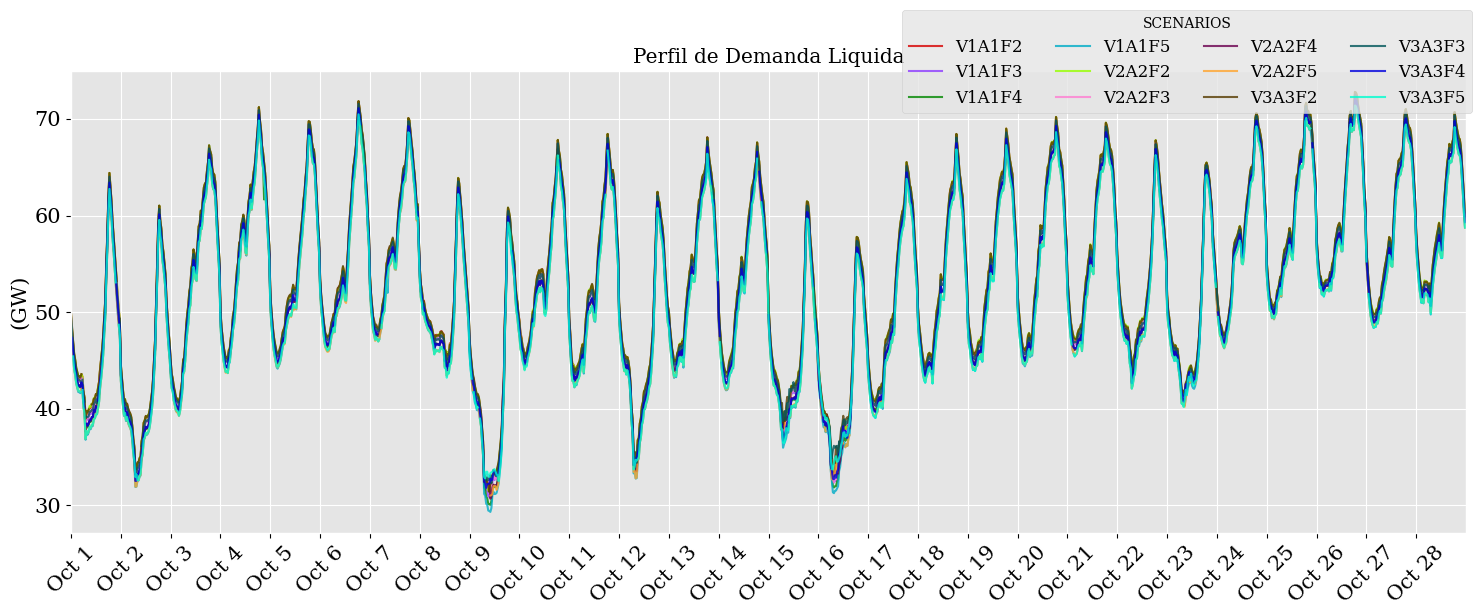

In [16]:
plot_perfil_pot(DF_complete_PO.reset_index(), columna='DL_MW', ylbl='(GW)', titulo= f'Perfil de Demanda Liquida', day=True)

In [17]:
# namescenarios = {'V1A1': ['V1A1', (0.8392156862745098, 0.0, 0.0)],
#  'V2A2': ['V2A2', (0.5490196078431373, 0.23137254901960785, 1.0)],
#  'V3A3': ['V3A3', (0.00392156862745098, 0.5294117647058824, 0.0)],}
# # =======================================Dataframe Mask========================================================
# fechas = [dia for dia in range(1, 29)]
# semihoras_dia = [(datetime(2022, 10, dia, 0, 0) + timedelta(minutes=30*i)).strftime('%d-%H-%M') for dia in fechas for i in range(48)]
# df = pd.DataFrame({'Dia_Hora': semihoras_dia})
# # Dividir la columna Dia_Hora en dos partes y asignarlas a nuevas columnas
# df[['Dia', 'Hora']] = df['Dia_Hora'].str.split('-', n=1, expand=True)
# df['Dia_Hora'] = df['Dia_Hora'].str.replace('-',', ', n=1)
# df['Dia'] = df['Dia'].astype(int)

# df_copias = [df] * len(namescenarios)
# df_mask = pd.concat(df_copias, ignore_index=True)
# df_mask['Dia'] = df_mask['Dia'].astype(int)
# scenarios_column = [scenario  for scenario in namescenarios.keys() for _ in range(1344) ]
# df_mask['Cenario'] = scenarios_column

In [18]:
# dfmvar1 = df_pot_mw_mvar_filt[df_pot_mw_mvar_filt['Cenario'].isin(['V1A1F2','V1A1F3', 'V1A1F4', 'V1A1F5'])].groupby(['Dia','Hora'])[['QG_MVAR']].mean()
# dfmvar1['Cenario'] = 'V1A1'
# dfmvar2 = df_pot_mw_mvar_filt[df_pot_mw_mvar_filt['Cenario'].isin(['V2A2F2','V2A2F3', 'V2A2F4', 'V2A2F5'])].groupby(['Dia','Hora'])[['QG_MVAR']].mean()
# dfmvar2['Cenario'] = 'V2A2'
# dfmvar3 = df_pot_mw_mvar_filt[df_pot_mw_mvar_filt['Cenario'].isin(['V3A3F2','V3A3F3', 'V3A3F4', 'V3A3F5'])].groupby(['Dia','Hora'])[['QG_MVAR']].mean()
# dfmvar3['Cenario'] = 'V3A3'
# dfmvarfinal = pd.concat([dfmvar1, dfmvar2, dfmvar3], axis=0)

In [19]:
# plot_perfil_pot(dfmvarfinal.reset_index(), columna='QG_MVAR', ylbl='(GVAR)', titulo= f'Perfil de MVAR media', day=True)

In [20]:
if Analise_Potencia == True:
    ## Para comparação das diferençãs no reativo gerado entre dois cenários
    # df_pot_mw_mvar_filt = filtarNC(DATA['pot_mw_mvar'],DATA['Index_PO'])
    # a = df_pot_mw_mvar_filt[df_pot_mw_mvar_filt['Cenario']=='V2A2F2 2026 HPPA'][['key','QG_MVAR']]
    # b = df_pot_mw_mvar_filt[df_pot_mw_mvar_filt['Cenario']=='V2A2F2 2026 UNICAMP'][['key','QG_MVAR']]
    # c = a.merge(b, on='key', how='inner')
    # c['delta'] = c['QG_MVAR_x']-c['QG_MVAR_y']
    # display(c.sort_values('delta').head(20))

    #Para obter a media da reserva MW
    df_data = filtarNC(DATA['pot_mw_mvar'], DATA['Index_PO'])
    # df_data = pd.concat(filtarNC(dfs['pot_mw_reserv']), axis=0)
    display('La media es:',df_data[df_data['Cenario'].isin(['V1A1F2 2026','V1A1F3 2026','V1A1F4 2026','V1A1F5 2026'])]['QG_MVAR'].mean())
    display('La media es:',df_data[df_data['Cenario'].isin(['V2A2F2 2026','V2A2F3 2026','V2A2F4 2026','V2A2F5 2026'])]['QG_MVAR'].mean())
    display('La media es:',df_data[df_data['Cenario'].isin(['V3A3F2 2026','V3A3F3 2026','V3A3F4 2026','V3A3F5 2026'])]['QG_MVAR'].mean())

In [21]:
def distribution_plot_reg(df, columna, reg, xlbl, titulo):
    
    plt.figure(figsize=(12, 6))
    for df_ in df:
        dff = df_[df_['REG'] == reg]
        cenario = dff['Cenario'].iloc[0]
        valuegw = dff[columna]/1000
        sns.histplot(valuegw, kde=False, label=namescenarios[cenario][0], color=namescenarios[cenario][1], bins=50, multiple="stack",alpha=0.80, element='step',fill=True, line_kws = {
        "linewidth": 2,  # Example: Make the line thicker
        "linestyle": "--" # Example: Use a dashed line
        })
        plt.axvline(valuegw.mean(), color=namescenarios[cenario][1], linestyle='dashed', linewidth=2)
        print(valuegw.mean())

    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=15)
    plt.ylabel('frequência', fontsize=15)
    plt.tick_params(axis='both', labelsize=15)
    plt.legend(loc='best', fontsize = 15)
    plt.grid()
    plt.show()

regiones = ['Norte', 'Nordeste', 'Sudeste-Centro-Oeste', 'Sul', 'AC-RO']
if Analise_Potencia:
    for reg in regiones:
        df_pot_mw_mvar_reg = filtarNC(DATA['ger_reg'], DATA['Index_PO'])
        plot_perfil_pot(df_pot_mw_mvar_reg.set_index('REG').loc[reg], columna='PG_MW', ylbl='MW', titulo= f'Perfil de Geração {reg}', day=True)


In [22]:
def plot_potencia_perfil(df_resultado, df_data, column, ylim = None, markers=True,):

    df = df_resultado.merge(df_data,on=['Dia','Hora', 'Cenario'], how='left')
    df[column] = df[column]/1000
    plt.figure(figsize=(20, 6))
    sns.lineplot(data=df, x='Dia_Hora', y=column, hue='Cenario', markers=markers, lw = 2)
    plt.xlabel('(Dia, Hora)', fontsize = 15)
    plt.ylabel('(GW)', fontsize = 18)
    plt.title(f'Perfil de Potencia de {column}', fontsize = 15)

    value = int(df['Dia_Hora'].unique().shape[0] / 28)
    selected_ticks = df[df['Cenario'] == df['Cenario'].unique()[0]].iloc[::value]['Dia_Hora']
    plt.xticks(selected_ticks, rotation=45, fontsize=15)
    plt.tick_params(axis='y', labelsize=18)
    plt.legend(title='Cenarios', fontsize = 15)
    if ylim != None:
        plt.ylim(ylim)
    plt.tight_layout()
    plt.show()
if Analise_Potencia:
    plot_potencia_perfil(df_mask, DF_complete_PO, 'DL_MW', markers=False)
    plot_potencia_perfil(df_mask, DF_complete_PO, 'PL_MW', markers=False)

# Analise Tensão

In [23]:
def boxplot_voltage(df, clase, titulo, xlbl, ylbl, ylim=None, vert = False, size = (12,6)):
    # Apply matplotlib styles
    intense_palette = sns.color_palette("ch:start=.2,rot=-.3", n_colors=4)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    plt.style.use("ggplot")

    # Create seaborn boxplot with customizations
    plt.figure(figsize= size)
    if vert:
        ax = sns.boxplot(data=df, x="MODV_PU", y=clase, hue='Clase', width=0.8, gap = 0.15, saturation = 0.75, linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'},legend=False, showfliers = True)
    else:
        ax = sns.boxplot(data=df, x=clase, y="MODV_PU", hue='Clase', width=0.8,  gap = 0.15, saturation = 0.75, linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'},legend=False, showfliers = True)

    # Customize axes spines
    border_color = 'black'
    linewidth = 1.2
    ax.spines['top'].set_color(border_color)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['left'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)

    # Customize the boxplot elements
    for cap in ax.artists:
        cap.set_edgecolor(border_color)
        cap.set_facecolor('white')

    for median in ax.lines:
        median.set_color('darkblue')
        median.set_linewidth(1.5)
    
    plt.ylabel(ylbl, fontsize=16, color ='black')
    plt.title('', fontsize=5)
    plt.xlabel(xlbl, fontsize=16, color ='black')
    # plt.legend(fontsize = 15, loc='upper left')
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')
    # plt.legend(title='Cenário', loc='best', fontsize=15)
    plt.tick_params(axis='x', colors='black',labelsize=15, rotation = 0)  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks
    # Add horizontal lines
    if vert:
        plt.axvline(1.10, color='red', linestyle='--', alpha=0.9)
        plt.axvline(0.90, color='red', linestyle='--', alpha=0.9)
    else:
        plt.axhline(1.10, color='red', linestyle='--', alpha=0.9)
        plt.axhline(0.90, color='red', linestyle='--', alpha=0.9)
    # Set y-axis limits if specified
    if ylim is not None:
        plt.ylim(ylim)
    # Display plot
    plt.savefig(f"Plots/{titulo}.png")
    plt.show()

def boxplot_(df,Variable, clase, titulo, xlbl, ylbl, ylim = None, hue="Cenario", indice = True):

    intense_palette = sns.color_palette("ch:start=.2,rot=-.3", n_colors=4)
    # Apply matplotlib styles
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    plt.style.use("ggplot")
    if indice:
        indexmap = {
            'IndiceInf_s2_PQ': 'PQ Buses', 'IndiceInf_s2_PV': 'PV Buses', 'IndiceSup_s2_PQ': 'PQ Buses',
            'IndiceSup_s2_PV': 'PV Buses',
                    }
        df['variable']  = df['variable'].map(indexmap)
    # Create seaborn boxplot with customizations
    plt.figure(figsize=(15, 8))
    ax = sns.boxplot(data=df, x=clase, y=Variable, hue=hue, width=0.8, gap = 0.15, saturation = 0.75,  linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'})

    # Customize axes spines
    border_color = 'black'
    linewidth = 1.2
    ax.spines['top'].set_color(border_color)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['left'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)

    # Customize the boxplot elements
    for cap in ax.artists:
        cap.set_edgecolor(border_color)
        cap.set_facecolor('white')

    for median in ax.lines:
        median.set_color('darkblue')
        median.set_linewidth(1.5)
    
    # Add titles and labels
    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=20, color ='black')
    plt.ylabel(ylbl, fontsize=20, color ='black')
    plt.tick_params(axis='both', labelsize=20)
    plt.tick_params(axis='both', labelsize=20, labelcolor='black')
    # plt.legend(title='Type of Bus', loc='best', fontsize=16)
    plt.legend(title='SCENARIOS', loc='best', fontsize=16)
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Type of Bus', fontsize=13)
    plt.tick_params(axis='x', colors='black',labelsize=15, rotation = 0)  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks
    
    # Set y-axis limits if specified
    if ylim is not None:
        plt.ylim(ylim)
    plt.savefig(f"Plots/{titulo}.svg")
    # Display plot
    plt.show()

def scatterplot_3(df, v1, v2, xlbl, ylbl, lbl_bar=None, v3=None, xlimites=None, ylimites=None, title=None, vline=False, hline=False, size=100, Chngelbl=False, sizelbl=13, rotation=0, line_plot=True):
    
    if Chngelbl:
        print()
    
    vpi_inf = r'$\mathrm{VPI}^\mathrm{l}$'
    vpi_sup = r'$\mathrm{VPI}^\mathrm{u}$'
    rpi_ind = r'$\mathrm{RPI}^\mathrm{ind}$'
    rpi_cap = r'$\mathrm{RPI}^\mathrm{cap}$'
    
    indexmap = {
        'IndiceInf_s1': vpi_inf, 'IndiceSup_s1': vpi_sup, 'RPI_ind': rpi_ind,
        'RPI_cap': rpi_cap, 'IndiceInf' : vpi_inf, 'IndiceSup' : vpi_sup, 'ReservaIND':rpi_ind, 'ReservaCAP':rpi_cap,
        'ReservaINDshunt':rpi_ind, 'ReservaCAPshunt':rpi_cap
    }
    df['variable'] = df['variable'].map(indexmap)
    
    cmap = plt.cm.get_cmap("rainbow")
    plt.figure(figsize=(10, 6))
    
    # Define custom markers and colors
    markers = {vpi_inf: 'o', vpi_sup: 'o', rpi_ind: '^', rpi_cap: '^'}
    colors = {vpi_inf: 'blue', vpi_sup: 'green', rpi_ind: 'orange', rpi_cap: 'purple'}
    
    if v3 is None:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, s=60, legend=None)
    else:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, hue=v3, style=v3, s=size, palette=colors, markers=markers, legend=True)
    
    # If line_plot is True, add a line plot
    if line_plot:
        # Sort the data by v1
        df_sorted = df
        if v3 is None:
            plt.plot(df_sorted[v1], df_sorted[v2], color='black', linestyle='-', linewidth=1)
        else:
            # If hue is used, plot a line for each group
            for key, grp in df_sorted.groupby(v3):
                plt.plot(grp[v1], grp[v2], linestyle='--', linewidth=1, color=colors.get(key, 'black'))
    
    # Set legend with custom markers and colors
    handles, labels = scatter.get_legend_handles_labels()
    new_labels = []
    new_handles = []
    for handle, label in zip(handles, labels):
        if label in markers:
            new_handles.append(plt.Line2D([], [], marker=markers[label], color=colors[label], linestyle='None', markersize=10))
            new_labels.append(label)
    
    border_color = 'black'
    linewidth = 1.2
    scatter.spines['top'].set_color(border_color)
    scatter.spines['bottom'].set_color(border_color)
    scatter.spines['left'].set_color(border_color)
    scatter.spines['right'].set_color(border_color)
    scatter.spines['top'].set_linewidth(linewidth)
    scatter.spines['bottom'].set_linewidth(linewidth)
    scatter.spines['left'].set_linewidth(linewidth)
    scatter.spines['right'].set_linewidth(linewidth)

    plt.legend(new_handles, new_labels, loc='upper left', bbox_to_anchor=(1, 1), title='Indices', fontsize=13)
    plt.title(title, fontsize=15)
    plt.xlabel(xlbl, fontsize=17, color='black')
    plt.ylabel(ylbl, fontsize=17, color='black')
    if hline:
        plt.axhline(1, color='red', linestyle='--', alpha=0.9)
    if vline:
        plt.axvline(1, color='red', linestyle='--', alpha=0.9)
        
    # Adjust x-axis tick labels position
    ax = plt.gca()
    for tick in ax.get_xticklabels():
        tick.set_horizontalalignment('right')
    
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')
    plt.tick_params(axis='x', colors='black', labelsize=sizelbl, rotation=rotation)
    plt.tick_params(axis='y', colors='black')
    
    if xlimites is not None:
        plt.xlim(xlimites)
    if ylimites is not None:
        plt.ylim(ylimites)
        
    plt.show()

def plot_line(df_data, column, xlbl, ylbl, title, pathsave=None, clase=None, xlimites=None, ylimites=None, order=False, byClass=False, month=False):
    intense_palette = sns.color_palette(cc.glasbey, n_colors=20)
    fig, axs = plt.subplots(1, 1, figsize=(18, 8), sharex=False)

    if byClass:
        for idx, clase in enumerate(df_data.index.get_level_values(clase).unique().values):
            if order:
                data = df_data.loc[:, :, clase].sort_values(column, ascending=False)
                # Handle NaN by filling with placeholder or skipping NaN entries
                vbasekv_value = data['Nome da Area'].values[0]  # Replace NaN with 'N/A'
                axs.plot(data[column].values, color=intense_palette[idx], label=f"{clase} ({vbasekv_value})", lw=2.5, linestyle='-', alpha=1)
                
                num = data.shape[0]
                data_points_xaxis = 10
                num_days = num * data_points_xaxis / 100
                axs.set_xticks([round(i * num_days) for i in range(data_points_xaxis + 1)])
                axs.set_xticklabels([f'{i * 10}' for i in range(data_points_xaxis + 1)], fontsize=12, rotation=0, ha='center')
            else:
                data = df_data.loc[:, :, clase]
                vbasekv_value = data['Nome da Area'].values[0]  # Replace NaN with 'N/A'
                axs.plot(data['key'], data[column], color=intense_palette[idx], label=f"{clase} ({vbasekv_value})", lw=2.5, linestyle='-', alpha=1)
                axs.xaxis.set_major_locator(plt.MaxNLocator(28))
            axs.legend(loc='upper right', fontsize=18)
    else:
        if order:
            data = df_data.sort_values(column, ascending=False)
            vbasekv_value = data['VBASEKV'].fillna('N/A').values[0]  # Replace NaN with 'N/A'
            axs.plot(data[column].values, color=intense_palette[0], label=f"Data ({vbasekv_value})", lw=2.5, linestyle='-', alpha=1)
            
            num = data.shape[0]
            data_points_xaxis = 10
            num_days = num * data_points_xaxis / 100
            axs.set_xticks([round(i * num_days) for i in range(data_points_xaxis + 1)])
            axs.set_xticklabels([f'{i * 10}' for i in range(data_points_xaxis + 1)], fontsize=12, rotation=0, ha='center')
        else:
            axs.plot(df_data['key'], df_data[column], color=intense_palette[0], lw=2.5, linestyle='-', alpha=1)
            for i, txt in enumerate(df_data["VBASEKV"].values):
                axs.annotate(f'{txt}', (df_data['key'].values[i], df_data[column].values[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)
            axs.xaxis.set_major_locator(plt.MaxNLocator(28))

    border_color = 'black'
    linewidth = 1.2
    axs.spines['top'].set_color(border_color)
    axs.spines['bottom'].set_color(border_color)
    axs.spines['left'].set_color(border_color)
    axs.spines['right'].set_color(border_color)
    axs.spines['top'].set_linewidth(linewidth)
    axs.spines['bottom'].set_linewidth(linewidth)
    axs.spines['left'].set_linewidth(linewidth)
    axs.spines['right'].set_linewidth(linewidth)

    axs.tick_params(axis='y', labelsize=24)
    axs.tick_params(axis='x', labelsize=25, rotation=45)
    axs.set_xlabel(xlbl, fontsize=24, color ='black')
    axs.set_ylabel(ylbl, fontsize=22, color ='black')
    axs.set_title(title, fontsize=22, color ='black')
    axs.tick_params(axis='x', colors='black',labelsize=24, rotation = 0)  # Set the color for the x-axis ticks
    axs.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks

    if month:
        days = ['Oct {}'.format(i + 1) for i in range(28)]
        plt.xticks(ticks=[i * 48 for i in range(28)], labels=days, rotation=45)
        plt.xlabel('', fontsize=10)

    if xlimites is not None:
        axs.set_xlim(xlimites)
    if ylimites is not None:
        axs.set_ylim(ylimites)

    axs.grid(True, linestyle='-', linewidth=1.2, alpha=0.4)
    plt.tight_layout()
    plt.show()

In [24]:
# Define the file path
file_path = 'areainfo_anarede.txt'

# Read the file, skipping the first line
with open(file_path, 'r', encoding='utf-8') as file:
    # Skip the first line
    file.readline()
    # Read the second line for column names, but we will define custom names
    column_names = ["ARE", "Xchg", "Estado", "Nome da Area"]
    # Read the remaining lines for data
    data = [line.strip() for line in file]

# Clean and split the data into columns, focusing on four columns
cleaned_data = []
for line in data[1:]:
    # Remove parentheses and extra spaces, split into exactly four columns
    columns = line.replace('(', '').replace(')', '').split(maxsplit=3)
    # Ensure we have exactly four columns, filling with an empty string if necessary
    if len(columns) == 3:
        columns.append('')  # Add empty string for missing "Nome da Area"
    cleaned_data.append(columns[:4])  # Limit to four columns

# Create a DataFrame with the revised column names
df_area = pd.DataFrame(cleaned_data, columns=column_names)
# Remove the leading '- ' from the "Nome da Area" column
df_area['Nome da Area'] = df_area['Nome da Area'].str.lstrip('- ')
df_area['ARE'] = df_area['ARE'].astype('Int32')

In [25]:
GB = 'ARE'
# Optimized norm function without lambda
def norm(x):
    n = 1
    return np.linalg.norm(x, ord=2*n)
    # return np.linalg.norm(x, ord=np.inf)

def weightedsum_PQ(x, y, z, NT):
    n = 1
    mean_z = np.mean(z)
    value = y/mean_z if mean_z != 0 else 0
    # return np.sum(x * value)
    return np.linalg.norm(x* value, ord=2*n)

def weightedsum_PV(x, y, z):
    n = 1
    mean_z = np.mean(z)
    value = y/mean_z if mean_z != 0 else 0
    # return np.sum(x * value)
    return np.linalg.norm(x* value, ord=2*n)

def concatenatedfs(data, numNB):
    df_merged = pd.merge(data, numNB, on=['key', 'Dia', 'Hora', 'Cenario', 'REG', GB], how='left')
    df_merged.fillna(0, inplace=True)
    return df_merged

def computeDPI():
    df_PQ, df_PV, df_PQ_area, df_PV_area = None, None, None, None

    for key in ['PQ Buses', 'PV Buses']:
        df = DATA['nt'].copy() if key == 'PQ Buses' else DATA['ger'].copy()

        # # More efficient renaming using map
        # df['REG'] = df['REG'].map(regionmap)
        
        group_cols1 = ['key', 'Dia', 'Hora', 'Cenario', 'REG', GB]
        group_cols2 = ['key', 'Dia', 'Hora', 'Cenario', 'REG']

        # Optimized groupby using vectorized operations
        num_NB = df.groupby(group_cols1)['BUS_ID'].count().reset_index(name='num_NB')
        num_NB_nonzeros_inf = df[df['IndiceInf'] > 0].groupby(group_cols1)['BUS_ID'].count().reset_index(name='num_NB_inf')
        num_NB_nonzeros_sup = df[df['IndiceSup'] > 0].groupby(group_cols1)['BUS_ID'].count().reset_index(name='num_NB_sup')
        num_NR = df.groupby(group_cols2)['BUS_ID'].count().reset_index(name='num_NR')

        df_merged_NB = pd.merge(num_NB, num_NB_nonzeros_inf, on=group_cols1, how='outer')
        df_merged_NB = pd.merge(df_merged_NB, num_NB_nonzeros_sup, on=group_cols1, how='outer')
        df_merged = pd.merge(df_merged_NB, num_NR, on=group_cols2, how='left')

        if key == 'PQ Buses':
            df_PQ = df.groupby(group_cols1).agg(
                IndiceInf_s1=('IndiceInf', norm),
                IndiceSup_s1=('IndiceSup', norm),
                VBASEKV=('VBASEKV', 'first'),
            ).reset_index()

            df_PQ = concatenatedfs(df_PQ, df_merged)

            df_PQ_area = df_PQ.groupby(group_cols2).apply(
                lambda df: pd.Series({
                    'IndiceInf_s2': weightedsum_PQ(df['IndiceInf_s1'], df['num_NB_inf'], df['num_NR'], df['VBASEKV']),
                    'IndiceSup_s2': weightedsum_PQ(df['IndiceSup_s1'], df['num_NB_sup'], df['num_NR'], df['VBASEKV'])
                })
            ).reset_index()

        elif key == 'PV Buses':
            df_PV = df.groupby(group_cols1).agg(
                IndiceInf_s1=('IndiceInf', norm),
                IndiceSup_s1=('IndiceSup', norm)
            ).reset_index()

            df_PV = concatenatedfs(df_PV, df_merged)

            df_PV_area = df_PV.groupby(group_cols2).apply(
                lambda df: pd.Series({
                    'IndiceInf_s2': weightedsum_PV(df['IndiceInf_s1'], df['num_NB_inf'], df['num_NR']),
                    'IndiceSup_s2': weightedsum_PV(df['IndiceSup_s1'], df['num_NB_sup'], df['num_NR'])
                })
            ).reset_index()

    return df_PQ, df_PV, df_PQ_area, df_PV_area

if Analise_INDICE:
    df_PQ, df_PV, df_PQ_area, df_PV_area = computeDPI()


    df_Index_s3 = pd.concat([df_PV_area,df_PQ_area], axis=0)
    df_Index_DPI_s3 = df_Index_s3.groupby(['key','Dia','Hora','Cenario']).agg(
        IndiceInf_s3 = ('IndiceInf_s2', lambda x: norm(x)),
        IndiceSup_s3 = ('IndiceSup_s2', lambda x: norm(x)),
    ).reset_index()


    # df_PV_DPI_s3 = df_PV_area.groupby(['key','Dia','Hora','Cenario']).agg(
    #     IndiceInf_s3_PV = ('IndiceInf_s2_PV', lambda x: norm(x)),
    #     IndiceSup_s3_PV = ('IndiceSup_s2_PV', lambda x: norm(x)),
    # ).reset_index()
    # df_PQ_DPI_s3 = df_PQ_area.groupby(['key','Dia','Hora','Cenario']).agg(
    #     IndiceInf_s3_PQ = ('IndiceInf_s2_PQ', lambda x: norm(x)),
    #     IndiceSup_s3_PQ = ('IndiceSup_s2_PQ', lambda x: norm(x)),
    # ).reset_index()
    # df_Index_DPI_s3 = df_PV_DPI_s3.merge(df_PQ_DPI_s3, on = ['key', 'Dia', 'Hora', 'Cenario'], how='left').set_index(['key','Dia','Hora','Cenario'])

    df_PV_area.rename(columns={'IndiceInf_s2':'IndiceInf_s2_PV','IndiceSup_s2':'IndiceSup_s2_PV'}, inplace=True)
    df_PQ_area.rename(columns={'IndiceInf_s2':'IndiceInf_s2_PQ','IndiceSup_s2':'IndiceSup_s2_PQ'}, inplace=True)
    df_Index_DPI_s2 = df_PV_area.merge(df_PQ_area, on = ['key', 'Dia', 'Hora', 'Cenario', 'REG'], how='left').set_index(['key','Dia','Hora','Cenario'])
    df_Index_DPI_s3 = df_Index_DPI_s3.set_index(['key','Dia','Hora','Cenario'])

C:\Users\david\AppData\Local\Temp\ipykernel_34272\2547021604.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_PQ_area = df_PQ.groupby(group_cols2).apply(
C:\Users\david\AppData\Local\Temp\ipykernel_34272\2547021604.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_PV_area = df_PV.groupby(group_cols2).apply(


In [26]:
GB = 'ARE'
def norm(x):
    n=1
    return np.linalg.norm(x, ord=2*n)

def indice_reativo (df, tg):
    if tg == 'Gen_Type':
        df1 = df.groupby(['key', 'Dia', 'Hora', 'Cenario', 'REG', GB]).agg(
            RPI_ind = ('ReservaIND', lambda x: norm(x)),
            RPI_cap = ('ReservaCAP', lambda x: norm(x)),
        ).reset_index()
    else:
        df1 = df.groupby(['key', 'Dia', 'Hora', 'Cenario', 'REG', GB]).agg(
            RPI_ind = ('ReservaINDshunt', lambda x: norm(x)),
            RPI_cap = ('ReservaCAPshunt', lambda x: norm(x)),
        ).reset_index()
    return df1

if Analise_INDICE:

    df_RPI_PV = indice_reativo(DATA['ger'],'Gen_Type')
    df_RPI_PQ = indice_reativo(DATA['nt'],'VBASEKV')

## Analise Indice

### Filtragem cluster

In [27]:
FiltCluster = False

In [28]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def reduce_dimensionality(data: pd.DataFrame, method: str = 'tsne', perplexity: float = 30, n_components: int = 2):
    """
    Reduce dimensionality of the data using TSNE or PCA.
    
    Parameters:
        data (pd.DataFrame): DataFrame with features.
        method (str): Dimensionality reduction method ('tsne' or 'pca').
        perplexity (float): Perplexity parameter for t-SNE (only relevant if method='tsne').
        n_components (int): Number of dimensions to reduce to (default is 2 for visualization).
    
    Returns:
        np.ndarray: Transformed 2D data for visualization.
    """
    if data.shape[1]>2:
    
        if method == 'tsne':
            tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
            return tsne.fit_transform(data)
        elif method == 'pca':
            pca = PCA(n_components=n_components)
            return pca.fit_transform(data)
        else:
            raise ValueError("Method must be either 'tsne' or 'pca'.")
    else:
        return data.values
    
def detect_outliers_dbscan(data: pd.DataFrame, dbscan_eps: float = 0.05, dbscan_min_samples: int = 10):
    """
    Perform DBSCAN-based outlier detection.
    
    Parameters:
        data (pd.DataFrame): DataFrame with features (each column is a feature).
        dbscan_eps (float): DBSCAN epsilon (maximum distance between points for clustering).
        dbscan_min_samples (int): DBSCAN min_samples (minimum number of points to form a cluster).
    
    Returns:
        pd.Series: Boolean series where True indicates an outlier, False indicates inlier.
    """
    dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
    dbscan_labels = dbscan.fit_predict(data)
    return (dbscan_labels == -1)  # Outliers are labeled as -1

def detect_outliers_knn(data: pd.DataFrame, knn_neighbors: int = 5, contamination: float = 0.05):
    """
    Perform KNN-based outlier detection.
    
    Parameters:
        data (pd.DataFrame): DataFrame with features (each column is a feature).
        knn_neighbors (int): Number of neighbors for KNN.
        contamination (float): Proportion of points to be considered outliers.
    
    Returns:
        pd.Series: Boolean series where True indicates an outlier, False indicates inlier.
    """
    knn = NearestNeighbors(n_neighbors=knn_neighbors)
    knn.fit(data)
    distances, _ = knn.kneighbors(data)
    mean_distances = np.mean(distances, axis=1)
    
    # Set threshold based on contamination level
    threshold = np.percentile(mean_distances, 100 * (1 - contamination))
    return (mean_distances > threshold)  # Points with large mean distance are outliers

def plot_outliers(data_2d: np.ndarray, outliers: pd.Series, title: str):
    """
    Visualize normal data and outliers in a 2D scatter plot.
    
    Parameters:
        data_2d (np.ndarray): 2D array with reduced features (2 components).
        outliers (pd.Series): Boolean series where True indicates an outlier, False indicates inlier.
        title (str): Title for the plot.
    
    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    
    # Plot normal data
    plt.scatter(data_2d[~outliers, 0], data_2d[~outliers, 1], color='blue', label='Normal Data', s=50)
    
    # Plot outliers
    plt.scatter(data_2d[outliers, 0], data_2d[outliers, 1], color='red', label='Outliers', s=50, marker='x')
    
    # Plot formatting
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    # plt.xlim([-0.1,4])
    # plt.ylim([-0.1,4])
    plt.legend()
    plt.show()


In [29]:
def filtrarDBSCAN (data, dbscan_eps=0.06, dbscan_min_samples=5):
    # cenario = 'all'
    # region = 'all'
    # df_Index_DPI_s2_flatted = flatdataframe(df_Index_DPI_s2.reset_index().set_index(['Dia','Hora','REG','Cenario']), cenario, region, ['IndiceInf_s2_PV', 'IndiceSup_s2_PV','IndiceInf_s2_PQ', 'IndiceSup_s2_PQ'])
    selected_oulierdata = data

    # # 1. Reduce dimensionality using t-SNE (can switch to 'pca' for PCA-based reduction)
    # data_2d_tsne = reduce_dimensionality(df_Index_DPI_s3, method='tsne', perplexity=30)
    # 2. Reduce dimensionality using PCA
    data_2d_pca = reduce_dimensionality(selected_oulierdata, method='pca')

    # Example usage
    # 3. DBSCAN-based outlier detection
    dbscan_outliers = detect_outliers_dbscan(selected_oulierdata, dbscan_eps=dbscan_eps, dbscan_min_samples=dbscan_min_samples)
    # # 4. KNN-based outlier detection
    # knn_outliers = detect_outliers_knn(df_Index_DPI_s3, knn_neighbors=5, contamination=0.05)

    # 5. Visualize DBSCAN outliers with t-SNE
    # plot_outliers(data_2d_tsne, dbscan_outliers, title='DBSCAN Outliers Detection (t-SNE)')
    # plot_outliers(data_2d_tsne, knn_outliers, title='KNN Outliers Detection (t-SNE)')
    # 6. Visualize KNN outliers with PCA
    plot_outliers(data_2d_pca, dbscan_outliers, title='DBSCAN Outliers Detection (PCA)')
    # plot_outliers(data_2d_pca, knn_outliers, title='KNN Outliers Detection (PCA)')

    mask_inseguros = selected_oulierdata[~dbscan_outliers].reset_index()
    print('O casos normais são:', mask_inseguros.shape)
    mask_inseguros = selected_oulierdata[dbscan_outliers].reset_index()
    print('O casos anomalos são:', mask_inseguros.shape)

    return dbscan_outliers

### Filtragem Normal

In [30]:
outliers =list( set(df_complete[(df_complete['MODV_PU']<0.8) | (df_complete['MODV_PU']>1.2)][['key', 'Cenario']].apply(tuple, axis=1).values))
filtro = df_complete[['key', 'Cenario']].apply(tuple, axis=1).isin(outliers).values
df_complete_filt = df_complete[~filtro]

filtro = DATA['nt'][['key', 'Cenario']].apply(tuple, axis=1).isin(outliers).values
df_filt_nt = DATA['nt'][~filtro]

filtro = DATA['ger'][['key', 'Cenario']].apply(tuple, axis=1).isin(outliers).values
df_filt_ger = DATA['ger'][~filtro]

insecure_indices_po = df_Index_DPI_s3.index.to_frame()[['key', 'Cenario']].apply(tuple, axis=1).isin(outliers).values


### Concatenacion toda a data por O.P

In [31]:
if Analise_alldata:
    
    cenario = 'all'
    region = 'all'
    columns2 = ['PL_MW','PG_MW','QL_MVAR','QG_MVAR','PG_UHE', 'PG_UTE', 'PG_EOL', 'PG_SOL', 'Mvar:Losses_500down','Mvar:Losses_500up','% L1_500up','% L1_500down','Shunt_Ind', 'Shunt_Cap','key','ReservaIND', 'ReservaCAP']

    # insecure_indices = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] > 1).any(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values
    insecure_indices = df_Index_DPI_s3.loc[~dbscan_outliers].index.to_frame()[['key', 'Cenario']].apply(tuple, axis=1).values

    # insecure_indices = DF_complete_PO.loc[(DF_complete_PO[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] > 0.2).any(axis=1)]
    # insecure_indices = insecure_indices.loc[(insecure_indices[['PV_lower', 'PV_upper', 'PQ_lower', 'PQ_upper']] <= 1).all(axis=1)].index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).values

    filtro = Df_data_completo_reg.index.to_frame()[['Dia', 'Hora', 'Cenario']].apply(tuple, axis=1).isin(insecure_indices)
    dfanalise = Df_data_completo_reg[filtro]
    dfanalise = flatdataframe(dfanalise, cenario, region, columns2, ACDCflux=True, Reserva=True, DPI=True, IndiceGroup=False, InfoPO=True, PImva_reg_nt=False, PImva=False, Busfeatures=False,Vanalysis='OV', Linefeatures=False, Q_indice=False)
    dfanalise.shape

### Plots Tensão 1

C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:13: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.boxplot(data=df, x=clase, y="MODV_PU", hue='Clase', width=0.8,  gap = 0.15, saturation = 0.75, linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'},legend=False, showfliers = True)


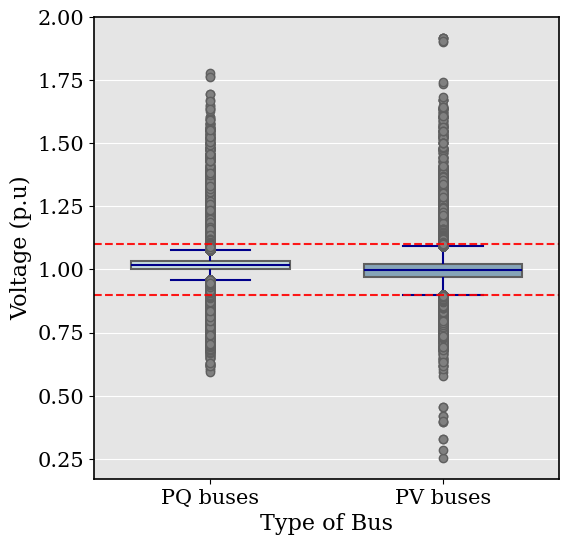

C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:13: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.boxplot(data=df, x=clase, y="MODV_PU", hue='Clase', width=0.8,  gap = 0.15, saturation = 0.75, linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'},legend=False, showfliers = True)


In [32]:
if Analise_INDICE:
    boxplot_voltage(df_complete, clase = "Clase", titulo = 'Voltage Bus-bar Distribution', xlbl = 'Type of Bus', ylbl='Voltage (p.u)', vert=False, size = (6,6))
    # boxplot_voltage(df_complete_filt, clase = "REG", titulo = 'Voltage Bus-bar Distribution by Area', xlbl = 'Area', ylbl='Voltage (p.u)')
    boxplot_voltage(df_complete_filt, clase = "Clase", titulo = 'Voltage Bus-bar Distribution Filtrado', xlbl = 'Type of Bus', ylbl='Voltage (p.u)', vert=False, size = (6,6))

In [33]:
mask_inseguros = df_Index_DPI_s3[~insecure_indices_po].reset_index()
print('O casos normais são:', mask_inseguros.shape)

mask_inseguros = df_Index_DPI_s3[insecure_indices_po].reset_index()
print('O casos anomalos são:', mask_inseguros.shape)

O casos normais são: (15723, 6)
O casos anomalos são: (265, 6)


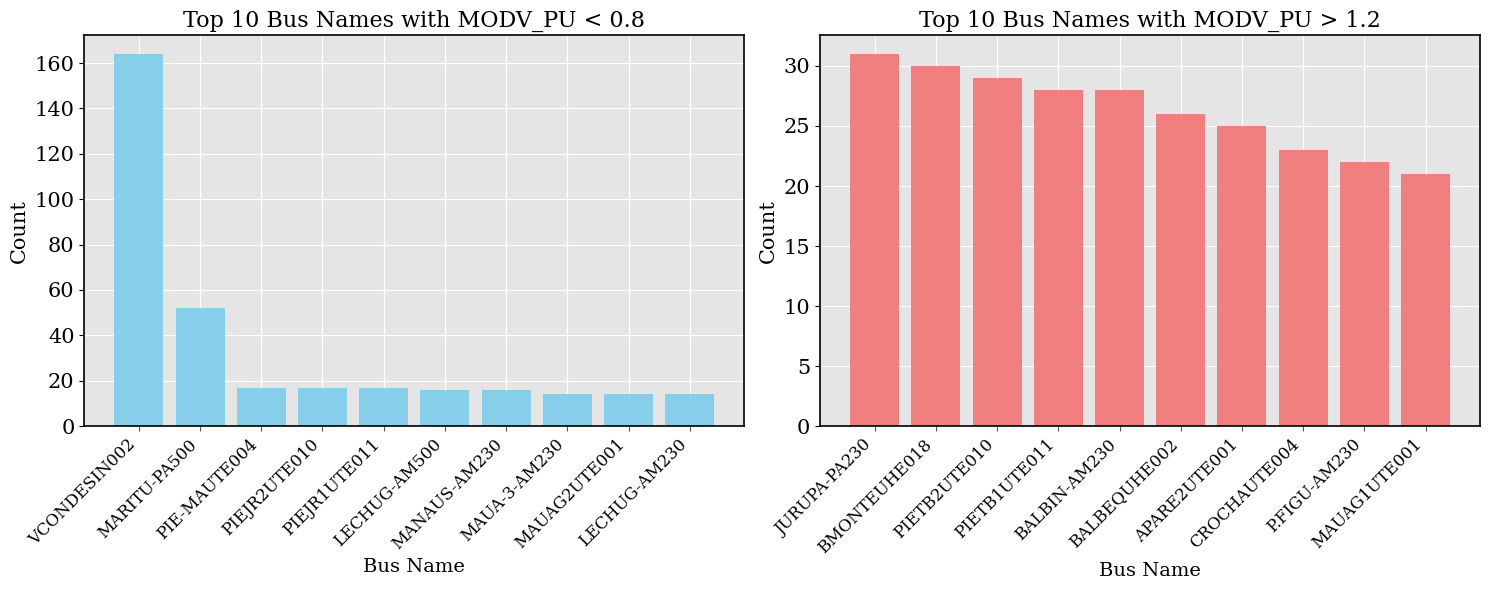

In [34]:
# Get the counts
bus_counts_lower = df_complete[df_complete['MODV_PU'] < 0.8].value_counts('BUS_NAME').sort_values(ascending=False)
bus_counts_upper = df_complete[df_complete['MODV_PU'] > 1.2].value_counts('BUS_NAME').sort_values(ascending=False)

# Select the first 10 elements for each
top_10_bus_counts_l = bus_counts_lower[:10]
top_10_bus_counts_u = bus_counts_upper[:10]

# Create indices for the bars
indices_l = np.arange(len(top_10_bus_counts_l))
indices_u = np.arange(len(top_10_bus_counts_u))

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot lower bus counts in the left subplot
ax[0].bar(indices_l, top_10_bus_counts_l, color='skyblue')
ax[0].set_title('Top 10 Bus Names with MODV_PU < 0.8', fontsize=16)
ax[0].set_xlabel('Bus Name', fontsize=14,color ='black')
ax[0].set_ylabel('Count', fontsize=15, color ='black')
ax[0].set_xticks(indices_l)
ax[0].set_xticklabels(top_10_bus_counts_l.index, rotation=45, ha='right', fontsize=12, color ='black')
ax[0].tick_params(axis='y', colors='black',labelsize=15, rotation = 0)

# Plot upper bus counts in the right subplot
ax[1].bar(indices_u, top_10_bus_counts_u, color='lightcoral')
ax[1].set_title('Top 10 Bus Names with MODV_PU > 1.2', fontsize=16)
ax[1].set_xlabel('Bus Name', fontsize=14, color ='black')
ax[1].set_ylabel('Count', fontsize=15, color ='black')
ax[1].set_xticks(indices_u)
ax[1].set_xticklabels(top_10_bus_counts_u.index, rotation=45, ha='right', fontsize=12, color ='black')
ax[1].tick_params(axis='y', colors='black',labelsize=15, rotation = 0)
# Adjust layout to avoid overlap

# Customize axes spines
border_color = 'black'
linewidth = 1.2
ax[0].spines['top'].set_color(border_color)
ax[0].spines['bottom'].set_color(border_color)
ax[0].spines['left'].set_color(border_color)
ax[0].spines['right'].set_color(border_color)
ax[0].spines['top'].set_linewidth(linewidth)
ax[0].spines['bottom'].set_linewidth(linewidth)
ax[0].spines['left'].set_linewidth(linewidth)
ax[0].spines['right'].set_linewidth(linewidth)

ax[1].spines['top'].set_color(border_color)
ax[1].spines['bottom'].set_color(border_color)
ax[1].spines['left'].set_color(border_color)
ax[1].spines['right'].set_color(border_color)
ax[1].spines['top'].set_linewidth(linewidth)
ax[1].spines['bottom'].set_linewidth(linewidth)
ax[1].spines['left'].set_linewidth(linewidth)
ax[1].spines['right'].set_linewidth(linewidth)

plt.tight_layout()
plt.savefig('Plots/barplot.svg')
plt.show()


### Otros Analises relacionados

In [35]:
df_complete[df_complete['BUS_NAME']==''][['BUS_NAME','REG']]

Empty DataFrame
Columns: [BUS_NAME, REG]
Index: []

In [36]:
df_complete[df_complete['MODV_PU'] < 0.8].value_counts('REG').sort_values(ascending=False)

REG
North    576
AC-RO     34
SE-CW      4
Name: count, dtype: int64

In [37]:

df_complete[df_complete['MODV_PU'] > 1.2].value_counts('REG').sort_values(ascending=False)

REG
North        1352
AC-RO          98
SE-CW          23
Northeast      13
Name: count, dtype: int64

In [38]:
df_complete[df_complete['MODV_PU']>1.2].value_counts('BUS_NAME')

BUS_NAME
JURUPA-PA230    31
BMONTEUHE018    30
PIETB2UTE010    29
PIETB1UTE011    28
BALBIN-AM230    28
                ..
MIRACE-TO500     1
S.MESA-GO500     1
FOZCE-PCH013     1
ROND2-UTE000     1
ITAREM-CE230     1
Name: count, Length: 211, dtype: int64

In [39]:
df_complete_filt[df_complete_filt['MODV_PU']<0.85].value_counts('BUS_NAME')

BUS_NAME
VCONDESIN002    110
MARITU-PA500     54
TAPAJOSIN001     23
FGOMESUHE001     17
RUROP-SIN001     15
ESTREIUHE008      6
ROND2-UHE003      6
PBUEN2PCH138      5
ROND2-UTE000      5
SA.J.VUHE000      4
SA.JARUHE001      4
CONFR-SIN001      4
ARIQU-SIN001      4
TA.PMG-PA230      4
SUZAN-UTE002      4
STA.MA-PA230      4
TOME-A-PA230      4
JIPAR-SIN001      4
VC.PMG-PA230      4
VC.ALB-PA230      3
V.COND-PA230      2
T.N2-VUTE000      2
VC.ALU-PA230      2
T.N2-GUTE000      2
BURITIPCH013      2
CURUA-PCH013      2
MARABASIN001      2
ITACAI-PA230      2
3MAIO-PCH013      2
SAMU1-UHE005      1
CALDEIUHE001      1
R.BRAN-AC230      1
PIEJR2UTE010      1
CASTAN-PA230      1
MACAPA-AP230      1
CNUNE1UHE001      1
Name: count, dtype: int64

In [40]:
def scatterplot_1(df, v1, v2, xlbl, ylbl, lbl_bar = None , v3 = None, xlimites = None, ylimites = None, title = None, vline = False, hline = False, show_outliers = False):

    cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap

    plt.figure(figsize=(10, 6))
    if v3 == None:
        if show_outliers == False:
            scatter = sns.scatterplot(data=df, x=v1, y=v2, s=60, legend=None)
        if show_outliers:
            scatter = sns.scatterplot(data=df[~insecure_indices_po], x=v1, y=v2, s=60, legend=None)
            scatter = sns.scatterplot(data=df[insecure_indices_po], x=v1, y=v2, s=60, color = 'black', legend=None)
    else:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, palette=cmap, hue=v3, s=60, legend=None)
        norm = mcolors.Normalize(vmin=df[v3].min(), vmax=df[v3].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', label= lbl_bar,)
        # Set color bar tick labels to black
        cbar.ax.yaxis.set_tick_params(color='black',labelsize=12)
        plt.setp(cbar.ax.get_yticklabels(), color='black')
        # Set the color and size of the color bar legend label
        cbar.set_label(lbl_bar, fontsize=15, color='black')

    # plt.grid(True, which="both", linestyle='--', linewidth=0.5)

    border_color = 'black'
    linewidth = 1.2
    scatter.spines['top'].set_color(border_color)
    scatter.spines['bottom'].set_color(border_color)
    scatter.spines['left'].set_color(border_color)
    scatter.spines['right'].set_color(border_color)
    scatter.spines['top'].set_linewidth(linewidth)
    scatter.spines['bottom'].set_linewidth(linewidth)
    scatter.spines['left'].set_linewidth(linewidth)
    scatter.spines['right'].set_linewidth(linewidth)

    nometitulo = title
    plt.title(nometitulo, fontsize = 15)
    plt.xlabel(xlbl, fontsize = 17, color ='black')
    plt.legend(fontsize = 15, loc='upper left')
    plt.ylabel(ylbl, fontsize = 17, color ='black')
    if hline:
        plt.axhline(1, color='red', linestyle='--', alpha=0.9)
    if vline:
        plt.axvline(1, color='red', linestyle='--', alpha=0.9)
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')
    plt.tick_params(axis='x', colors='black',labelsize=15, rotation = 0)  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks
    if xlimites != None:
        plt.xlim(xlimites)
    if ylimites != None:
        plt.ylim(ylimites)

    plt.savefig(f"Plots/{title}.svg")
    plt.show()
    correlation = df[v1].corr(df[v2])
    print(f"Indice de Correlación: {correlation}")

C:\Users\david\AppData\Local\Temp\ipykernel_34272\3132426074.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


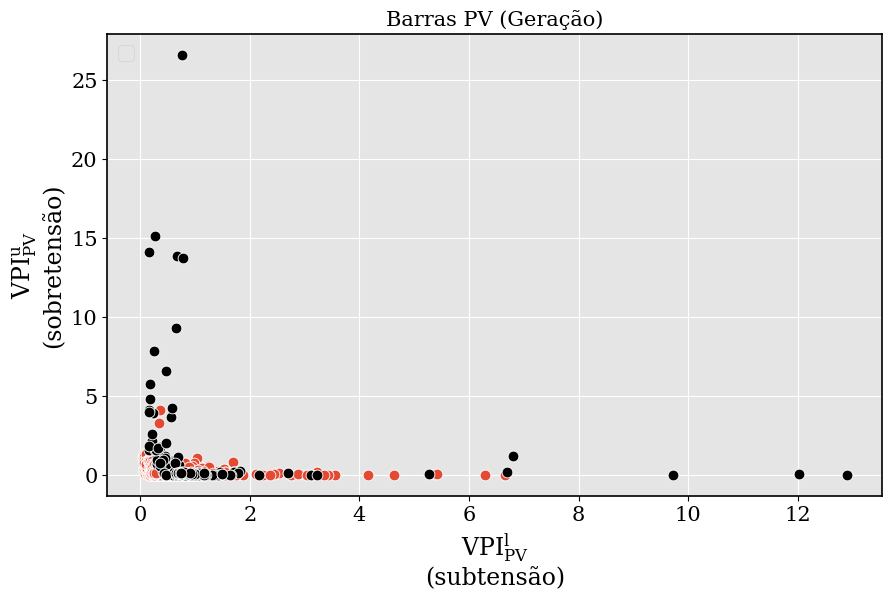

C:\Users\david\AppData\Local\Temp\ipykernel_34272\3132426074.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Indice de Correlación: -0.14012152660132488


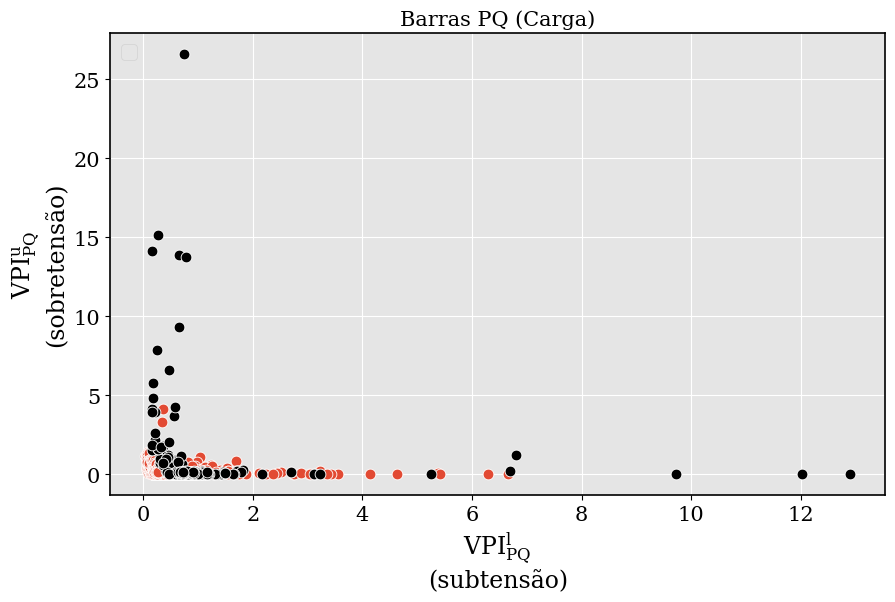

C:\Users\david\AppData\Local\Temp\ipykernel_34272\3132426074.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Indice de Correlación: -0.14012152660132488


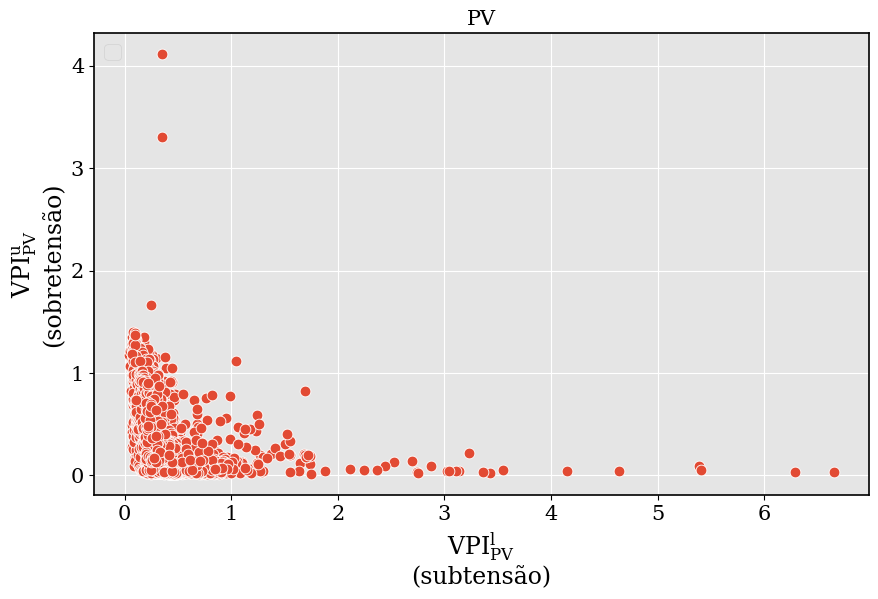

C:\Users\david\AppData\Local\Temp\ipykernel_34272\3132426074.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Indice de Correlación: -0.34570645121157073


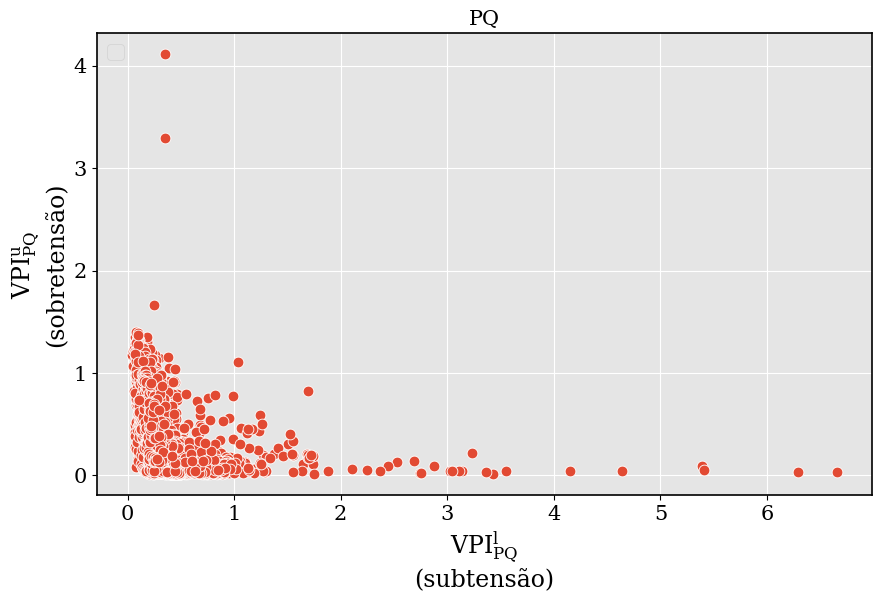

Indice de Correlación: -0.34570645121157073


In [41]:
vpi_inf_pq = r'$\mathrm{VPI}_\mathrm{PQ}^\mathrm{l}$'
vpi_sup_pq = r'$\mathrm{VPI}_\mathrm{PQ}^\mathrm{u}$'
vpi_inf_pv = r'$\mathrm{VPI}_\mathrm{PV}^\mathrm{l}$'
vpi_sup_pv = r'$\mathrm{VPI}_\mathrm{PV}^\mathrm{u}$'

if Analise_INDICE:
    scatterplot_1(df_Index_DPI_s3, 'IndiceInf_s3', 'IndiceSup_s3', xlbl= f'{vpi_inf_pv}\n(subtensão)', ylbl = f'{vpi_sup_pv}\n(sobretensão)',lbl_bar= 'Demanda Liquida (MW)', vline=False, hline=False , title='Barras PV (Geração)', show_outliers=True)
    scatterplot_1(df_Index_DPI_s3, 'IndiceInf_s3', 'IndiceSup_s3', xlbl= f'{vpi_inf_pq}\n(subtensão)', ylbl = f'{vpi_sup_pq}\n(sobretensão)',lbl_bar= 'FERV (%)', vline=False, hline=False , title='Barras PQ (Carga)', show_outliers=True)

    scatterplot_1(df_Index_DPI_s3[~insecure_indices_po], 'IndiceInf_s3', 'IndiceSup_s3', xlbl=f'{vpi_inf_pv}\n(subtensão)', ylbl = f'{vpi_sup_pv}\n(sobretensão)',lbl_bar= 'Demanda Liquida (MW)', vline=False, hline=False , title='PV', show_outliers=False)
    scatterplot_1(df_Index_DPI_s3[~insecure_indices_po], 'IndiceInf_s3', 'IndiceSup_s3', xlbl=f'{vpi_inf_pq}\n(subtensão)', ylbl = f'{vpi_sup_pq}\n(sobretensão)',lbl_bar= 'FERV (%)', vline=False, hline=False , title='PQ', show_outliers=False)

### Plot Tensão 2 (Scatter)

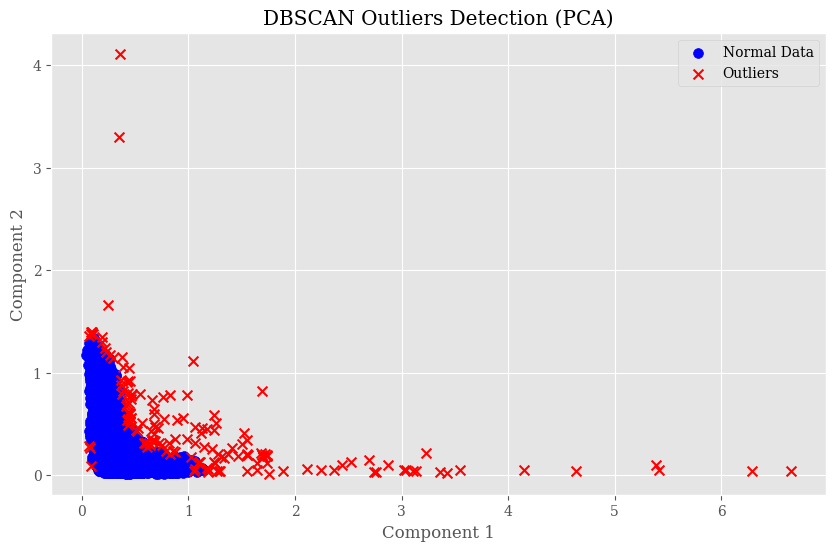

O casos normais são: (15567, 6)
O casos anomalos são: (156, 6)


In [42]:
dbscan_outliers = filtrarDBSCAN (df_Index_DPI_s3[~insecure_indices_po], dbscan_eps=0.04, dbscan_min_samples=10)

C:\Users\david\AppData\Local\Temp\ipykernel_34272\3132426074.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


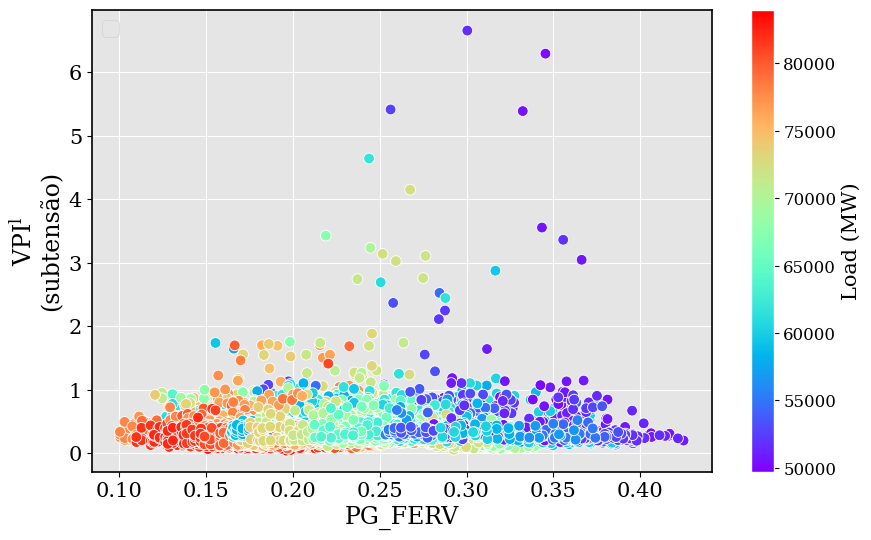

C:\Users\david\AppData\Local\Temp\ipykernel_34272\3132426074.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Indice de Correlación: -0.01489873428904041


Indice de Correlación: 0.10338933079311884


In [43]:
vpi_inf = r'$\mathrm{VPI}^\mathrm{l}$'
vpi_sup = r'$\mathrm{VPI}^\mathrm{u}$'
df = df_Index_DPI_s3.merge(DF_complete_PO, on=['key', 'Cenario'], how='left')
scatterplot_1(df[~insecure_indices_po], 'PG_FERV', 'IndiceInf_s3', xlbl=f'PG_FERV', ylbl = f'{vpi_inf}\n(subtensão)',lbl_bar= 'Load (MW)', v3='PL_MW', vline=False, hline=False , title='')
scatterplot_1(df[~insecure_indices_po], 'PG_FERV', 'IndiceSup_s3', xlbl=f'PG_FERV', ylbl = f'{vpi_sup}\n(sobretensão)',lbl_bar= 'Load (MW)', v3='PL_MW', vline=False, hline=False , title='')

C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:73: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.boxplot(data=df, x=clase, y=Variable, hue=hue, width=0.8, gap = 0.15, saturation = 0.75,  linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'})


C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:73: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.boxplot(data=df, x=clase, y=Variable, hue=hue, width=0.8, gap = 0.15, saturation = 0.75,  linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'})


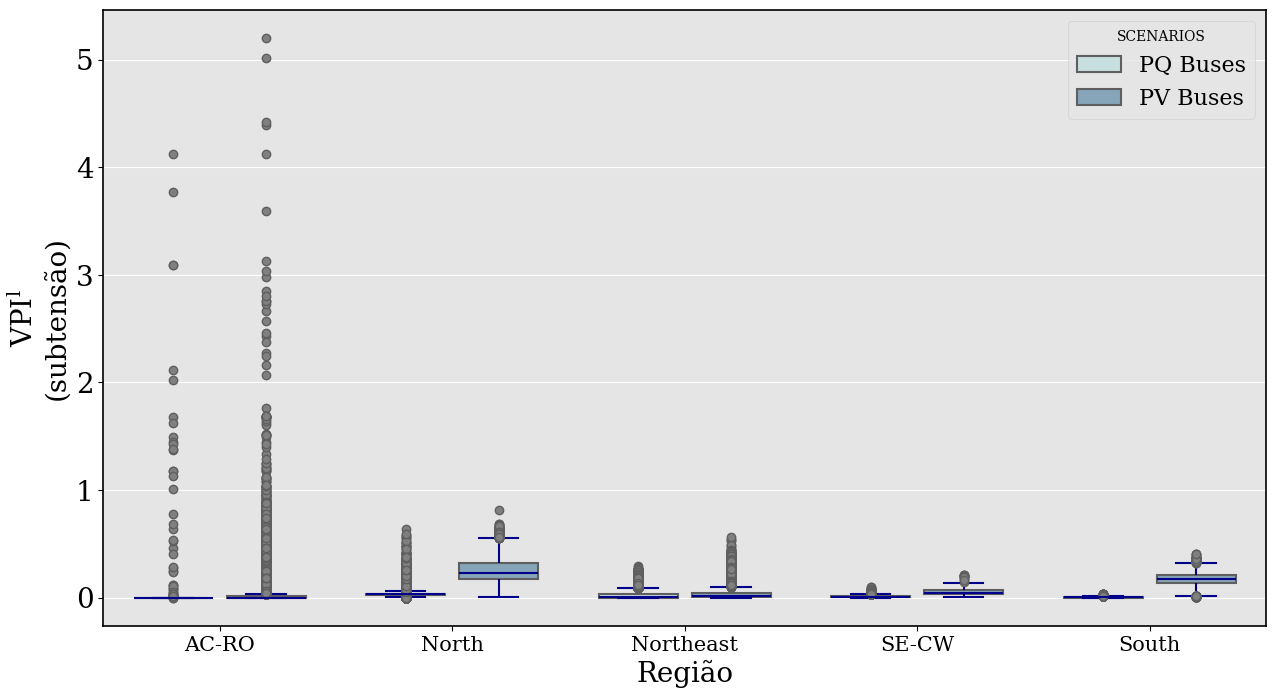

C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:73: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.boxplot(data=df, x=clase, y=Variable, hue=hue, width=0.8, gap = 0.15, saturation = 0.75,  linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'})


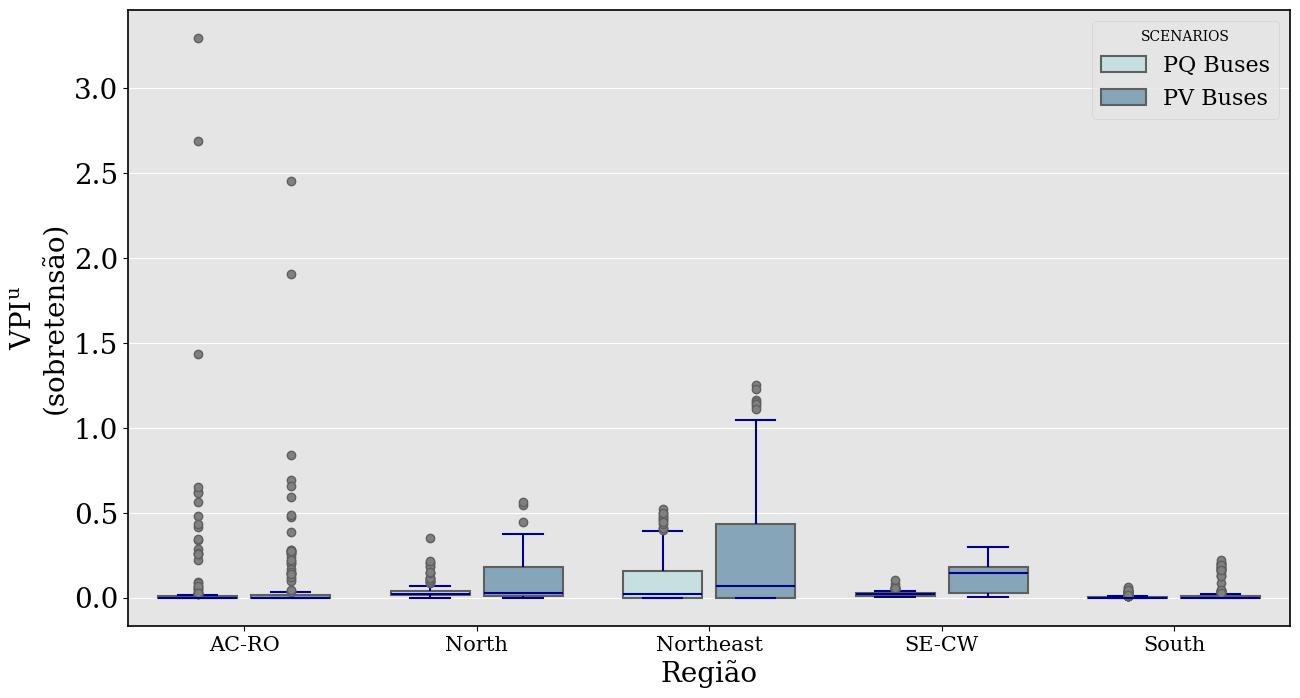

C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:73: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.boxplot(data=df, x=clase, y=Variable, hue=hue, width=0.8, gap = 0.15, saturation = 0.75,  linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'})


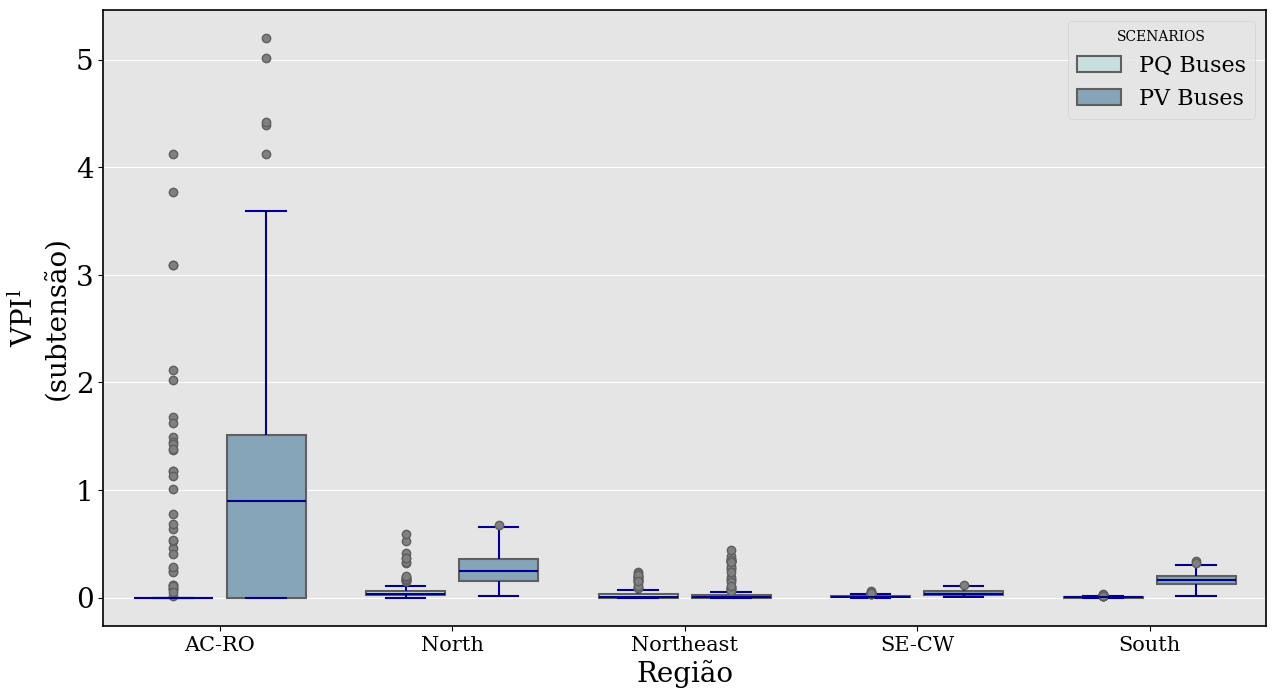

C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:73: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.boxplot(data=df, x=clase, y=Variable, hue=hue, width=0.8, gap = 0.15, saturation = 0.75,  linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'})


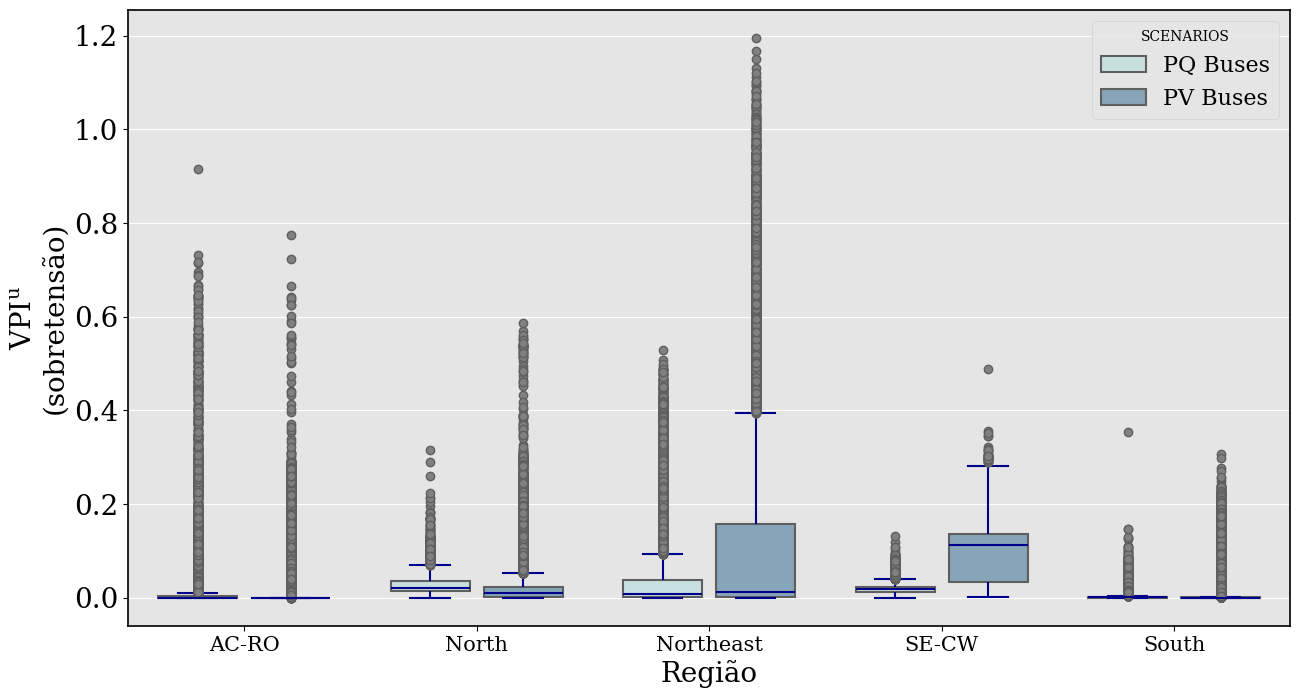

C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:73: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sns.boxplot(data=df, x=clase, y=Variable, hue=hue, width=0.8, gap = 0.15, saturation = 0.75,  linewidth=1.5, palette=intense_palette,flierprops={'markerfacecolor': 'gray', 'marker': 'o'})


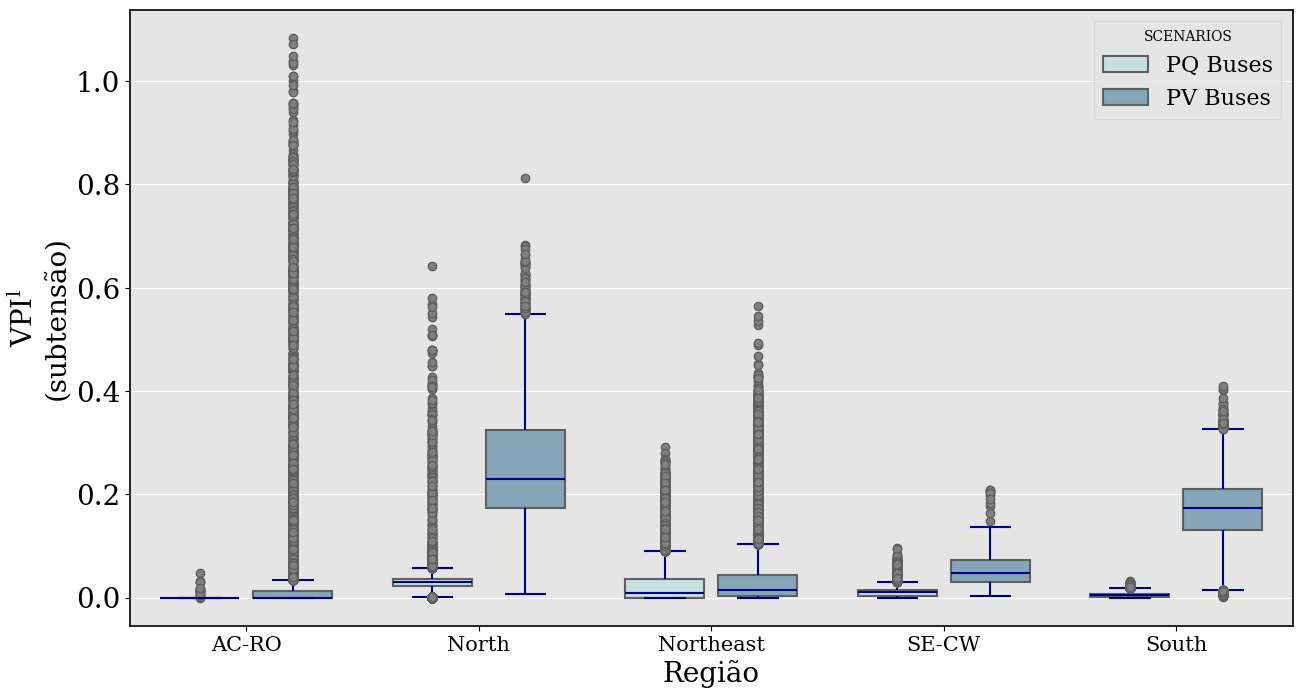

In [44]:
if Analise_INDICE:
    
    filtro_S2 = df_Index_DPI_s2.index.to_frame()[['key', 'Cenario']].apply(tuple, axis=1).isin(outliers)
    outliers2 = set(df_Index_DPI_s3[~insecure_indices_po][dbscan_outliers].index.to_frame()[['key', 'Cenario']].apply(tuple, axis=1).values)
    filtro_S3 = df_Index_DPI_s2[~filtro_S2].index.to_frame()[['key', 'Cenario']].apply(tuple, axis=1).isin(outliers2)

    vpi_inf = r'$\mathrm{VPI}^\mathrm{l}$'
    vpi_sup = r'$\mathrm{VPI}^\mathrm{u}$'

    df = pd.melt(df_Index_DPI_s2[~filtro_S2][['IndiceSup_s2_PV','IndiceSup_s2_PQ','REG']].reset_index(), id_vars=['REG'], value_vars=['IndiceSup_s2_PQ','IndiceSup_s2_PV'], ignore_index = False)
    boxplot_(df,'value', 'REG', '', 'Região', f'{vpi_sup}\n(sobretensão)', hue="variable") #, ylim= [-0.1,4]
    df = pd.melt(df_Index_DPI_s2[~filtro_S2][['IndiceInf_s2_PV','IndiceInf_s2_PQ','REG']].reset_index(), id_vars=['REG'], value_vars=['IndiceInf_s2_PQ','IndiceInf_s2_PV'], ignore_index = False)
    boxplot_(df,'value', 'REG', '', 'Região', f'{vpi_inf}\n(subtensão)', hue="variable")

    df = pd.melt(df_Index_DPI_s2[~filtro_S2][filtro_S3][['IndiceSup_s2_PV','IndiceSup_s2_PQ','REG']].reset_index(), id_vars=['REG'], value_vars=['IndiceSup_s2_PQ','IndiceSup_s2_PV'], ignore_index = False)
    boxplot_(df,'value', 'REG', '', 'Região', f'{vpi_sup}\n(sobretensão)', hue="variable") #, ylim= [-0.1,4]
    df = pd.melt(df_Index_DPI_s2[~filtro_S2][filtro_S3][['IndiceInf_s2_PV','IndiceInf_s2_PQ','REG']].reset_index(), id_vars=['REG'], value_vars=['IndiceInf_s2_PQ','IndiceInf_s2_PV'], ignore_index = False)
    boxplot_(df,'value', 'REG', '', 'Região', f'{vpi_inf}\n(subtensão)', hue="variable")

    
    df = pd.melt(df_Index_DPI_s2[~filtro_S2][~filtro_S3][['IndiceSup_s2_PV','IndiceSup_s2_PQ','REG']].reset_index(), id_vars=['REG'], value_vars=['IndiceSup_s2_PQ','IndiceSup_s2_PV'], ignore_index = False)
    boxplot_(df,'value', 'REG', '', 'Região', f'{vpi_sup}\n(sobretensão)', hue="variable")
    df = pd.melt(df_Index_DPI_s2[~filtro_S2][~filtro_S3][['IndiceInf_s2_PV','IndiceInf_s2_PQ','REG']].reset_index(), id_vars=['REG'], value_vars=['IndiceInf_s2_PQ','IndiceInf_s2_PV'], ignore_index = False)
    boxplot_(df,'value', 'REG', '', 'Região', f'{vpi_inf}\n(subtensão)', hue="variable")

C:\Users\david\AppData\Local\Temp\ipykernel_34272\3132426074.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


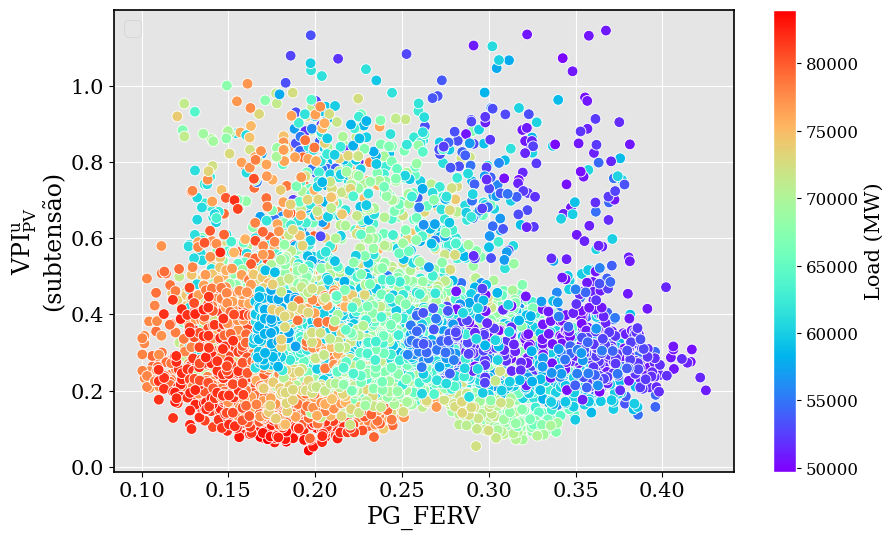

C:\Users\david\AppData\Local\Temp\ipykernel_34272\3132426074.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Indice de Correlación: -0.06383617322491923


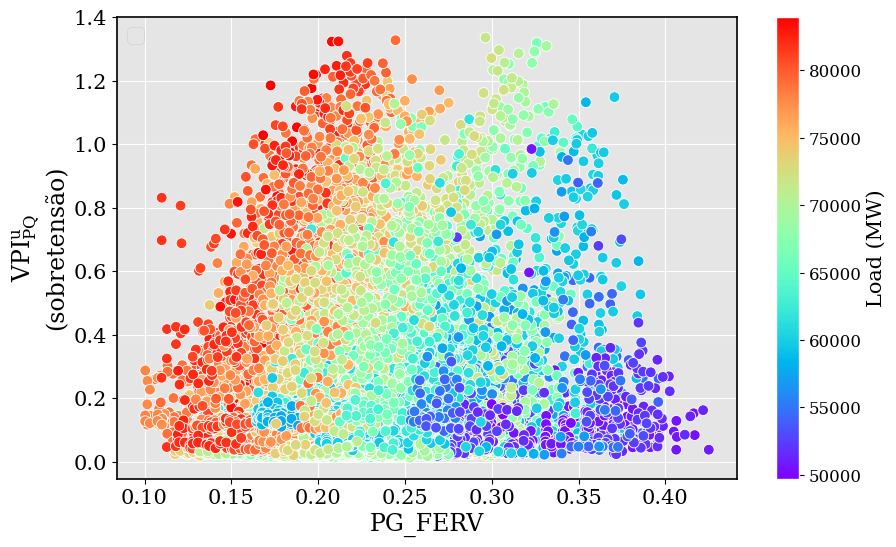

Indice de Correlación: 0.10474935662181782


In [45]:
df = df_Index_DPI_s3.merge(DF_complete_PO, on=['key', 'Cenario'], how='left')
scatterplot_1(df[~insecure_indices_po][~dbscan_outliers], 'PG_FERV', 'IndiceInf_s3', xlbl=f'PG_FERV', ylbl = f'{vpi_sup_pv}\n(subtensão)',lbl_bar= 'Load (MW)', v3='PL_MW', vline=False, hline=False , title='')
scatterplot_1(df[~insecure_indices_po][~dbscan_outliers], 'PG_FERV', 'IndiceSup_s3', xlbl=f'PG_FERV', ylbl = f'{vpi_sup_pq}\n(sobretensão)',lbl_bar= 'Load (MW)', v3='PL_MW', vline=False, hline=False , title='')

In [46]:
df_PV[['key', 'Cenario']].apply(tuple, axis=1).isin(list(outliers2) + list(outliers))

0          False
1          False
2          False
3          False
4          False
           ...  
1726699    False
1726700    False
1726701    False
1726702    False
1726703    False
Length: 1726704, dtype: bool

In [47]:
len(list(outliers))

265

In [48]:
len(list(outliers2) + list(outliers))

421

In [49]:
if Analise_INDICE:    
    
    Region = 'AC-RO'

    dfPV = df_PV.merge(df_area[['ARE','Nome da Area']], on='ARE', how='left')
    dfPQ = df_PQ.merge(df_area[['ARE','Nome da Area']], on='ARE', how='left')

    filtro_pv = dfPV[['key', 'Cenario']].apply(tuple, axis=1).isin(list(outliers2) + list(outliers))
    filtro_pq = dfPQ[['key', 'Cenario']].apply(tuple, axis=1).isin(list(outliers2) + list(outliers))

    ## Avalição Correlação só barras PV========================
    df_PV_indices = dfPV[~filtro_pv].merge(df_RPI_PV, on=['key', 'Dia', 'Hora', 'Cenario', 'REG', GB], how='left')
    df_PV_indices = df_PV_indices.set_index(['key',  'Cenario', 'REG', GB])
    ## Avalição Correlação só barras PQ========================
    df_PQ_indices = dfPQ[~filtro_pq].merge(df_RPI_PQ, on=['key', 'Dia', 'Hora', 'Cenario', 'REG', GB], how='left')
    df_PQ_indices = df_PQ_indices.set_index(['key',  'Cenario', 'REG', GB])

C:\Users\david\AppData\Local\Temp\ipykernel_34272\3132426074.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


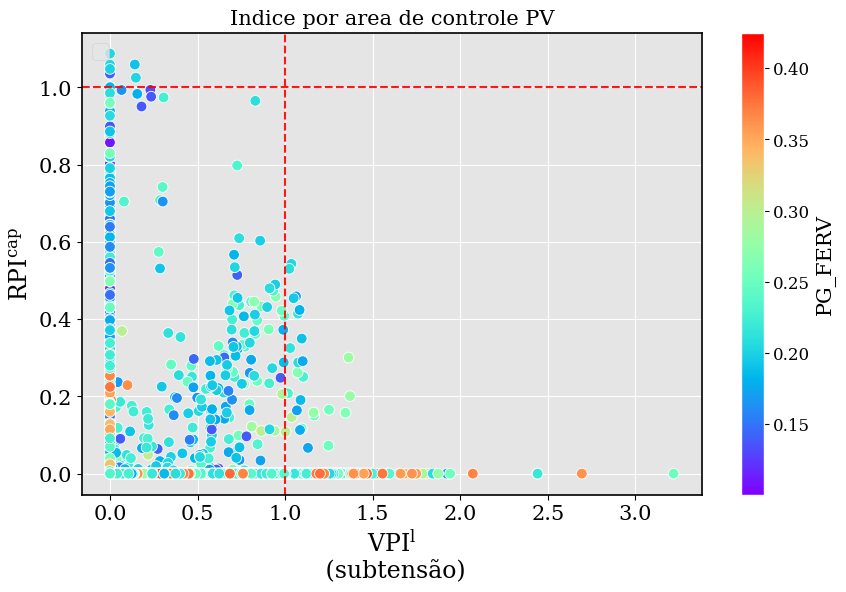

Indice de Correlación: 0.01675143678790063


C:\Users\david\AppData\Local\Temp\ipykernel_34272\3132426074.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")  # '_r' suffix to reverse the colormap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


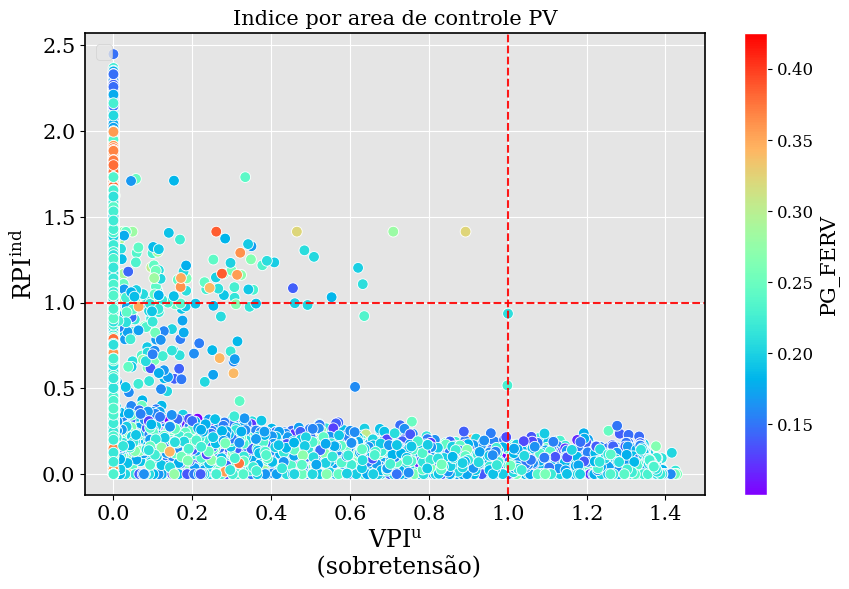

Indice de Correlación: -0.33926372319195286


In [50]:
if Analise_INDICE:
    vpi_inf = r'$\mathrm{VPI}^\mathrm{l}$'
    vpi_sup = r'$\mathrm{VPI}^\mathrm{u}$'
    rpi_ind = r'$\mathrm{RPI}^\mathrm{ind}$'
    rpi_cap = r'$\mathrm{RPI}^\mathrm{cap}$'

    # ======PLOTS=======
    # scatterplot_1(df_PV_indices.loc[:,:,Region,:], 'IndiceInf_s1' , 'IndiceSup_s1',xlbl=f'{vpi_inf}\n (subtensão)', ylbl = f'{vpi_sup}\n (sobretensão)',lbl_bar= 'RPI_ind', v3='RPI_ind', vline=True, hline=True , title='Indice por area de controle PV')
    # scatterplot_1(df_PV_indices.loc[:,:,Region,:], 'IndiceInf_s1' , 'IndiceSup_s1',xlbl=f'{vpi_inf}\n (subtensão)', ylbl = f'{vpi_sup}\n (sobretensão)',lbl_bar= 'RPI_cap', v3='RPI_cap', vline=True, hline=True , title='Indice por area de controle PV')

    # # ======PLOTS=======
    # scatterplot_1(df_PQ_indices.loc[:,:,Region,:], 'IndiceInf_s1' , 'IndiceSup_s1',xlbl=f'{vpi_inf}\n (subtensão)', ylbl = f'{vpi_sup}\n (sobretensão)',lbl_bar= 'RPI_ind', v3='RPI_ind', vline=True, hline=True , title='Indice por area de controle PQ')
    # scatterplot_1(df_PQ_indices.loc[:,:,Region,:], 'IndiceInf_s1' , 'IndiceSup_s1',xlbl=f'{vpi_inf}\n (subtensão)', ylbl = f'{vpi_sup}\n (sobretensão)',lbl_bar= 'RPI_cap', v3='RPI_cap', vline=True, hline=True , title='Indice por area de controle PQ')

    DF = df_PV_indices.reset_index().merge(DF_complete_PO, on=['key','Cenario']).set_index(['key','Cenario','REG','ARE'])
    scatterplot_1(DF.loc[:,:,Region,:], 'IndiceInf_s1' , 'RPI_cap', xlbl=f'{vpi_inf}\n (subtensão)', ylbl = rpi_cap, lbl_bar= 'PG_FERV', v3='PG_FERV', vline=True, hline=True , title='Indice por area de controle PV')
    scatterplot_1(DF.loc[:,:,Region,:], 'IndiceSup_s1' , 'RPI_ind', xlbl=f'{vpi_sup}\n (sobretensão)', ylbl = rpi_ind, lbl_bar= 'PG_FERV', v3='PG_FERV', vline=True, hline=True , title='Indice por area de controle PV')

    # DF = df_PV_indices.reset_index().merge(DF_complete_PO, on=['key','Cenario']).set_index(['key','Cenario','REG','ARE'])
    # scatterplot_1(DF.loc[:,:,Region,:], 'IndiceSup_s1' , 'RPI_cap', xlbl=f'{vpi_inf}\n (sobretensão)', ylbl = rpi_cap, lbl_bar= 'DL_MW', v3='DL_MW', vline=True, hline=True , title='Indice por area de controle PV')
    # scatterplot_1(DF.loc[:,:,Region,:], 'IndiceInf_s1' , 'RPI_ind', xlbl=f'{vpi_inf}\n (subtensão)', ylbl = rpi_ind, lbl_bar= 'DL_MW', v3='DL_MW', vline=True, hline=True , title='Indice por area de controle PV')

In [51]:
# dff = df_PV_indices[df_PV_indices['RPI_ind']>1]
dff = df_PV_indices[(df_PV_indices['RPI_ind']>1) & (df_PV_indices['IndiceSup_s1']>1)]
dff.loc[:,:,'North',:].reset_index().value_counts('ARE')

ARE
861    1290
821       3
842       2
804       1
841       1
Name: count, dtype: int64

In [52]:
dff.loc[:,:,'North',861].sort_values('RPI_ind', ascending = False)

Dia   Hora  IndiceInf_s1  IndiceSup_s1  num_NB  \
key          Cenario                                                   
D_6_H_19-30  V2A2F2     6  19-30      1.772131      1.822532      14   
D_26_H_21-00 V2A2F3    26  21-00      1.750934      2.145893      14   
D_26_H_21-30 V2A2F2    26  21-30      1.730647      2.202696      14   
D_26_H_21-00 V2A2F2    26  21-00      1.829089      1.480859      14   
D_15_H_18-00 V2A2F5    15  18-00      2.629747      1.018600      14   
...                   ...    ...           ...           ...     ...   
D_5_H_10-30  V1A1F2     5  10-30      0.000000      1.906222      14   
D_14_H_10-00 V1A1F5    14  10-00      0.000000      2.251244      14   
D_1_H_21-00  V1A1F2     1  21-00      0.000000      2.312064      14   
D_11_H_22-00 V1A1F3    11  22-00      0.000000      2.371549      14   
D_1_H_13-30  V1A1F5     1  13-30      0.000000      2.133829      14   

                      num_NB_inf  num_NB_sup  num_NR Nome da Area   RPI_ind  \
key          Cenario                                                          
D_6_H_19-30  V2A2F2          4.0         5.0      67       500 kV  2.521461   
D_26_H_21-00 V2A2F3          5.0         6.0      67       500 kV  2.521459   
D_26_H_21-30 V2A2F2          5.0         6.0      67       500 kV  2.516079   
D_26_H_21-00 V2A2F2          6.0         6.0      67       500 kV  2.507845   
D_15_H_18-00 V2A2F5         12.0         1.0      67       500 kV  2.491847   
...                          ...         ...     ...          ...       ...   
D_5_H_10-30  V1A1F2          0.0         6.0      67       500 kV  1.007897   
D_14_H_10-00 V1A1F5          0.0         6.0      67       500 kV  1.001775   
D_1_H_21-00  V1A1F2          0.0         6.0      67       500 kV  1.001700   
D_11_H_22-00 V1A1F3          0.0         7.0      67       500 kV  1.001506   
D_1_H_13-30  V1A1F5          0.0         6.0      67       500 kV  1.001422   

                      RPI_cap  
key          Cenario           
D_6_H_19-30  V2A2F2    0.0000  
D_26_H_21-00 V2A2F3    0.0000  
D_26_H_21-30 V2A2F2    0.0000  
D_26_H_21-00 V2A2F2    0.0000  
D_15_H_18-00 V2A2F5    0.8024  
...                       ...  
D_5_H_10-30  V1A1F2    0.0000  
D_14_H_10-00 V1A1F5    0.0009  
D_1_H_21-00  V1A1F2    0.0000  
D_11_H_22-00 V1A1F3    0.0000  
D_1_H_13-30  V1A1F5    0.0000  

[1290 rows x 11 columns]

### Plot Tensão 3 (Persistency Plots)

In [53]:
if Analise_INDICE:
    n_AREAS = 10
    n_barras = 20

    def top_n_group(df, group_cols, sort_col, n):
        return df.groupby(group_cols).apply(lambda x: x.nlargest(n, sort_col)).reset_index(drop=True)

    # Filter regions
    df_PV_indices_reg = df_PV_indices.loc[:,:,Region,:]
    df_PQ_indices_reg = df_PQ_indices.loc[:,:,Region,:]

    # Aggregation function
    agg_cols = {
        'IndiceInf_s1': 'mean',
        'IndiceSup_s1': 'mean',
        'RPI_ind':'mean',
        'RPI_cap':'mean',
        'Nome da Area': 'first'
    }

    # Aggregate areas
    df_pv_areas = df_PV_indices_reg.groupby(['ARE']).agg(agg_cols).reset_index()
    df_pq_areas = df_PQ_indices_reg.groupby(['ARE']).agg(agg_cols).reset_index()

    # Sort and select top areas
    AREAS_inf_pv = df_pv_areas.nlargest(n_AREAS, 'IndiceInf_s1')
    AREAS_sup_pv = df_pv_areas.nlargest(n_AREAS, 'IndiceSup_s1')
    AREAS_inf_pq = df_pq_areas.nlargest(n_AREAS, 'IndiceInf_s1')
    AREAS_sup_pq = df_pq_areas.nlargest(n_AREAS, 'IndiceSup_s1')

    # Convert to lists for filtering
    listadeareas_inf_pv = AREAS_inf_pv['ARE'].tolist()
    listadeareas_sup_pv = AREAS_sup_pv['ARE'].tolist()
    listadeareas_inf_pq = AREAS_inf_pq['ARE'].tolist()
    listadeareas_sup_pq = AREAS_sup_pq['ARE'].tolist()

    # Filter data based on indices
    filter_condition = lambda df: (df['IndiceInf_s1'] > 1) | (df['IndiceSup_s1'] > 1)
    df_PV_indices_reg_filt = df_PV_indices_reg[filter_condition(df_PV_indices_reg)]
    df_PQ_indices_reg_filt = df_PQ_indices_reg[filter_condition(df_PQ_indices_reg)]

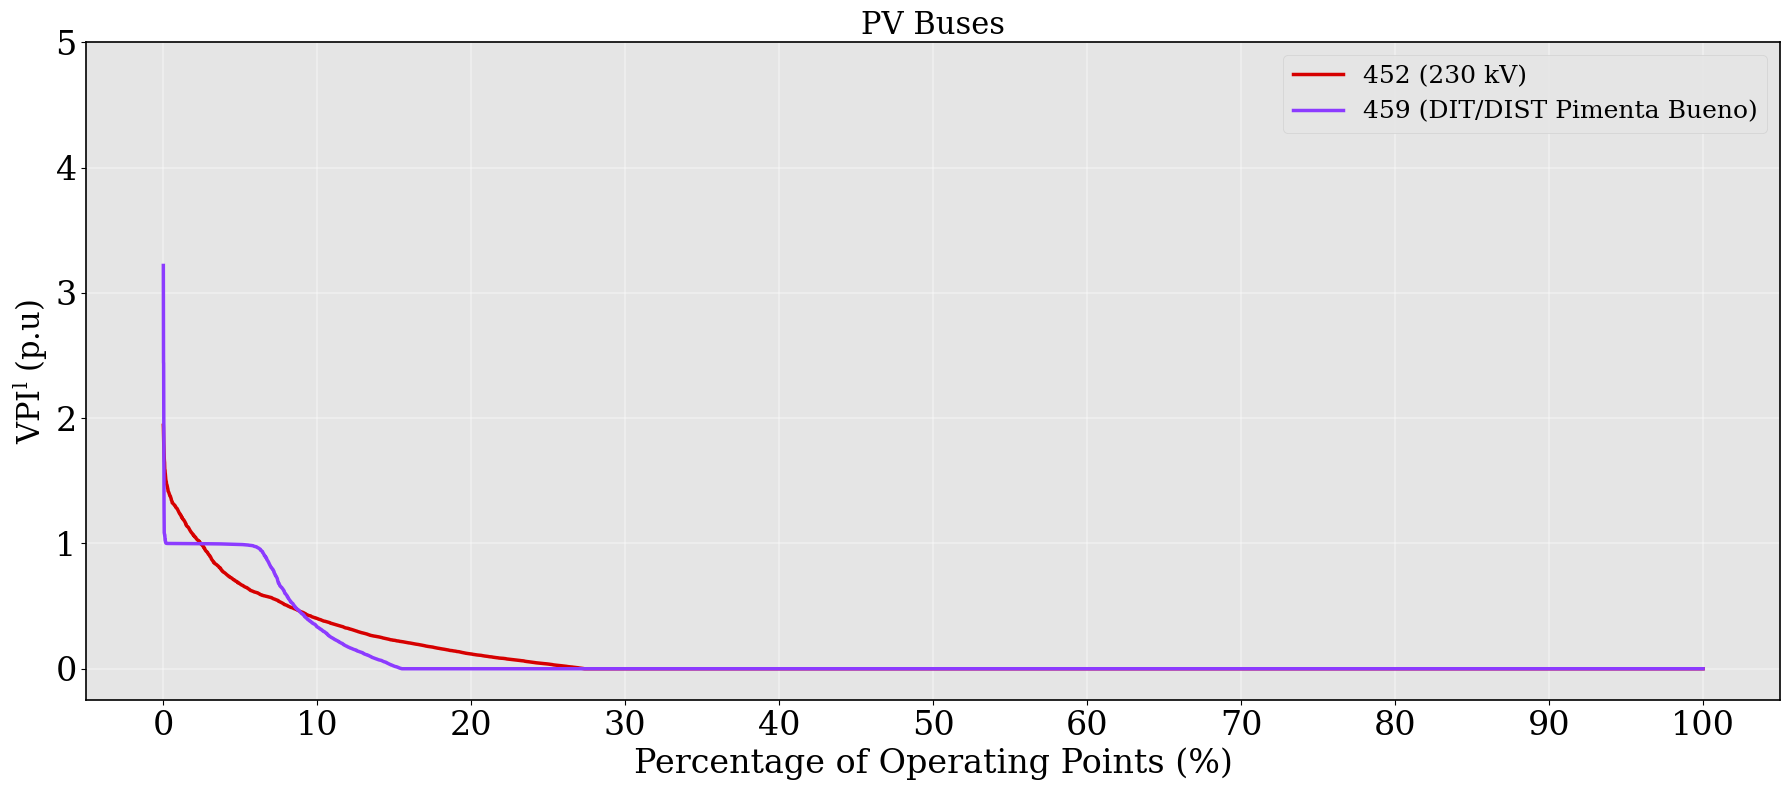

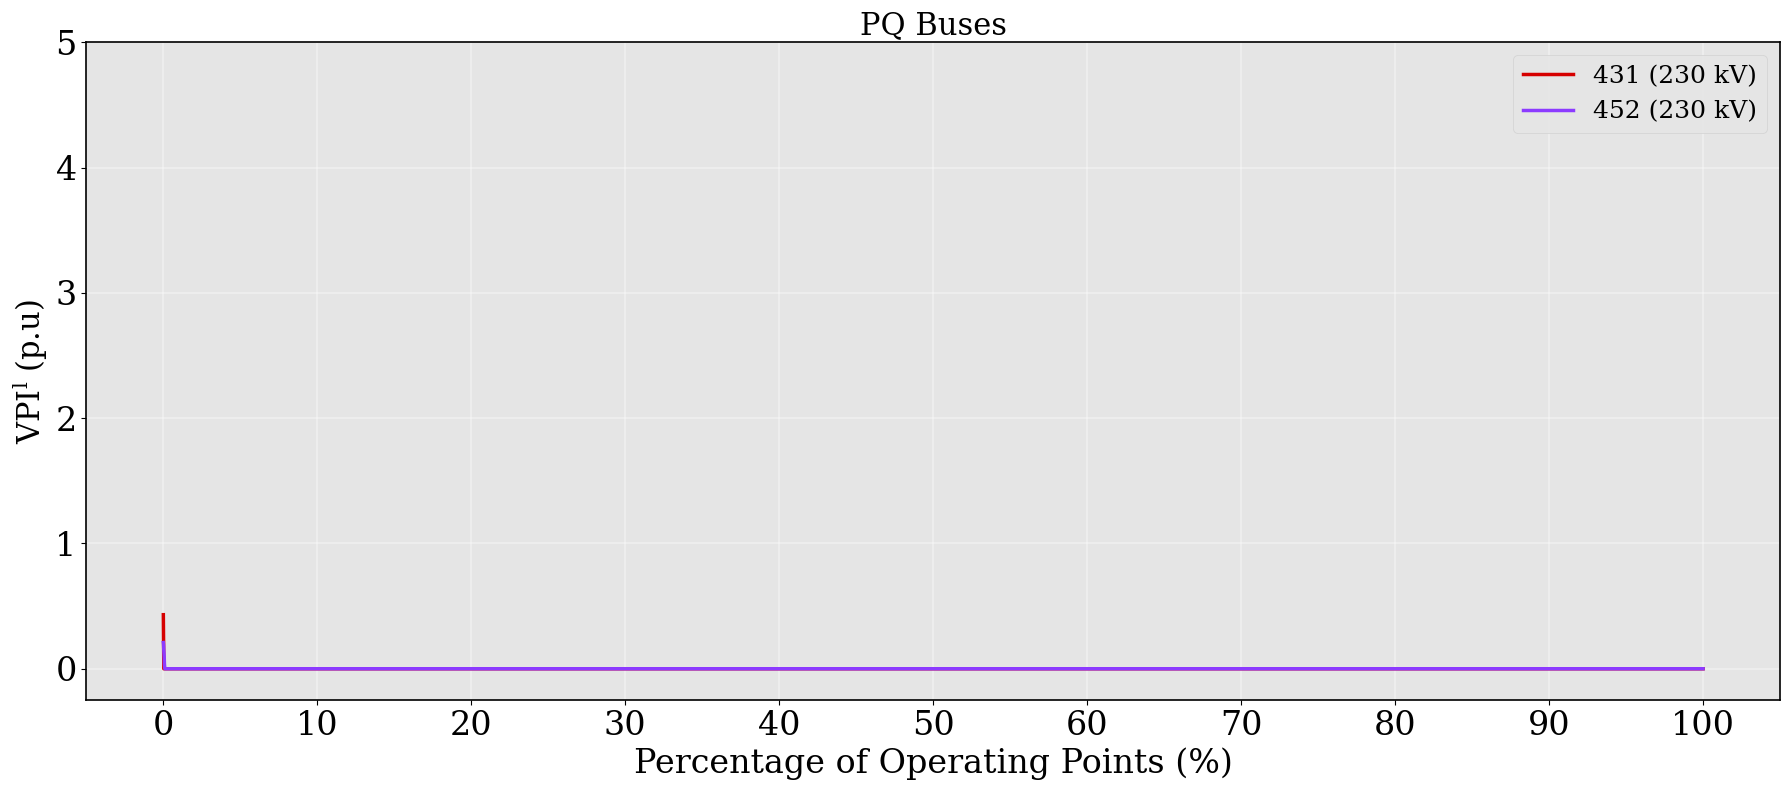

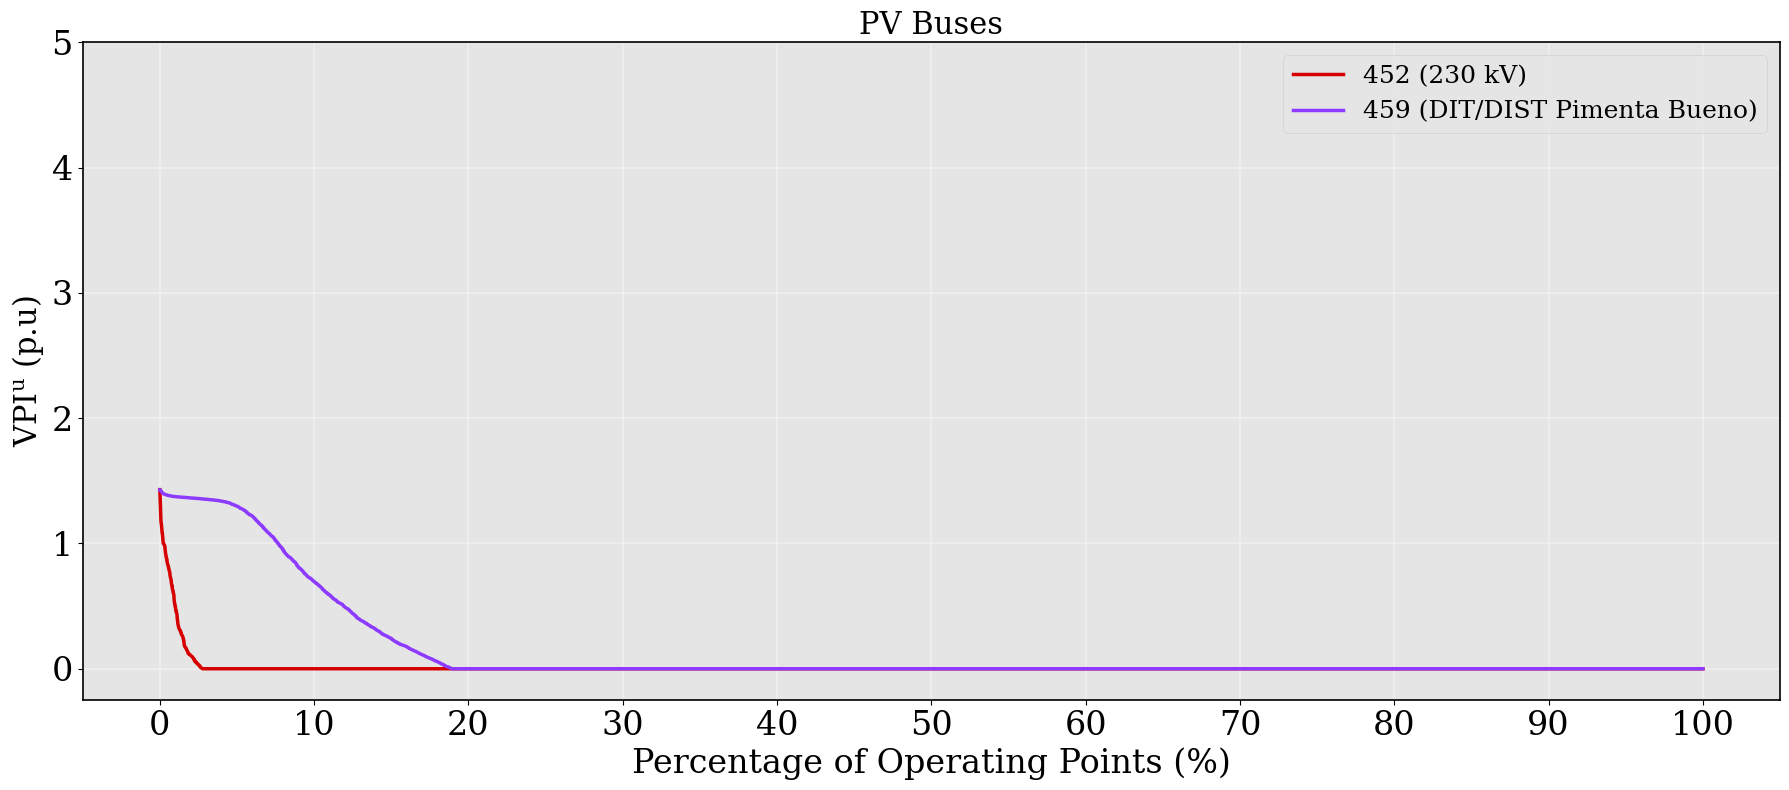

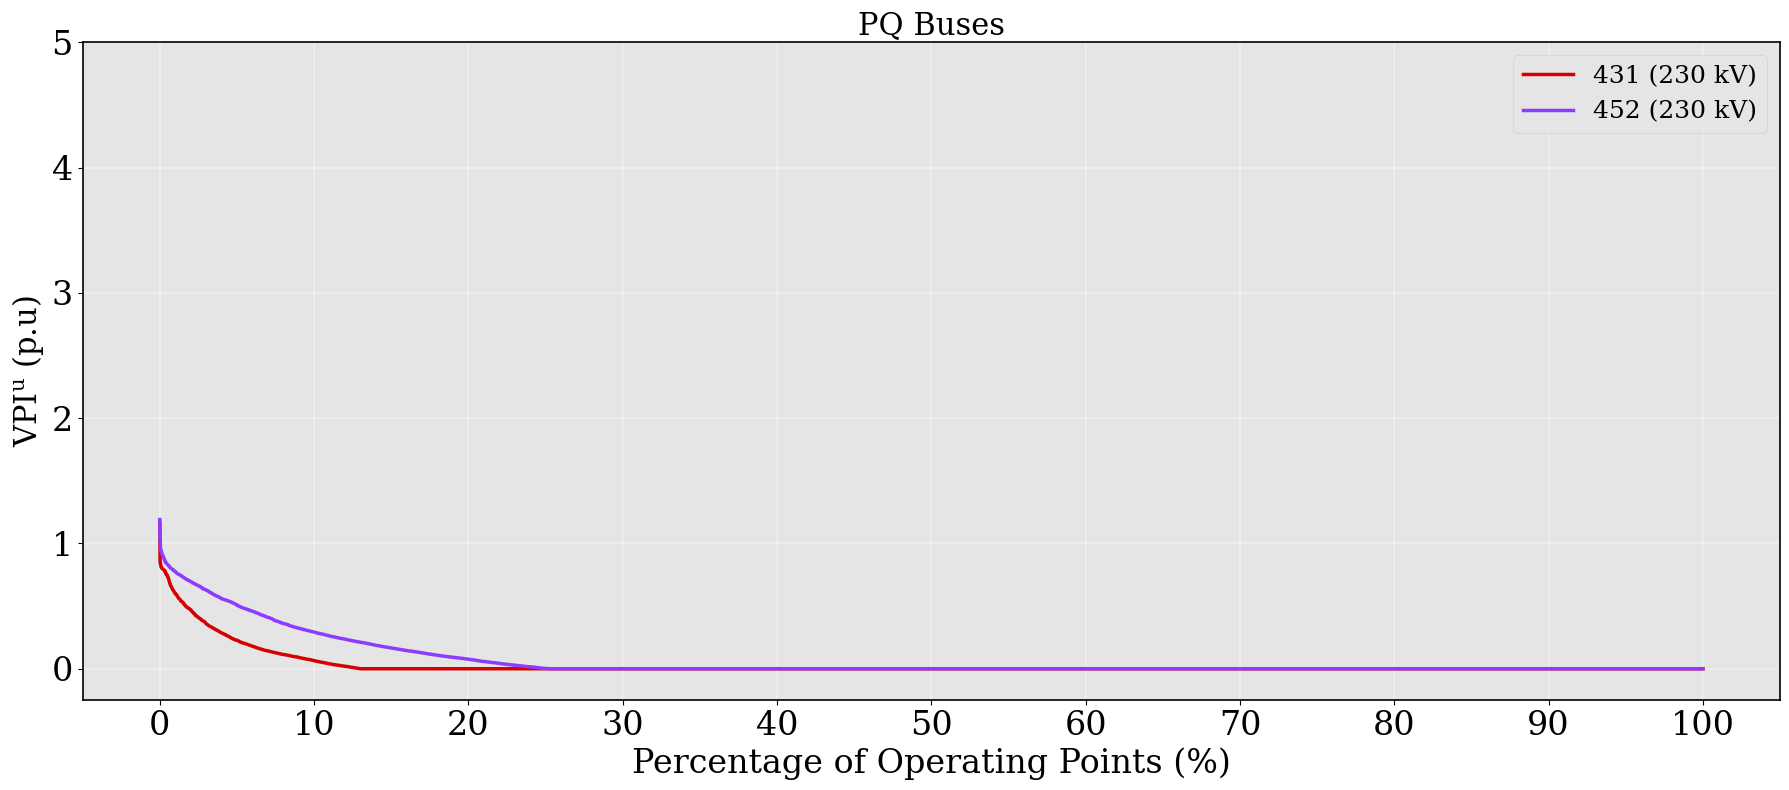

In [54]:
if Analise_INDICE:
    indice = 'IndiceInf_s1'

    plot_line(dfPV[~filtro_pv].set_index(['Dia','Hora','REG',  GB]).loc[:,:, Region,:], indice, 'Percentage of Operating Points (%)', f'{vpi_inf} (p.u)', 'PV Buses', '',  byClass = True, clase=GB, order=True, month = False, ylimites=[-0.25, 5]) #ylimites=[-0.25, 3]
    plot_line(dfPQ[~filtro_pq].set_index(['Dia','Hora','REG',  GB]).loc[:,:, Region,:], indice, 'Percentage of Operating Points (%)', f'{vpi_inf} (p.u)', 'PQ Buses', '',  byClass = True, clase=GB, order=True, month = False, ylimites=[-0.25, 5]) #ylimites=[-0.25, 3]

    indice = 'IndiceSup_s1'

    plot_line(dfPV[~filtro_pv].set_index(['Dia','Hora','REG',  GB]).loc[:,:, Region,:], indice, 'Percentage of Operating Points (%)',f'{vpi_sup} (p.u)', 'PV Buses', '',  byClass = True, clase=GB, order=True, month = False, ylimites=[-0.25, 5]) #ylimites=[-0.25, 3]
    plot_line(dfPQ[~filtro_pq].set_index(['Dia','Hora','REG',  GB]).loc[:,:, Region,:], indice, 'Percentage of Operating Points (%)',f'{vpi_sup} (p.u)', 'PQ Buses', '',  byClass = True, clase=GB, order=True, month = False, ylimites=[-0.25, 5]) #ylimites=[-0.25, 3]

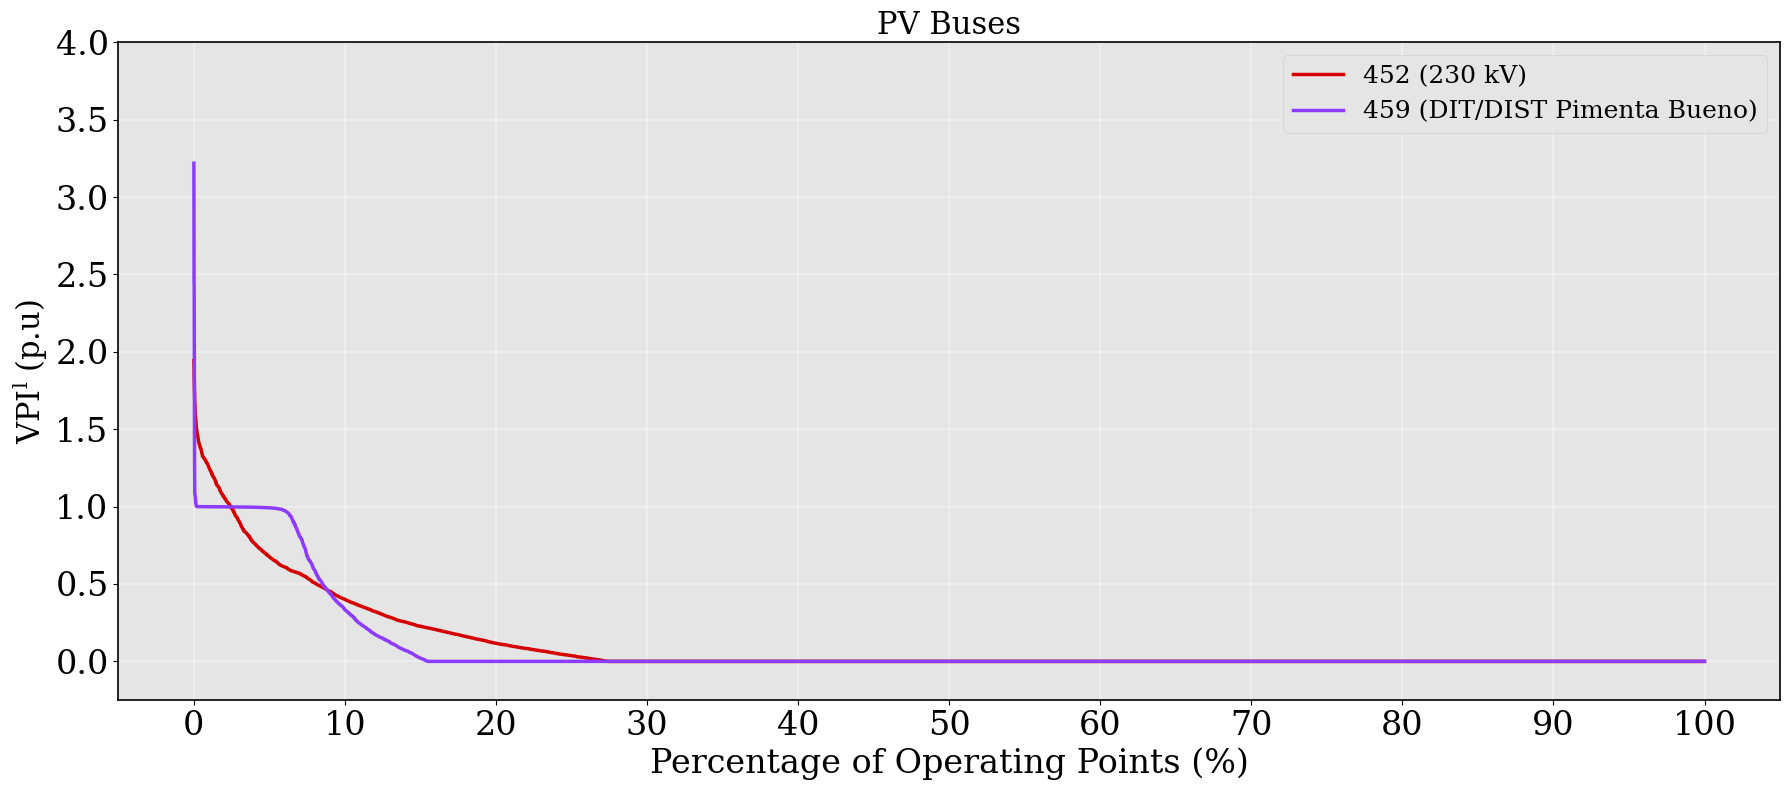

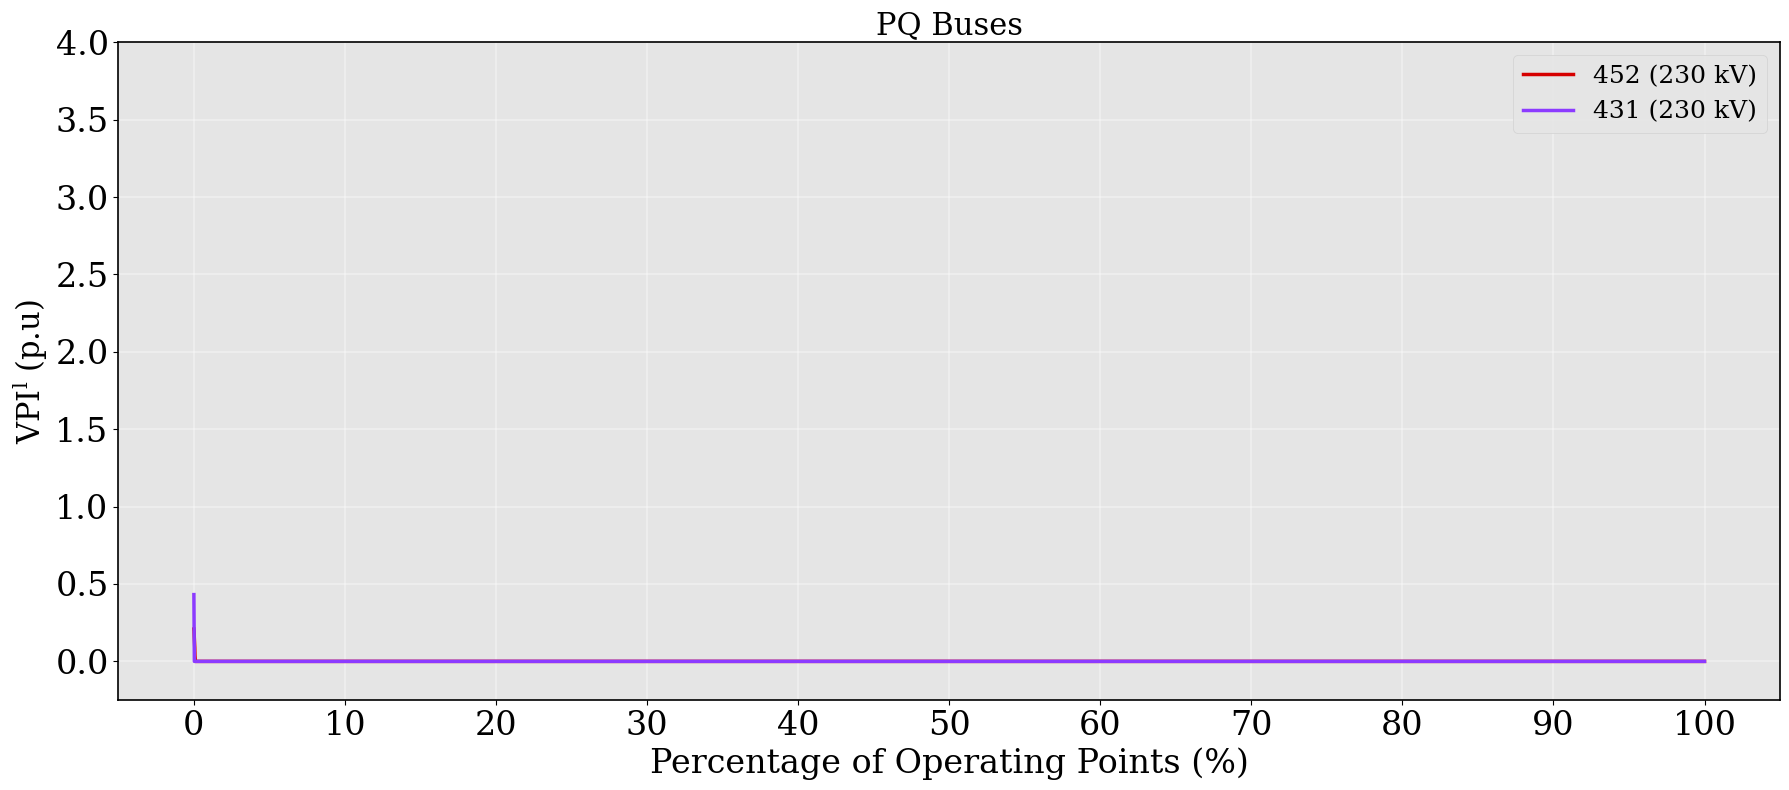

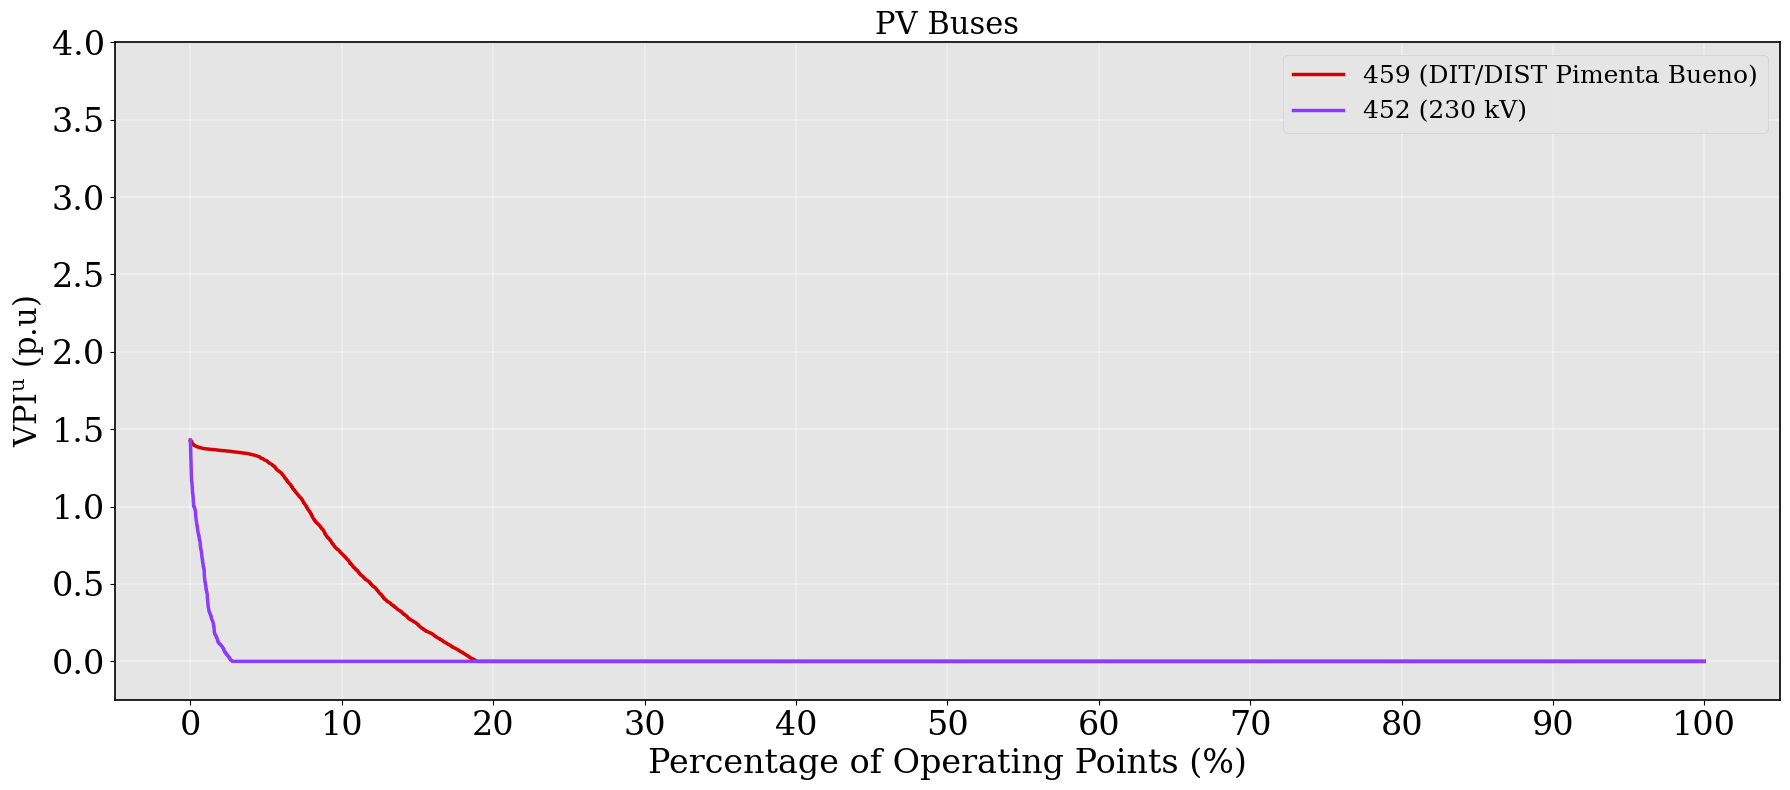

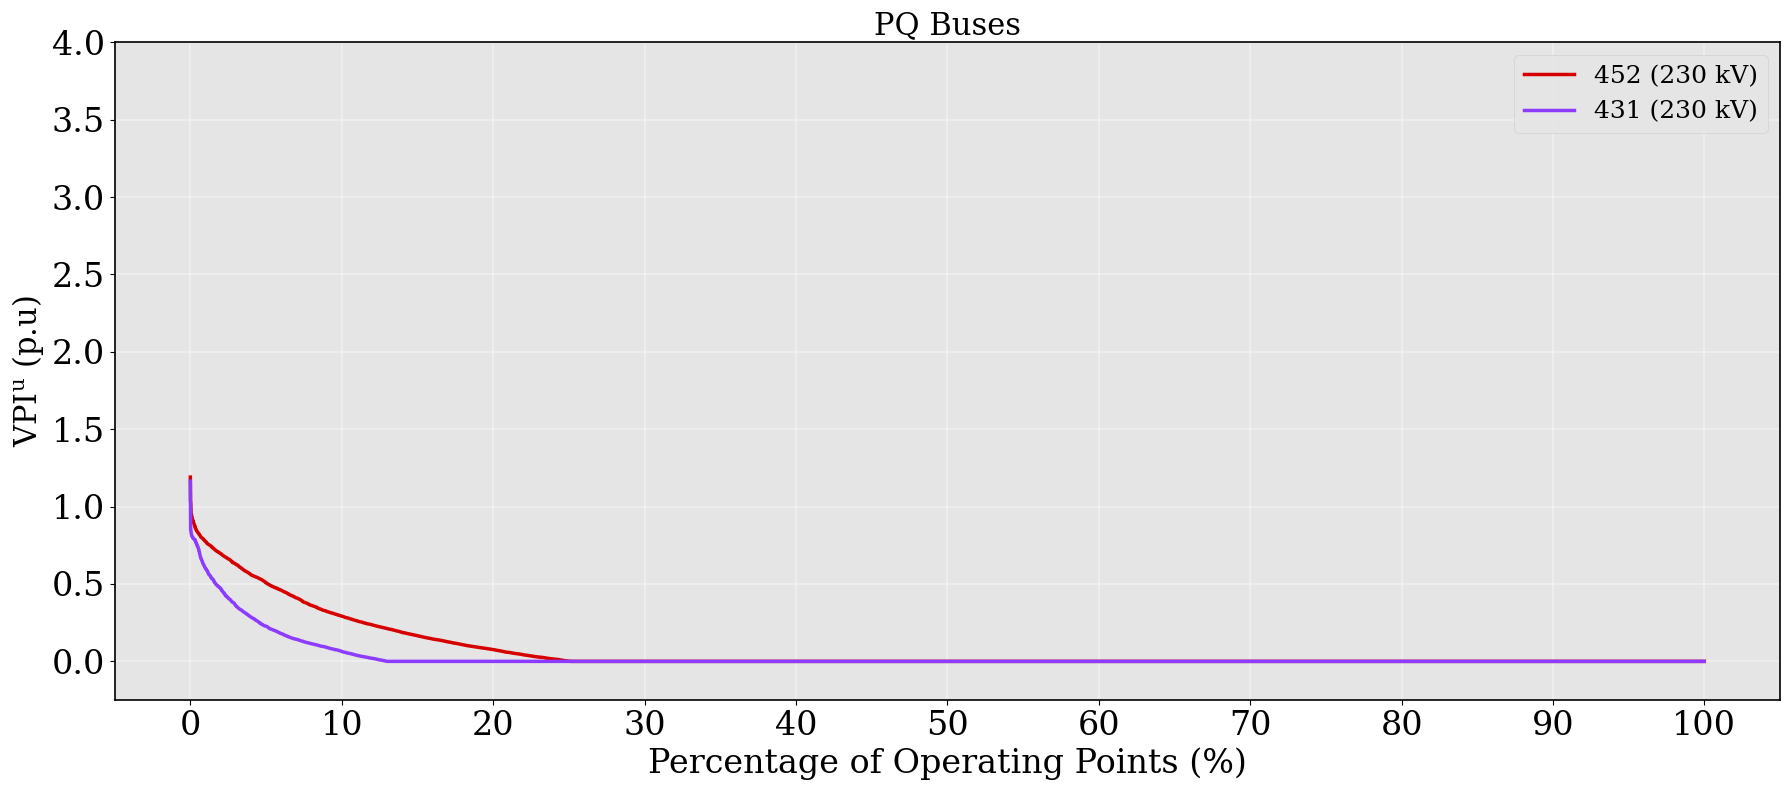

In [55]:
indice = 'IndiceInf_s1'
df = dfPV[~filtro_pv].set_index(['key', 'REG',  GB]).loc[:, Region, AREAS_inf_pv['ARE'].values]
plot_line(df, indice, 'Percentage of Operating Points (%)', f'{vpi_inf} (p.u)', 'PV Buses', '',  byClass = True, clase=GB, order=True, month = False, ylimites=[-0.25, 4]) #ylimites=[-0.25, 2]
df = dfPQ[~filtro_pq].set_index(['key','REG',  GB]).loc[:, Region, AREAS_inf_pq['ARE'].values]
plot_line(df, indice, 'Percentage of Operating Points (%)', f'{vpi_inf} (p.u)', 'PQ Buses', '',  byClass = True, clase=GB, order=True, month = False, ylimites=[-0.25, 4]) #ylimites=[-0.25, 2]

indice = 'IndiceSup_s1'
df = dfPV[~filtro_pv].set_index(['key','REG',  GB]).loc[:, Region, AREAS_sup_pv['ARE'].values]
plot_line(df, indice, 'Percentage of Operating Points (%)',f'{vpi_sup} (p.u)', 'PV Buses', '',  byClass = True, clase=GB, order=True, month = False, ylimites=[-0.25, 4]) #ylimites=[-0.25, 2]
df = dfPQ[~filtro_pq].set_index(['key','REG',  GB]).loc[:, Region, AREAS_sup_pq['ARE'].values]
plot_line(df, indice, 'Percentage of Operating Points (%)',f'{vpi_sup} (p.u)', 'PQ Buses', '',  byClass = True, clase=GB, order=True, month = False, ylimites=[-0.25, 4]) #ylimites=[-0.25, 2]


### Plot Tensão 4 (médias)

C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


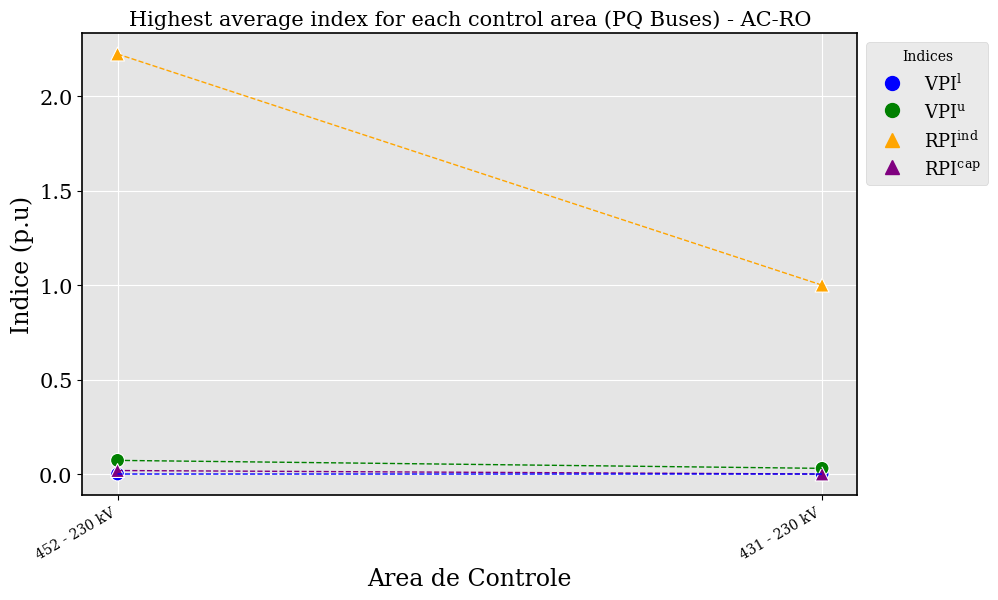

C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


In [56]:
if Analise_INDICE:
    # Merge and group for features
    def get_features(df_merged, area_list, reg, group_cols, Flag):
        if Flag == 'PV':
            return df_merged[df_merged['ARE'].isin(area_list) & (df_merged['REG'] == reg)].groupby(group_cols).agg({
                'BUS_NAME': 'first',
                'IndiceInf': 'mean',
                'IndiceSup': 'mean',
                'ReservaIND': 'mean',
                'ReservaCAP': 'mean',
            }).reset_index()
        elif  Flag == 'PQ':
            return df_merged[df_merged['ARE'].isin(area_list) & (df_merged['REG'] == reg)].groupby(group_cols).agg({
                'BUS_NAME': 'first',
                'IndiceInf': 'mean',
                'IndiceSup': 'mean',
                'ReservaINDshunt': 'mean',
                'ReservaCAPshunt': 'mean',
            }).reset_index()

    # Get features for different conditions
    dfaux = df_filt_ger.merge(df_PV_indices_reg_filt, on=['key', 'Cenario', 'ARE'], how='inner')
    dfeatures_pv_inf = get_features(dfaux, listadeareas_inf_pv, Region, ['BUS_ID'], 'PV')
    dfeatures_pv_sup = get_features(dfaux, listadeareas_sup_pv, Region, ['BUS_ID'], 'PV')

    dfaux = df_filt_nt.merge(df_PQ_indices_reg_filt, on=['key', 'Cenario', 'ARE'], how='inner')
    dfeatures_pq_inf = get_features(dfaux, listadeareas_inf_pq, Region, ['BUS_ID'], 'PQ')
    dfeatures_pq_sup = get_features(dfaux, listadeareas_sup_pq, Region, ['BUS_ID'], 'PQ')

    # Select top n_barras features  
    features_inf_pv = dfeatures_pv_inf.nlargest(n_barras, 'IndiceInf')
    features_sup_pv = dfeatures_pv_sup.nlargest(n_barras, 'IndiceSup') 
    features_inf_pq = dfeatures_pq_inf.nlargest(n_barras, 'IndiceInf')
    features_sup_pq = dfeatures_pq_sup.nlargest(n_barras, 'IndiceSup')

    # Scatter plot function
    def create_scatter(df, id_vars, value_vars, title):
        df_melted = pd.melt(df, id_vars=id_vars, value_vars=value_vars, ignore_index=False)
        # df_melted['ARE'] = df_melted['ARE'].astype('str')
        scatterplot_3(df_melted, 'Nome Area', 'value', 'Area de Controle', 'Indice (p.u)', lbl_bar='variable', v3='variable', xlimites=None, ylimites=None, title=title, vline=False, hline=False, Chngelbl = True, sizelbl = 10, rotation = 30)

    # Generate plots for each 
    AREAS_inf_pv['Nome Area'] = AREAS_inf_pv['ARE'].astype(str) + ' - ' + AREAS_inf_pv['Nome da Area']
    create_scatter(AREAS_inf_pv, ['Nome Area'], ['IndiceInf_s1','IndiceSup_s1','RPI_ind','RPI_cap'],f'Highest average index for each control area (PV Buses) - {Region}')
    # create_scatter(AREAS_sup_pv, ['ARE','Nome da Area'], ['IndiceSup_s1','RPI_ind','RPI_cap'], 'Areas de Controle Norte com índice médio maior (Sobretensão PV)')
    AREAS_inf_pq['Nome Area'] = AREAS_inf_pq['ARE'].astype(str) + ' - ' + AREAS_inf_pq['Nome da Area']
    create_scatter(AREAS_inf_pq, ['Nome Area'], ['IndiceInf_s1','IndiceSup_s1','RPI_ind','RPI_cap'], f'Highest average index for each control area (PQ Buses) - {Region}')
    # create_scatter(AREAS_sup_pq, ['ARE','Nome da Area'], ['IndiceSup_s1','RPI_ind','RPI_cap'], 'Areas de Controle Norte com índice médio maior (Sobretensão PQ)')

    # Plot for features
    def plot_feature_data(features, value_vars, title):
        df_melted = pd.melt(features, id_vars=['BUS_ID', 'BUS_NAME'], value_vars=value_vars, ignore_index=False)
        scatterplot_3(df_melted, 'BUS_NAME', 'value', 'Barra', 'Indice (p.u)', lbl_bar='variable', v3='variable', xlimites=None, ylimites=None, title=title, vline=False, hline=False, Chngelbl = True, sizelbl = 10, rotation = 45)

    plot_feature_data(features_inf_pv, ['IndiceInf','ReservaIND','ReservaCAP'], f'Highest average index for (PV Buses) - {Region}')
    plot_feature_data(features_sup_pv, ['IndiceSup','ReservaIND','ReservaCAP'], f'Highest average index for (PV Buses) - {Region}')
    plot_feature_data(features_inf_pq, ['IndiceInf','ReservaINDshunt','ReservaCAPshunt'], f'Highest average index for (PQ Buses) - {Region}')
    plot_feature_data(features_sup_pq, ['IndiceSup','ReservaINDshunt','ReservaCAPshunt'], f'Highest average index for (PQ Buses) - {Region}')

numero de pontos de operação criticos
0
numero de areas criticas
0



C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")
C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:142: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(data=df, x=v1, y=v2, hue=v3, style=v3, s=size, palette=colors, markers=markers, legend=True)


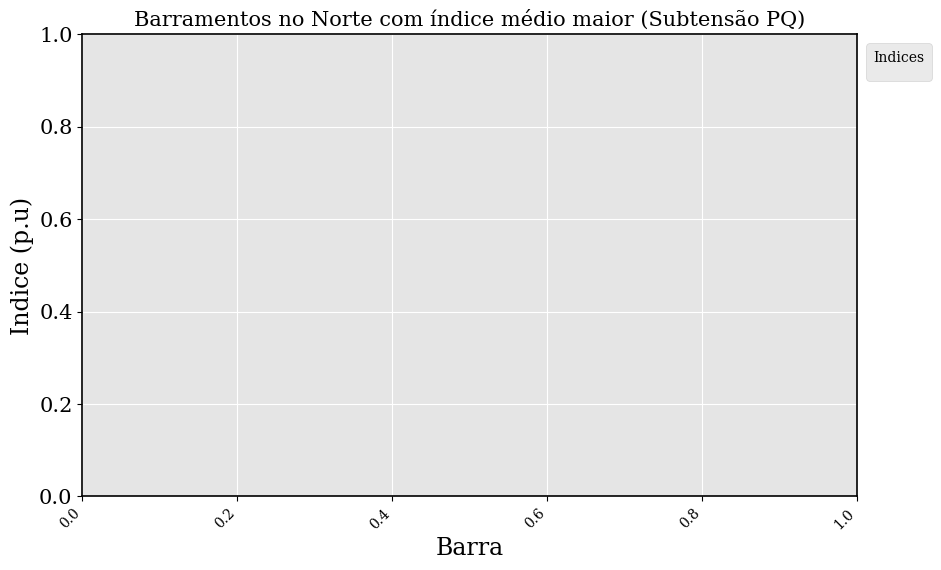

In [57]:
if Analise_INDICE:
    df_criticos = df_PQ_indices.loc[:,:,Region,:][(df_PQ_indices.loc[:,:,Region,:]['IndiceInf_s1']>1) & (df_PQ_indices.loc[:,:,Region,:]['IndiceSup_s1']<0.05)]
    print('numero de pontos de operação criticos')
    print(len(set(df_criticos.index.to_frame()[['key', 'Cenario']].apply(tuple, axis=1).values)))
    print('numero de areas criticas')
    print(len(set(df_criticos.index.to_frame()[['ARE']].apply(tuple, axis=1).values)))
    
    dfaux = df_filt_nt.merge(df_criticos, on=['key', 'Cenario', 'ARE'], how='inner')
    dfeatures_pq_inf = get_features(dfaux, df_criticos.index.to_frame()['ARE'].unique(), Region, ['BUS_ID'], 'PQ')
    plot_feature_data(dfeatures_pq_inf.nlargest(10, 'IndiceInf'), ['IndiceInf','ReservaINDshunt','ReservaCAPshunt'], 'Barramentos no Norte com índice médio maior (Subtensão PQ)')

In [58]:
df_criticos.value_counts('ARE')

Series([], Name: count, dtype: int64)

In [59]:
if Analise_INDICE:
    df_criticos = df_PQ_indices.loc[:,:,Region,:][(df_PQ_indices.loc[:,:,Region,:]['IndiceSup_s1']>1) & (df_PQ_indices.loc[:,:,Region,:]['IndiceInf_s1']<0.05)]
    print('numero de pontos de operação criticos')
    print(len(set(df_criticos.index.to_frame()[['key', 'Cenario']].apply(tuple, axis=1).values)))
    print('numero de areas criticas')
    print(len(set(df_criticos.index.to_frame()[['ARE']].apply(tuple, axis=1).values)))

    # plot_bus_data(df_criticos, df_criticos.value_counts('ARE').index[0], '(Subtensão PQ)', '% L1_500down', '% L1_500up')

    dfaux = df_filt_nt.merge(df_criticos, on=['key', 'Cenario', 'ARE'], how='inner')
    dfeatures_pq_inf = get_features(dfaux, df_criticos.index.to_frame()['ARE'].unique(), Region, ['BUS_ID'], 'PQ')
    plot_feature_data(dfeatures_pq_inf.nlargest(10, 'IndiceSup'), ['IndiceSup','ReservaINDshunt','ReservaCAPshunt'], 'Barramentos no Norte com índice médio maior (Sobretensão PQ)')

numero de pontos de operação criticos
7
numero de areas criticas
2



C:\Users\david\AppData\Local\Temp\ipykernel_34272\2651262526.py:132: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("rainbow")


In [60]:
df_criticos.value_counts('ARE')

ARE
452    6
431    2
Name: count, dtype: int64

# Analise Intercambios e Linhas

In [61]:
def boxplot_linhas(df, clase, yvalue, titulo, xlbl, ylbl, ylim = None):
    df = df.reset_index()
    plt.figure(figsize=(12, 6))

    # ax = sns.boxplot(data=df, x=clase, y=yvalue, hue="Cenario", width=0.8, linewidth=1.5, palette="mako",flierprops={'markerfacecolor': 'gray', 'marker': 'o'})
    ax = sns.boxplot(data=df, x=clase, y=yvalue, hue=clase, width=0.8, linewidth=1.5, palette="mako",flierprops={'markerfacecolor': 'gray', 'marker': 'o'})
    # Customize axes spines
    border_color = 'black'
    linewidth = 1.2
    ax.spines['top'].set_color(border_color)
    ax.spines['bottom'].set_color(border_color)
    ax.spines['left'].set_color(border_color)
    ax.spines['right'].set_color(border_color)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)

    # Customize the boxplot elements
    for cap in ax.artists:
        cap.set_edgecolor(border_color)
        cap.set_facecolor('white')

    for median in ax.lines:
        median.set_color('darkblue')
        median.set_linewidth(1.5)

    plt.title(titulo, fontsize=18)
    plt.xlabel(xlbl, fontsize=16, color='black')
    plt.ylabel(ylbl, fontsize=16, color='black')
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')
    # plt.legend(title='Scenarios', loc='best', fontsize=13)
    #labels
    plt.tick_params(axis='x', colors='black')  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks
    if ylim !=  None:
        plt.ylim(ylim)
    plt.show()
    
if Analise_Linhas:

    df_linhas_500up = DATA['linhas'][DATA['linhas']['VBASEKV'].isin([500, 525, 765])]
    df_linhas_500down = DATA['linhas'][DATA['linhas']['VBASEKV'].isin([230, 345, 440])]
    df_linhas_500up_grouped = df_linhas_500up.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum','MW:Losses': 'sum'}).rename(columns={'% L1': '% L1_500up', 'Mvar:Losses': 'Mvar:Losses_500up', 'MW:Losses': 'MW:Losses_500up'})
    df_linhas_500down_grouped = df_linhas_500down.groupby(['Dia', 'Hora', 'REG', 'Cenario']).agg({'% L1': 'mean', 'Mvar:Losses': 'sum','MW:Losses': 'sum'}).rename(columns={'% L1': '% L1_500down', 'Mvar:Losses': 'Mvar:Losses_500down', 'MW:Losses': 'MW:Losses_500down'})
    df_linhas_grouped_REG = pd.concat([df_linhas_500up_grouped, df_linhas_500down_grouped], axis=1)
    df_linhas_grouped_REG = df_linhas_grouped_REG.rename(index=regionmap, level='REG')
    
    filtrolinh = set(df_linhas_500down[(df_linhas_500down['REG']=='AC-RO') & (df_linhas_500down['% L1']>50)][['Dia','Hora']].apply(tuple, axis=1).values)

    if Analise_alldata == True:

        filter_outliers = Df_data_completo_reg.index.to_frame()[['Dia', 'Hora']].apply(tuple, axis=1).isin(filtrolinh)
        # Df_data_completo_reg_ = Df_data_completo_reg[~filter_outliers].loc[:,:,:,['V1A1F2 2026','V1A1F2 2026']]
        Df_data_completo_reg_ = Df_data_completo_reg[~filter_outliers]

        boxplot_linhas(Df_data_completo_reg_, 'REG', '% L1_500up' , 'Carregamento Médio das linhas com nivel de tensão >= 500kV', 'Region', 'Line Loading (%)', ylim = None)
        boxplot_linhas(Df_data_completo_reg_, 'REG', 'Mvar:Losses_500up' , 'Soma Perdas Reativas das linhas com nivel de tensão >= 500kV', 'Region', 'Losses (MVAR)', ylim = None)
        boxplot_linhas(Df_data_completo_reg_, 'REG', '% L1_500down' , 'Carregamento Médio das linhas com nivel de tensão < 500kV', 'Region', 'Line Loading (%)', ylim = None)
        boxplot_linhas(Df_data_completo_reg_, 'REG', 'Mvar:Losses_500down' , 'Soma Perdas Reativas das linhas com nivel de tensão < 500kV', 'Region', 'Losses (MVAR)', ylim = None)

In [62]:
def scatterplot(df, v1, v2, v3=None, xlimites=None, ylimites=None, namedir=None):
    cmap = plt.cm.get_cmap("rainbow_r")  # '_r' suffix to reverse the colormap
    plt.figure(figsize=(10, 6))
    
    if v3 is None:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, s=60, legend=None)
    else:
        scatter = sns.scatterplot(data=df, x=v1, y=v2, palette=cmap, hue=v3, s=60, legend=None)
        norm = mcolors.Normalize(vmin=df[v3].min(), vmax=df[v3].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=scatter, orientation='vertical', label='% FERV',)
        # Set color bar tick labels to black
        cbar.ax.yaxis.set_tick_params(color='black',labelsize=12)
        plt.setp(cbar.ax.get_yticklabels(), color='black')
        # Set the color and size of the color bar legend label
        cbar.set_label('% FERV', fontsize=15, color='black')

    nometitulo = ''
    plt.title(nometitulo, fontsize=15)
    plt.xlabel('Loading %', fontsize=16, color='black')
    plt.ylabel('(MVAR)', fontsize=16, color='black')
    plt.tick_params(axis='both', labelsize=15, labelcolor='black')  # Set the color for the tick labels
    plt.tick_params(axis='x', colors='black')  # Set the color for the x-axis ticks
    plt.tick_params(axis='y', colors='black')  # Set the color for the y-axis ticks

    if xlimites is not None:
        plt.xlim(xlimites)
    if ylimites is not None:
        plt.ylim(ylimites)

    plt.show()

    correlation = df[v1].corr(df[v2])
    print(f"Indice de Correlación: {correlation}")

In [63]:
if Analise_Linhas:
    df_linhas_grouped_REG_ = df_linhas_grouped_REG.reset_index().merge(DF_complete_PO, on=['Dia','Hora', 'Cenario']).reset_index().set_index(['Dia', 'Hora', 'REG', 'Cenario'])

    reg = 'North'

    # scatterplot_1(df_linhas_grouped_REG_.loc[:,:,reg,:],'% L1_500up', 'MW:Losses_500up','Carregamento Médio %', 'Perdas Ativas (MW)', 'Perdas Reativas (MVAR)', 'Mvar:Losses_500up')
    # scatterplot_1(df_linhas_grouped_REG_.loc[:,:,reg,:][df_linhas_grouped_REG_.loc[:,:,reg,:]['MW:Losses_500down']>0],'% L1_500down', 'MW:Losses_500down','Carregamento Médio %', 'Perdas Ativas (MW)', 'Perdas Reativas (MVAR)', 'Mvar:Losses_500down')

    # scatterplot_1(df_linhas_grouped_REG_.loc[:,:,reg,:],'% L1_500up', 'MW:Losses_500up','Carregamento Médio %', 'Perdas Ativas (MW)', 'FERV %', 'PG_FERV')
    # boxplot_linhas(df_linhas_grouped_REG.loc[:,:,:,:], 'REG', 'MW_Flow_under500' , 'Soma do Fluxo das linhas com nivel de tensão < 500kV', 'Region', '(MW)', ylim = None) 

    df_1 = DATA['df_Inter_AC_DC'].reset_index().melt(id_vars=['key','Dia', 'Hora', 'Cenario'], var_name='Intercambio', value_name='Value')
    df_fluxos_AC = df_1[df_1['Intercambio'].isin(['Fluxo_N-S', 'Fluxo_NE-N', 'Fluxo_NE-SE', 'Fluxo_SUL-SECO'])]
    df_fluxos_DC = df_1[df_1['Intercambio'].isin(['Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_XINGU-SE'])]

    # Paso 1: Filtrar los valores negativos
    negativos = df_1[df_1['Value'] < 0]
    # Paso 2: Contar cuántos valores negativos hay para cada 'Intercambio'
    conteo_negativos = negativos.groupby('Intercambio').size()
    # Paso 3: Contar el número total de entradas para cada 'Intercambio'
    conteo_total = df_1.groupby('Intercambio').size()
    # Paso 4: Calcular el porcentaje
    porcentaje_negativos = (conteo_negativos / conteo_total) * 100
    # Mostrar el resultado
    print(porcentaje_negativos)

    boxplot_(df_1,'Value', clase = "Intercambio", hue='Intercambio', titulo = 'Interligações AC-HVDC', xlbl = '',ylbl ='(MW)', indice = False)


In [64]:
if Analise_Linhas:    
    boxplot_(df_fluxos_DC[df_fluxos_DC['Cenario'].isin(['V1A1F5', 'V2A2F5', 'V3A3F5'])],'Value', clase = "Intercambio", hue='Cenario', titulo = 'Interligações DC', xlbl = '',ylbl ='(MW)', indice = False)
    boxplot_(df_fluxos_AC[df_fluxos_AC['Cenario'].isin(['V1A1F5', 'V2A2F5', 'V3A3F5'])],'Value', clase = "Intercambio", hue='Cenario', titulo = 'Interligações AC', xlbl = '',ylbl ='(MW)',  indice = False)

In [65]:
if Analise_Linhas: 
    df_fluxos_DC[(df_fluxos_DC['Cenario'].isin(['V1A1F5'])) & (df_fluxos_DC['Intercambio']=='Elo_FOZ-IBIUNA')]['Value'].mean()

In [66]:
# def plot_potencia_perfil(df_resultado, df_data, column, ylim = None, markers=True,):

#     df = df_resultado.merge(df_data,on=['Dia','Hora', 'Cenario'], how='left')
#     plt.figure(figsize=(20, 7))
#     sns.lineplot(data=df, x='Dia_Hora', y=column, hue='Cenario', markers=markers, lw = 2)
#     plt.xlabel('(Dia, Hora)', fontsize = 15)
#     plt.ylabel('(MW)', fontsize = 15)
#     if column == 'DemandaLiquida':
#         plt.title(f'Demanda Liquida Total do Sistema', fontsize = 15)
#     else:
#         plt.title(f'Perfil de Potencia de {column}', fontsize = 15)

#     value = int(df['Dia_Hora'].unique().shape[0] / 28)
#     selected_ticks = df[df['Cenario'] == df['Cenario'].unique()[0]].iloc[::value]['Dia_Hora']
#     plt.xticks(selected_ticks, rotation=45, fontsize=12)
#     plt.tick_params(axis='y', labelsize=12)
#     plt.legend(title='Cenarios', fontsize = 12)
#     if ylim != None:
#         plt.ylim(ylim)
#     plt.tight_layout()
#     plt.grid()
#     plt.show()

# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_FOZ-IBIUNA', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_PVEL-ARARQ', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_XINGU-SE', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Elo_CPVBTB-PVEL', markers=False)

In [67]:
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_N-S', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_NE-N', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_NE-SE', markers=False)
# plot_potencia_perfil(df_mask, DATA['df_Inter_AC_DC'], 'Fluxo_SUL-SECO', markers=False)